# Detección de anomalías en datacenters (CPDs)
Autor: Fernando Fernández-Martínez, Universidad Politécnica de Madrid
---

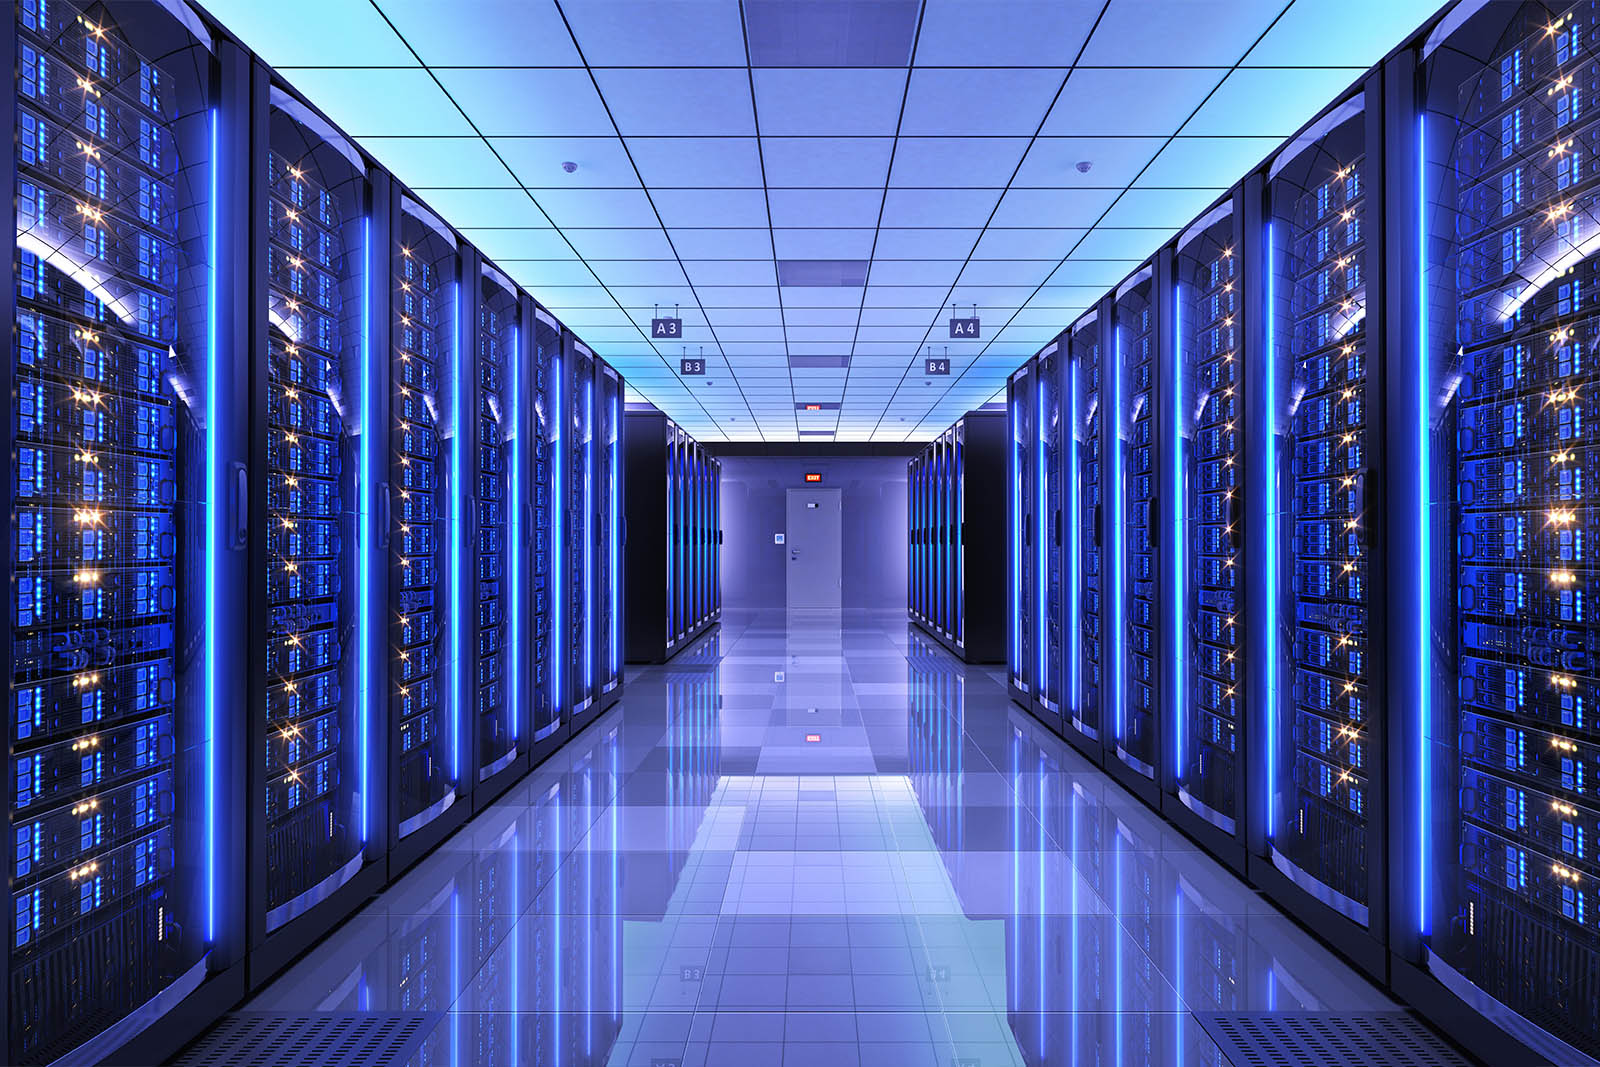

Por **detección de anomalías** podemos entender cualquier "método que se pueda utilizar para identificar **patrones irregulares o inusuales** en un entorno complejo como es el que rodea a los centros de procesado de datos. Tales patrones anómalos, a menudo, se ponen de manifiesto de manera no evidente para el ser humano.

La necesidad de analizar miles, tal vez **millones, de datos diferentes** impiden que una persona pueda abordar dicho análisis correctamente, al menos no en el tiempo que requiere la eficaz e inmediata actuación que debe permitir **anticipar y evitar las consecuencias de una eventual caída** del centro de datos.

Adicionalmente, la **complejidad de dichos patrones anómalos** dificulta su detección, hasta tal punto que una mera representación de las series temporales en un panel de control resulta claramente insuficiente. Se necesitan, por tanto, herramientas más potentes y eficaces, como son las soluciones basadas en aprendizaje automático e inteligencia artificial similares a las que emplearemos en la presente práctica.

Nuestro objetivo en ese sentido será doble:

*   **Caracterización y modelado** del comportamiento de un centro de datos en términos de **temperatura, humedad y presión**. Es necesario entender qué se considera como comportamiento normal para poder realizar la detección de anomalías.

*   Familiarizarse con una posible **metodología** basada en métodos de inteligencia artifical para la detección de anomalías. En particular, emplearemos **métodos no supervisados** como el agrupamiento o **clustering** automático para identificar patrones anormales dentro de nuestro conjunto de datos prestando especial atención a su adecuada interpretación.




# Paso 1) Setup general

Bloque básico de instalación de librerías y herramientas básicas necesarias para la ejecución.
Este bloque DEBE EJECUTARSE SIEMPRE AL PRINCIPIO.

In [1]:
!pip install PyDrive
!pip install fastparquet

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import statistics

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import Counter
from itertools import groupby
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

from fastparquet import ParquetFile
from fastparquet import write

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

sns.set_theme()
sns.set_context("paper")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


# Paso 2) Conexión con Google Drive para recuperar los ficheros con los datos
Autorice el acceso con su ID de Google, pegue el enlace que aparece y presione "Enter"

In [2]:
"""
Authenticate and create the PyDrive client
"""
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#!rm -Rf data

In [4]:
# extract the ID of the file
file_id = "1hlcl9A5nNEpUtyDfpuxKVMEm3giLyO8B"

# append the id to this REST command
file_download_link = "https://docs.google.com/uc?export=download&id=" + file_id

!wget -O data.zip --no-check-certificate "$file_download_link" && unzip data.zip

--2023-11-22 08:55:37--  https://docs.google.com/uc?export=download&id=1hlcl9A5nNEpUtyDfpuxKVMEm3giLyO8B
Resolving docs.google.com (docs.google.com)... 172.253.114.100, 172.253.114.139, 172.253.114.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.114.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/78mtieib8rqph5bfb8mc2cout97k3c78/1700643300000/18166315461345400735/*/1hlcl9A5nNEpUtyDfpuxKVMEm3giLyO8B?e=download&uuid=343b0bfb-9233-4075-928b-669fbb88739e [following]
--2023-11-22 08:55:40--  https://doc-10-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/78mtieib8rqph5bfb8mc2cout97k3c78/1700643300000/18166315461345400735/*/1hlcl9A5nNEpUtyDfpuxKVMEm3giLyO8B?e=download&uuid=343b0bfb-9233-4075-928b-669fbb88739e
Resolving doc-10-6g-docs.googleusercontent.com (doc-10-6g-docs.googleusercontent.com)... 64.233.183.132, 2607:f

Esta celda contien un método de descarga de los datos alternativo. **NO USAR a menos que no funcione el método de la celda anterior. **

In [3]:
downloaded = drive.CreateFile({'id':"1iJCRYJ8ke1Vn-crTtzAiESnUVcFAuf1u"}) # Reemplace el valor de 'id' por el correspondiente al fichero data.zip almacenado en su drive
downloaded.GetContentFile('data.zip')
!unzip data.zip

Archive:  data.zip
  inflating: data/df_index_only_pulses.parquet  
  inflating: data/df_index_deleted_pulses.parquet  
  inflating: data/planos_h_deleted_pulses.json  
  inflating: data/planos_t_deleted_pulses.json  
  inflating: data/planos_p_deleted_pulses.json  
  inflating: data/planos_t.json      
  inflating: data/planos_p.json      
  inflating: data/df_only_pulses_V2.parquet  
  inflating: data/df_no_pulses_V2.parquet  
  inflating: data/location.json      
  inflating: data/planos_h.json      
  inflating: data/df_prep_complete_V2.parquet  
  inflating: data/df_deleted_pulses_V2.parquet  


# Paso 3) Importación de funciones auxiliares
Definición de las funciones auxiliares requeridas

In [5]:
"""
load_json_data: Función que permite cargar los datos almacenados en un fichero json
"""
def load_json_data(json_file):
  dir = '/content/'+json_file
  data = pd.read_json(dir)
  return data

"""
load_json_data: Función que permite cargar los datos almacenados en un fichero parquetfile
"""
def load_pq_data(pq_file):
  dir = '/content/'+pq_file
  data = pd.read_parquet(dir)
  return data

"""
save_file: Función que permite salvar datos
"""
def save_file(name, file):
  write(name, file, compression='GZIP')

"""
set_size_letters(): Función que permite modificar el tamaño letra a utilizar en los plots
"""
def set_size_letters(title, x_name, y_name, title_size = 20, x_size = 18, y_size = 18, active_legend = True, legend_size = 14):

  """
  Parameters:
    title (string): titulo del plot a representar

    x_name (string): nombre del eje x

    y_name (string): nombre del eje y

    active_legend (bool): indica si mostramos la leyenda o no. Por defecto True

    x_size, y_size, legend_size: tamaño de fuente de eje x, y, leyenda

  """

  plt.title(title, fontsize=title_size)
  plt.xlabel(x_name, fontsize=x_size)
  plt.ylabel(y_name, fontsize=y_size)
  if (active_legend == True):
    plt.legend(fontsize=legend_size)

"""
PlotDistancesToKnearestNeighbor: Función que devuelve la distancia con el K-vecino más cercano
"""
def PlotDistancesToKnearestNeighbor(data_vector, K):

  """
  Parameters:
    data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    k: posición del k-esimo vecino más cercano

  """

  nbrs = NearestNeighbors(n_neighbors=K).fit(data_vector)
  distances, indices = nbrs.kneighbors(data_vector)
  distances = np.sort(distances, axis=0)
  distances = distances[:,K-1]
  plt.figure(figsize=(10,8))
  set_size_letters(f"Distancias al K-vecino más cercano (K={K})",
                   f"Points sorted according to distance of the {K}-th nearest neighbor",
                   f"{K}-th nearest neighbor distance")
  plt.plot(distances)
  #
  #plt.plot(min_dist)

"""
nearest_neighbor_distance: Función que devuelve la distancia con el vecino más cercano
"""
def nearest_neighbor_distance (data_vector, name_clustering):

  """
  Parameters:
    data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    name_clustering (string): nombre de los datos representados, se utiliza
        para el titulo del plot realizado

  """

  nbrs = NearestNeighbors(n_neighbors=2).fit(data_vector)
  distances, indices = nbrs.kneighbors(data_vector)

  min_dist = np.sort(distances[:,1])

  plt.figure(figsize=(10,8))
  set_size_letters(f"Distancia al vecino más cercano: datos {name_clustering}", "nº muestra", "epsilon")
  plt.plot(min_dist)

"""
dbScan_nsamples: Función que reliza barrido dbscan con calculo de silueta
"""
def dbScan_nsamples(data, epsilon_vect, min_samples = 30, include_noise = False):
  """
  Parameters:

    data (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    epsilon_vect (list): lista con los valores de epsilon
        para realizar el barrido (distancia mínima entre elementos
        para formar un cluster)

    min_samples (int): numero minimo de muestras para generar un cluster

    include_noise (bool): permite seleccionar si se quiere incluir el cluster
        de ruido en el cálculo de la silueta o no. Por defecto no se incluye.
        Se debe incluir cuando únicamente se detecta un cluster, para poder
        realizar la evaluación.
  """

  for epsilon in epsilon_vect:

    db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    silhouette_data = np.copy(data)
    noise_points = np.where(labels == -1)

    # delete noise cluster
    if (include_noise == False):
      silhouette_data = np.delete(silhouette_data, noise_points, axis=0)
      silhouette_labels = np.delete(labels, noise_points, axis=0)
    else:
      silhouette_labels = np.copy(labels)

    #calculate silhouette_score
    silhouette_avg = silhouette_score(silhouette_data, silhouette_labels)
    print(f"Epsilon = {epsilon}")
    print(f"N clusters: {n_clusters_}, Nº_noise_points = {n_noise_}")
    print(f"silhouette_score = {silhouette_avg} \r\n")

"""
ApplyDBScanToData: Función que permite seleccionar DBSCAN
"""
def ApplyDBScanToData (samples, epsilon, min_samples = 30):

  """
  Parameters:

    samples (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

    epsilon: int con el valor de epsilon (distancia mínima entre elementos
        para formar un cluster)

    min_samples (int): numero minimo de muestras para generar un cluster

    include_noise (bool): permite seleccionar si se quiere incluir el cluster
        de ruido en el cálculo de la silueta o no. Por defecto no se incluye.
        Se debe incluir cuando únicamente se detecta un cluster, para poder
        realizar la evaluación.

  Return:

    labels: lista con el cluster al que pertenece cada ejemplo de data. Cluster
        -1 significa ruido.
  """


  db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(samples)

  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_

  # Number of clusters in labels, ignoring noise if present.
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_noise_ = list(labels).count(-1)

  print(f"\nTest for epsilon = {epsilon}")
  print('Estimated number of clusters: %d' % n_clusters_)
  print('Estimated number of noise points: %d' % n_noise_)
  print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(samples, labels))


  return labels

def Plot2D (samples_2D, title, axes = {'x': 'x', 'y': 'y'}):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  title(string): titulo de la figura que se utiliza para el plot
  """

  df_samples_2D = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D,
              x=axes['x'],
              y=axes['y'],
              height=10, legend="full", palette="bright")

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')

def plot_2D_centroid_labels(df_centroids, ax):
    for index, row in df_centroids.iterrows():
      ax.text(row[0]+.5, row[1], 'C'+str(row[2].astype(int)), fontsize = 20, color='black', weight='semibold')

def plot_3D_centroid_labels(df_centroids, ax):
    for index, row in df_centroids.iterrows():
      ax.text(row[0]+.5, row[1], row[2], row[3].astype(int), fontsize = 20, color='black', weight='semibold')

def Plot2D_WithLabels (samples_2D, labels, title, axes = {'x': 'x', 'y': 'y'}, palette="bright", centroids_2D=None):

  """
  samples_2D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 2) ; 2 por las dos coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_2D_labeled = pd.DataFrame(data=samples_2D, columns=[axes['x'], axes['y']])

  # Then we add the labels column
  df_samples_2D_labeled['label'] = labels.tolist()

  if centroids_2D is not None:
    labels_centroid_aux = np.arange(len(centroids_2D), dtype=int)
    df_centroids_2D_labeled = pd.DataFrame(data=centroids_2D, columns=[axes['x'], axes['y']])
    df_centroids_2D_labeled['label'] = labels_centroid_aux.tolist()

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=df_samples_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label", height=10, legend="full", palette=palette)

  if centroids_2D is not None:
    # First we plot the centroids
    sns.scatterplot(data=df_centroids_2D_labeled,
              x=axes['x'],
              y=axes['y'],
              hue="label",
              legend=False, palette=palette, s=100)

    # Then we plot their labels
    plot_2D_centroid_labels(df_centroids_2D_labeled, plt.gca())

  set_size_letters(title,
                   axes['x'],
                   axes['y'],
                   active_legend = False)
  plt.axis('equal')

def Plot3D (samples_3D, title, axes = {'x': 'x', 'y': 'y', 'z': 'z'}):

  """
  samples_3D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 3) ; 3 por las tres coordenadas

  title(string): titulo de la figura que se utiliza para el plot
  """

  df_samples_3D = pd.DataFrame(data=samples_3D, columns=[axes['x'], axes['y'], axes['z']])

  fig = px.scatter_3d(df_samples_3D,
                      x=axes['x'],
                      y=axes['y'],
                      z=axes['z'])

  fig.update_layout(scene_aspectmode='data')

  fig.update_layout(
    title_font_size=20,
    title={
        'text': title,
        'y': 0.9,
        'x': 0.05,
        'xanchor': 'left',
        'yanchor': 'top'})

  # tight layout
  fig.update_layout(
      autosize = True, #False,
      #width = 1200,
      #height = 800,
      margin = dict(l=50, r=0, b=10, t=30))

  fig.show()

def Plot3D_WithLabels (samples_3D, labels, title, axes = {'x': 'x', 'y': 'y', 'z': 'z'}, centroids_3D=None):

  """
  samples_3D (numpy.ndarray): array tipo embedding cuyo
        shape es (num_muestras, 3) ; 3 por las tres coordenadas

  labels (array): etiqueta perteneciente a cada muestra.

  title(string): titulo de la figura que se utiliza para el plot
  """

  # First we create the dataframe
  df_samples_3D_labeled = pd.DataFrame(data=samples_3D, columns=[axes['x'], axes['y'], axes['z']])

  # Then we add the labels column
  df_samples_3D_labeled['label'] = labels.tolist()
  df_samples_3D_labeled['label'] = df_samples_3D_labeled["label"].astype(str)

  if centroids_3D is not None:
    # Same applies for centroids when these are provided as an argument
    labels_centroid_aux = np.arange(len(centroids_3D), dtype=int)
    df_centroids_3D_labeled = pd.DataFrame(data=centroids_3D, columns=[axes['x'], axes['y'], axes['z']])
    df_centroids_3D_labeled['label'] = labels_centroid_aux.tolist()

    # We create an additional column with the dot size used for each type of sample
    size_no_centroid = np.ones(len(samples_3D)) * 10 # for regular samples
    size_centroid = np.ones(len(centroids_3D)) * 50 # for centroids
    size_col = np.append(size_no_centroid, size_centroid) # new col to be added to the dataframe

    # We also create another additional column with the labels for each type of sample
    no_es_centroide_aux = [' '] * len(samples_3D) # empty label for regular samples
    es_centroide_aux = []
    for i in range(len(centroids_3D)):
      es_centroide_aux.append('C%d' % i) # Ci label for centroid i
    centroid_col = no_es_centroide_aux + es_centroide_aux # new col to be added to the dataframe

    # Next we concatenate both dataframes: first, regular samples, then, centroids
    df_samples_and_centroids = df_samples_3D_labeled.append(df_centroids_3D_labeled, ignore_index=True)

    # We add the new column with the labels distinguishing regular samples from centroids
    df_samples_and_centroids['centroid'] = centroid_col

    # New column is re-casted as a string column
    df_samples_and_centroids['centroid'] = df_samples_and_centroids['centroid'].astype(str)

    # We add the new column with the corresponding size for both regular samples and centroids
    df_samples_and_centroids['size'] = size_col

    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_and_centroids['label'] = pd.to_numeric(df_samples_and_centroids['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_and_centroids.sort_values(by=['label'], ascending=True)

    # And plot both the samples and their corresponding centroids
    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], text='centroid', size='size', color='label')
  else:
    # We ensure that the 'label' column is numeric since we will sort the dataframe upon this one
    df_samples_3D_labeled['label'] = pd.to_numeric(df_samples_3D_labeled['label'])

    # We finally sort the dataframe by the 'label' column in ascending order
    df_samples_and_centroids_sorted = df_samples_3D_labeled.sort_values(by=['label'], ascending=True)

    fig = px.scatter_3d(df_samples_and_centroids_sorted, x=axes['x'], y=axes['y'], z=axes['z'], color='label', size=np.ones(len(samples_3D))) #, color_continuous_scale='delta')

  fig.update_traces(textposition='top center')
  fig.update_layout(scene_aspectmode='data')
  fig.update_layout(uniformtext_minsize=60)

  fig.update_layout(title_font_size=20,
                    title={
                    'text': title,
                    'y': 0.9,
                    'x': 0.05,
                    'xanchor': 'left',
                    'yanchor': 'top'})
  # tight layout
  fig.update_layout(autosize = True, margin = dict(l=50, r=0, b=10, t=30))
  fig.show()

"""
Representacion pca2d dbscan: Función que permite obtener la representacion pca2d dbscan
"""
def pca2d_clustering_dbscan (data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """

  pca = PCA(n_components=2)
  pca.fit(data_vector)

  pca_data_vector = pca.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels + 1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  clustered_pca_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=clustered_pca_df, x="pca0", y="pca1", hue="label", height=10, legend="full", palette="bright")

  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1", active_legend = False)
  plt.axis('equal')

"""
pca2d_no_clustering: Función que permite obtener representación PCA en 2D
"""
def pca2d_no_clustering (data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """

  pca = PCA(n_components=2)
  pca.fit(data_vector)

  pca_data_vector = pca.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels + 1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  clustered_pca_df = pd.DataFrame(data=pca_data_vector_labeled,
                                  columns=["pca0", "pca1", "label"])

  sns.set(font_scale=3)
  sns.set(rc={'figure.figsize':(10,10)})
  sns.relplot(data=clustered_pca_df,
              x="pca0",
              y="pca1", height=10, legend="full", palette="bright")

  set_size_letters(f"PCA 2D: datos {clustering_name}", "PCA0", "PCA1", active_legend = False)
  plt.axis('equal')

"""
pca3d_clustering_dbscan: Función que permite obtener la representación PCA3D DBSCAN
"""
def pca3d_clustering_dbscan(data_vector, labels, clustering_name):

  """
  data_vector (numpy.ndarray): array tipo embedding cuyo
        shape es (n_ejemplo,n_muestras_por_ejemplo)

  labels (array): clusters al que pertenece cada muestra. En la representación
        se suma `1' al label indicado (ruido pasa a ser cluster 0)

  clustering_name(string): nombre del clustering, se utiliza para el plot
  """


  pca_3d = PCA(n_components=3)
  pca_3d.fit(data_vector)

  pca_3d_data_vector = pca_3d.transform(data_vector)

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_3d_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_3d_clustered_values[key] = np.append(pca_3d_clustered_values[key], pca_3d_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_3d_clustered_values[keys[k]] = np.delete(pca_3d_clustered_values[keys[k]],[0])
    pca_3d_clustered_values[keys[k]] = np.reshape(pca_3d_clustered_values[keys[k]], (-1, 3))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux + 1

  pca_3d_data_vector_labeled = np.append(pca_3d_data_vector, labels_aux, axis=1)

  clustered_pca_3d_df = pd.DataFrame(data=pca_3d_data_vector_labeled, columns=["pca0", "pca1", "pca2", "label"])

  lab_aux = values_labels +1
  lab_aux = lab_aux.tolist()


  df = clustered_pca_3d_df.copy()
  df["label"] = df["label"].astype(str)
  fig = px.scatter_3d(df, x='pca0', y='pca1', z='pca2',
                color='label')
  fig.update_layout(scene_aspectmode='data')

  fig.update_layout(
    title_font_size=20,
    title={
        'text': f"PCA 3D: clustering {clustering_name}",
        'y':0.9,
        'x':0.05,
        'xanchor': 'left',
        'yanchor': 'top'})

  # tight layout
  fig.update_layout(
      autosize=False,
      width=1200,
      height=800,
      margin=dict(l=50, r=0, b=10, t=30))

  fig.show()

"""
calculate_centroids: Función que permite el cálculo de los centroides
"""
def calculate_centroids(data_vector, labels):

  """
  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

  return
      centroids (numpy.ndarray): array donde se almacenan las coordenadas
            de los centroides calculados. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster
  """

  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  n_samples, n_col = data_vector.shape
  fpb_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    fpb_clustered_values[key] = np.append(fpb_clustered_values[key], data_vector[i])

  #delete none value
  for k in range (len(keys)):
    fpb_clustered_values[keys[k]] = np.delete(fpb_clustered_values[keys[k]],[0])
    fpb_clustered_values[keys[k]] = np.reshape(fpb_clustered_values[keys[k]], (-1, n_col))

  centroids = np.zeros([len(keys), n_col])
  for n_clust in range (len(keys)):
    for col in range (n_col-1):
      data=fpb_clustered_values[str(n_clust)][:,col]
      centroids[n_clust, col] = np.mean(data, axis=0)
  return centroids

"""
pca2d_clustering_dbscan_with_centroids: Función que permite la representacion PCA2D clustering con centroides
"""
def pca2d_clustering_dbscan_with_centroids(data_vector, centroids, labels, clustering_name):

  """

  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      centroids (numpy.ndarray): array con las coordenadas
            de los centroides. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

      clustering_name(string): nombre del clustering, se utiliza para el plot

  Extra:
      si los datos presentan mas de 2 dimensiones se realiza la transformación
      PCA.

  """

  if data_vector.shape[1] > 2:
    pca = PCA(n_components=2)
    pca.fit(data_vector)

    pca_data_vector = pca.transform(data_vector)
  else:
    pca_data_vector = data_vector

  if centroids.shape[1] > 2:
    pca_centroids = pca.transform(centroids)
  else:
    pca_centroids = centroids


  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  labels_centroid_aux = np.arange(len(pca_centroids))
  labels_centroid_aux = np.reshape(labels_centroid_aux, (-1,1))

  pca_centroids_labeled = np.append(pca_centroids, labels_centroid_aux, axis=1)

  pca_clustered_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])
  pca_centroid_df = pd.DataFrame(data=pca_centroids_labeled, columns=["pca0", "pca1", "label"])


  sns.set(rc={'figure.figsize':(18,15)})
  sns.set(font_scale=1.5)
  ax = sns.scatterplot(data=pca_clustered_df, x="pca0", y="pca1", hue="label", legend='full', palette="bright", s=20)
  ax = sns.scatterplot(data=pca_centroid_df, x="pca0", y="pca1", hue="label", legend=False, palette="bright", s=100)

  def label_point(x, y, val, ax):
      a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
      for i, point in a.iterrows():
          ax.text(point['x']+.02, point['y'], str(point['val']))

  label_point(pca_centroid_df.pca0, pca_centroid_df.pca1, pca_centroid_df.label, plt.gca())
  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1")
  plt.axis('equal')

"""
pca2d_clustering_dbscan_with_centroids_no_noise: Función que permite obtener la representación PCA2D clustering DBSCAN con centroides y sin ruido
"""
def pca2d_clustering_dbscan_with_centroids_no_noise(data_vector, centroids, labels, clustering_name):

  """

  parameters
      data_vector (numpy.ndarray): array tipo embedding cuyo
            shape es (n_ejemplo,n_muestras_por_ejemplo)

      centroids (numpy.ndarray): array con las coordenadas
            de los centroides. Shape: (n_clusters, n_features)
            Donde n_clusters es clusters + noise_cluster

      labels (array): clusters al que pertenece cada muestra. En la representación
            se suma `1' al label indicado (ruido pasa a ser cluster 0)

      clustering_name(string): nombre del clustering, se utiliza para el plot

  Extra:
      - si los datos presentan mas de 2 dimensiones se realiza la transformación
      PCA.
      - Hay un error que imprime un punto de ruido para poder tener la leyenda
      con los mismos colores que en el caso con ruido. Originalmente se imprimía
      fuera, pero ahora al hacer el plt.axis('equal') no se puede 'sacar' de la
      figura

  """

  if data_vector.shape[1] > 2:
    pca = PCA(n_components=2)
    pca.fit(data_vector)

    pca_data_vector = pca.transform(data_vector)
  else:
    pca_data_vector = data_vector

  if centroids.shape[1] > 2:
    pca_centroids = pca.transform(centroids)
  else:
    pca_centroids = centroids


  values_labels, k = np.unique(labels, return_counts=True)
  keys = values_labels +1
  keys = list(map(str,keys))

  pca_clustered_values = dict.fromkeys(keys,None)
  for i in range (len(labels)):
    key = str(labels[i]+1)
    pca_clustered_values[key] = np.append(pca_clustered_values[key], pca_data_vector[i])

  #delete none value
  for k in range (len(keys)):
    pca_clustered_values[keys[k]] = np.delete(pca_clustered_values[keys[k]],[0])
    pca_clustered_values[keys[k]] = np.reshape(pca_clustered_values[keys[k]], (-1, 2))

  labels_aux = np.reshape(labels, (-1,1))
  labels_aux = labels_aux +1

  pca_data_vector_labeled = np.append(pca_data_vector, labels_aux, axis=1)

  labels_centroid_aux = np.arange(len(pca_centroids))
  labels_centroid_aux = np.reshape(labels_centroid_aux, (-1,1))

  pca_centroids_labeled = np.append(pca_centroids, labels_centroid_aux, axis=1)

  pca_clustered_df = pd.DataFrame(data=pca_data_vector_labeled, columns=["pca0", "pca1", "label"])
  pca_centroid_df = pd.DataFrame(data=pca_centroids_labeled, columns=["pca0", "pca1", "label"])

  #eliminamos las filas de ruido
  pca_clustered_df_no_noise = pca_clustered_df.drop(pca_clustered_df[pca_clustered_df.label == 0].index)
  pca_centroid_df_no_noise = pca_centroid_df.drop(pca_centroid_df[pca_centroid_df.label == 0].index)
  #Añadimos un dato falso muy alejado para mantener los colores
  pca_clustered_df_no_noise = pca_clustered_df_no_noise.append(pd.DataFrame({"pca0":[12], "pca1":[12], "label":[0]}))
  pca_centroid_df_no_noise = pca_centroid_df_no_noise.append(pd.DataFrame({"pca0":[12], "pca1":[12], "label":[0]}))

  #plot
  sns.set(rc={'figure.figsize':(18,15)})
  sns.set(font_scale=1.5)
  ax = sns.scatterplot(data=pca_clustered_df_no_noise, x="pca0", y="pca1", hue="label", legend='full', palette="bright", s=20)
  ax = sns.scatterplot(data=pca_centroid_df_no_noise, x="pca0", y="pca1", hue="label", legend=False, palette="bright", s=100)


  def label_point(x, y, val, ax):
      a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
      for i, point in a.iterrows():
          ax.text(point['x']+.02, point['y'], str(point['val']))

  pca_centroid_df_no_noise = pca_centroid_df.drop(pca_centroid_df[pca_centroid_df.label == 0].index)
  label_point(pca_centroid_df_no_noise.pca0, pca_centroid_df_no_noise.pca1, pca_centroid_df_no_noise.label, plt.gca())
  set_size_letters(f"PCA 2D: clustering {clustering_name}", "PCA0", "PCA1")
  plt.axis('equal')

"""
plot_clustering_progresion: Función que permite obtener la representación evolución temporal clustering
"""
def plot_clustering_progresion(labels):

  """
  parameters:
      labels (numpy array): array con labels ordenadas de forma temporal.
          El cluster -1 es ruido.
          Ejemplo: array([-1, -1, -1, ...,  9,  9,  9])

  """

  # agrupamos labels
  count_dups = [sum(1 for _ in group) for _, group in groupby(labels)] #número de elementos repetidos

  keys = list(map(str, np.unique(labels).tolist()))
  list_of_data = {}

  for k in keys:
    list_of_data[k] = []

  n_data_act = 0
  n_data_next = 0
  for n in range (len(count_dups)):
    n_data_act = n_data_next
    n_data_next = n_data_next + count_dups[n]
    n_diff = n_data_next - n_data_act
    list_of_data[str(labels[n_data_act])].append((n_data_act,n_diff))

  fig, ax = plt.subplots()
  fig.set_size_inches(18.5, 10.5)
  y1 = 0
  y2 = 1
  for elem in keys:
    ax.broken_barh(list_of_data[elem], (y1, y2), facecolors='tab:blue')
    y1 += 1

  y_ticks = list(map(int, keys))
  y_ticks = [x+1.5 for x in y_ticks]
  tick_labels = []
  for elem in keys:
    tick_labels.append(f"Cluster: {elem}")

  ax.set_yticks(y_ticks)
  ax.set_yticklabels(tick_labels)
  set_size_letters("Evolución temporal clustering", "Nº muestra", "Cluster seleccionado")
  plt.show()

"""
compare_2_clusters: Función que permite comparar 2 clusters (boxplot)
"""
def compare_2_clusters(data1, data2, n_boxplot, measure, ticks_eje_x = None, colors = ['darkturquoise', 'pink'], legend = ["Boxplot_1", "Boxplot_2"]):

  """
    Parameters:
    data1 (list of list): datos a representar boxplot. Se representarán tantos
        boxplot como listas existan dentro de la lista principal.
        Ejemplo: [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

    data2: (list of list): datos a representar boxplot. Se representarán tantos
        boxplot como listas existan dentro de la lista principal.
        Ejemplo: [[6,4,2], [1,2,5,3,2], [2,3,5,1]]

    n_boxplot: número de boxplot a representar

    ticks_eje_x: Permite indicar el nombre de cada boxplot (opcional).
        Por defecto: None

    colors: Permite seleccionar el color de los boxplot.
        El primer parámetro será para data1, el segundo para data2
        Por defecto: ['darkturquoise', 'pink']

    legend: Inidica el nombre de los datos data1 y data2.
        Por defecto: ["Boxplot_1", "Boxplot_2"]

    Return: None

    Function: permite realizar un plot representando el boxplot de los datos1
        y datos2 simultáneamente.
   """

  if ticks_eje_x:
    ticks = ticks_eje_x

    # first boxplot pair

    positions_l = np.array(range(n_boxplot))*3-0.6
    positions_r = np.array(range(n_boxplot))*3+0.6

    fig, ax = plt.subplots()
    bpl = plt.boxplot(data_l, positions=positions_l, sym='', patch_artist=True, widths=0.8)
    bpr = plt.boxplot(data_r, positions=positions_r, sym='', patch_artist=True, widths=0.8)

    for box in bpl['boxes']:
        box.set_facecolor(color = colors[0])

    for box in bpr['boxes']:
        box.set_facecolor(color = colors[1])

    # Para la leyenda
    patch0 = mpatches.Patch(color=colors[0], label=legend[0])
    patch1 = mpatches.Patch(color=colors[1], label=legend[1])

    if ticks:
      plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.legend(handles=[patch0, patch1])
    set_size_letters(f"Busqueda outliers {measure}: {cluster} respecto a cluster_p", "Área", "Diferencia")
    plt.show()


# Paso 4) Carga de los datos "en crudo"

En esta práctica emplearemos una base de datos proporcionada por la
empresa TycheTools (https://www.tychetools.com/). Estos datos fueron adquiridos mediante una de sus soluciones para la monitorización de centros de datos basada en la medida de parámetros ambientales de forma no intrusiva. Para ello se desplegaron una serie de sensores colocados de forma estratégica en la sala para medir la temperatura, humedad y presión de cada uno de los racks que forman el centro de datos. Se puede ver el sensor utilizado en la siguiente figura.

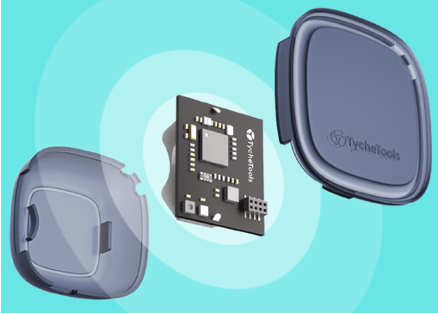

La empresa cuenta con datos de múltiples y diversos centros de datos, pero en esta práctica trabajaremos únicamente con las medidas de uno de ellos. **Los datos tienen carácter confidencial por lo que únicamente se facilita la inofrmación estrictamente necesaria para su estudio.**

Para la monitorización del centro de datos a estudiar se colocaron un total de **65 sensores**. Cada uno realiza **una medida de temperatura, humedad y presión cada 10 minutos** existiendo un total de **4070 muestras por cada sensor**. Esto equivale a aproximadamente **28 días** de muestras consecutivas en el centro de datos.

Cada una de las medidas va acompañada del **identificador del sensor** utilizado, un identificador temporal correspondiente a dicha medida (i.e. **timestamp**), así como la **ubicación** del mismo en el espacio (i.e. coordenadas x, y, z dentro de la sala), **rack** al que están monitorizando y un identificador de **inlet o outlet** (permite conocer si es la entrada de aire o la salida de aire del rack).

Las medidas disponibles tienen las siguientes unidades:
* la temperatura se encuentra en grados centígrados multiplicada por 100.
* los datos disponibles de humedad muestran la humedad relativa, por lo tanto medida en porcentaje (sin decimales).
* por último, la presión está almacenada en (x10-2Pa), por lo tanto, una medida de presión de 9473322 implica una presión de 947,3322 hPa.

La distribución en la sala se puede ver en la siguiente figura. Se puede apreciar que la sala está formada por dos filas compuestas por racks. Estas filas tienen distribuidos los racks de forma que sus entradas de aire están en dirección al pasillo central (conocido como **"pasillo frío"** o **"inlet"**), y sus salidas hacia los pasillos exteriores (conocidos como **"pasillos calientes"** o **"outlet"**).
En la figura se puede apreciar en color rojo los sensores colocados en los pasillos calientes y en azul los colocados en el pasillo frío. También se puede observar que hay un menor número de sensores en el pasillo frío.
Esto es debido a que las variaciones sufridas en el pasillo frío son teóricamente inferiores, por lo que no es necesario medir cada una de las entradas. Cada pasillo contiene una serie de racks. Estos se encuentran distribuidos en tres alturas y 8 columnas diferentes.

Aunque la figura no lo muestra, uno de los sensores corresponde a uno de los dos CRAC (Computer Room Air Conditioning) de refrigeración instalados en sala. Al no disponer de los datos del otro sensor conectado al otro CRAC se ha decidido prescindir de dicha información. Por lo tanto, utilizaremos solamente los datos de los 64 sensores ubicados en los racks.

Procedemos a cargar las lecturas de los sensores del CPD recuperando además la información sobre la ubicación de los diferentes nodos.

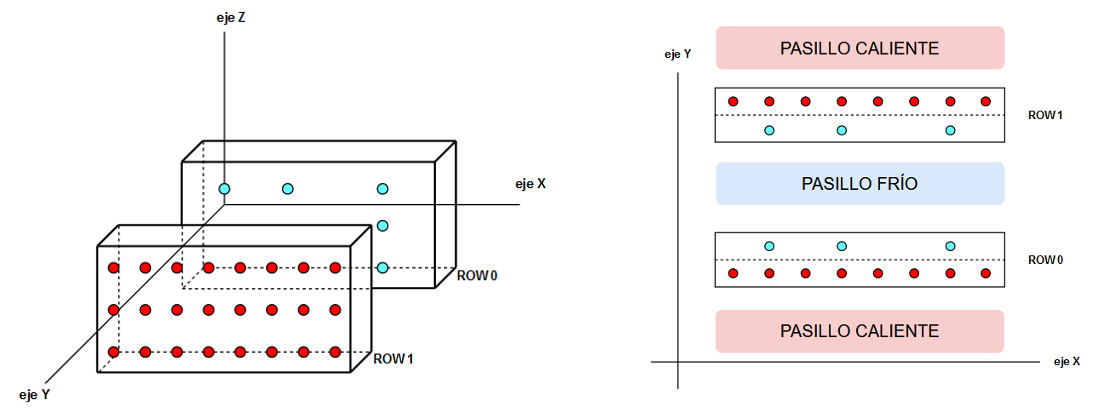

In [6]:
# La carga se realiza en dos pasos, primero cargamos los datos de los sensores
df_prep_comp = load_pq_data('data/df_prep_complete_V2.parquet')

# Segundo, cargamos su ubicación
location = load_json_data('data/location.json')

In [7]:
# Vistazo rápido a los datos de los sensores
df_prep_comp

timeID          deviceID        ClientID        date  sensors  \
0       12:30  8B45C243B7C7B3E5  interxionpilot  01/10/2020       65   
1       01:10  8B45C243B7C7B3E5  interxionpilot  08/10/2020       65   
2       04:00  8B45C243B7C7B3E5  interxionpilot  10/10/2020       65   
3       02:00  8B45C243B7C7B3E5  interxionpilot  11/10/2020       65   
4       13:30  8B45C243B7C7B3E5  interxionpilot  06/10/2020       65   
...       ...               ...             ...         ...      ...   
264459  01:40  8B45C243B7C7B3E5  interxionpilot  03/10/2020       65   
264460  14:50  8B45C243B7C7B3E5  interxionpilot  25/10/2020       65   
264461  23:30  8B45C243B7C7B3E5  interxionpilot  17/10/2020       65   
264462  22:40  8B45C243B7C7B3E5  interxionpilot  30/09/2020       65   
264463  18:20  8B45C243B7C7B3E5  interxionpilot  21/10/2020       65   

          macaddress     timestamp  lostPackages  transferid  temperature  \
0       c018119e2e62  1.601549e+09             0         194         2820   
1       c018119e2e62  1.602113e+09             0         134         2884   
2       c018119e2e62  1.602296e+09             0          50         2861   
3       c018119e2e62  1.602375e+09             0         113         2910   
4       c018119e2e62  1.601984e+09             0          21         2811   
...              ...           ...           ...         ...          ...   
264459  ffaba11c7636  1.601682e+09             0          13         2932   
264460  ffaba11c7636  1.603634e+09             0          33         2753   
264461  ffaba11c7636  1.602971e+09             0          35         2759   
264462  ffaba11c7636  1.601499e+09             0         107         2936   
264463  ffaba11c7636  1.603298e+09             0          40         2793   

        ...  battery  battid     battime            rack      Name  Inlet  \
0       ...     2941      13  1601541547  MAD1.410.R1B08  node_431      0   
1       ...     2916      19  1602059941  MAD1.410.R1B08  node_431      0   
2       ...     2903      21  1602232739  MAD1.410.R1B08  node_431      0   
3       ...     2908      22  1602319138  MAD1.410.R1B08  node_431      0   
4       ...     2910      18  1601973542  MAD1.410.R1B08  node_431      0   
...     ...      ...     ...         ...             ...       ...    ...   
264459  ...     2931      14  1601627896  MAD1.410.R1B05  node_436      0   
264460  ...     2866      37  1603615061  MAD1.410.R1B05  node_436      0   
264461  ...     2887      29  1602923873  MAD1.410.R1B05  node_436      0   
264462  ...     2907      12  1601455099  MAD1.410.R1B05  node_436      0   
264463  ...     2848      33  1603269467  MAD1.410.R1B05  node_436      0   

       Outlet    x    y    z  
0           1  900  462  109  
1           1  900  462  109  
2           1  900  462  109  
3           1  900  462  109  
4           1  900  462  109  
...       ...  ...  ...  ...  
264459      1  684  462  204  
264460      1  684  462  204  
264461      1  684  462  204  
264462      1  684  462  204  
264463      1  684  462  204  

[264464 rows x 23 columns]

In [8]:
# Vistazo rápido a location
location

macaddress          deviceID      Name   Building   room    aisle  \
0   ee083dc954fc  8B45C243B7C7B3E5  node_376  building1  room1     row2   
1   c951484e7557  8B45C243B7C7B3E5  node_377  building1  room1     row2   
2   f91c09c33cba  8B45C243B7C7B3E5  node_378  building1  room1     row2   
3   cc282299f903  8B45C243B7C7B3E5  node_379  building1  room1     row2   
4   c3ed028fcacf  8B45C243B7C7B3E5  node_380  building1  room1     row2   
..           ...               ...       ...        ...    ...      ...   
63  fa063d968f37  8B45C243B7C7B3E5  node_439  building1  room1     row1   
64  c9a31a0afd92  8B45C243B7C7B3E5  node_440  building1  room1     row1   
65  f13893f6f9d3  8B45C243B7C7B3E5  node_441  building1  room1     row1   
66  d5e45039e20a  8B45C243B7C7B3E5  node_442  building1  room1  rowcrac   
67  e133b8da151c  8B45C243B7C7B3E5  node_443  building1  room1  rowcrac   

              rack   U    Model  Ambient  Inlet  Outlet  Supply  Return     x  \
0   MAD1.410.R2B06  42  unknown        0      1       0       0       0   684   
1   MAD1.410.R2B06  21  unknown        0      1       0       0       0   684   
2   MAD1.410.R2B06   1  unknown        0      1       0       0       0   684   
3   MAD1.410.R2B08  42  unknown        0      1       0       0       0   900   
4   MAD1.410.R2B08  21  unknown        0      1       0       0       0   900   
..             ...  ..      ...      ...    ...     ...     ...     ...   ...   
63  MAD1.410.R1B04  42  unknown        0      0       1       0       0   576   
64  MAD1.410.R1B04  21  unknown        0      0       1       0       0   576   
65  MAD1.410.R1B04   1  unknown        0      0       1       0       0   576   
66           CRAC1  42  unknown        0      0       0       0       1   504   
67           CRAC2  42  unknown        0      0       0       0       1  1080   

      y    z        ClientID  x_max  y_max  
0   858  204  interxionpilot   1592   1252  
1   858  109  interxionpilot   1592   1252  
2   858   19  interxionpilot   1592   1252  
3   858  204  interxionpilot   1592   1252  
4   858  109  interxionpilot   1592   1252  
..  ...  ...             ...    ...    ...  
63  462  204  interxionpilot   1592   1252  
64  462  109  interxionpilot   1592   1252  
65  462   19  interxionpilot   1592   1252  
66  198  204  interxionpilot   1592   1252  
67  198  204  interxionpilot   1592   1252  

[68 rows x 20 columns]

# Paso 5) Limpieza de los datos
Paso habitual en cualquier proceso de adquisición. En este caso es preciso eliminar los datos del CRAC1 (nodos del propio rack de refrigeración) y todos los registros asociados al nodo "node_420" (incompleto, nos faltan valores).

Comenzaremos con operaciones básicas con la idea de familiarizarnos con los "dataframes" en Python (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) para a continuación realizar el filtrado.

In [9]:
# El siguiente comando recupera todos los valores únicos de la columna "rack" (sin repeticiones)
df_prep_comp['rack'].unique()

array(['MAD1.410.R1B08', 'MAD1.410.R2B11', 'MAD1.410.R2B08',
       'MAD1.410.R1B13', 'MAD1.410.R1B09', 'MAD1.410.R1B05',
       'MAD1.410.R2B06', 'MAD1.410.R1B04', 'MAD1.410.R2B04',
       'MAD1.410.R1B06', 'MAD1.410.R1B11', 'MAD1.410.R2B12',
       'MAD1.410.R2B10', 'CRAC1', 'MAD1.410.R2B09', 'MAD1.410.R1B12',
       'MAD1.410.R2B07'], dtype=object)

In [10]:
# El siguiente comando devuelve el número de registros (i.e. filas) presentes en la estructura para cada rack específico
df_prep_comp['rack'].value_counts()

MAD1.410.R2B08    24420
MAD1.410.R1B12    24420
MAD1.410.R1B05    24420
MAD1.410.R2B06    24420
MAD1.410.R2B11    24420
MAD1.410.R1B08    20350
MAD1.410.R1B11    12210
MAD1.410.R2B09    12210
MAD1.410.R2B10    12210
MAD1.410.R2B12    12210
MAD1.410.R2B04    12210
MAD1.410.R1B04    12210
MAD1.410.R1B09    12210
MAD1.410.R2B07    12210
MAD1.410.R1B13    12124
MAD1.410.R1B06     8140
CRAC1              4070
Name: rack, dtype: int64

In [11]:
# Eliminamos los datos del CRAC1 (refrigeración)
df = df_prep_comp[df_prep_comp.rack != 'CRAC1']

# Eliminamos los datos del nodo 'node_420' que están incompletos
df = df[df.Name != 'node_420']

Repetimos el comando usado anteriormente para comprobar el resultado del "filtrado" (nótese como desaparece la clave '**CRAC1**' y como disminuye la cuenta de registros para el rack '**MAD1.410.R1B13**')

In [12]:
df['rack'].value_counts()

MAD1.410.R2B11    24420
MAD1.410.R2B08    24420
MAD1.410.R1B05    24420
MAD1.410.R2B06    24420
MAD1.410.R1B12    24420
MAD1.410.R1B08    20350
MAD1.410.R1B09    12210
MAD1.410.R1B04    12210
MAD1.410.R2B04    12210
MAD1.410.R1B11    12210
MAD1.410.R2B12    12210
MAD1.410.R2B10    12210
MAD1.410.R2B09    12210
MAD1.410.R2B07    12210
MAD1.410.R1B13     8140
MAD1.410.R1B06     8140
Name: rack, dtype: int64

In [13]:
# A continuación ordenamos los datos primero por su timestamp y después por su ubicación
df = df.sort_values(['timestamp', 'x', 'y', 'z'])

# Una vez ordenados los datos, reseteamos los índices del dataframe (drop = True evita que los viejos índices se incluyan como una nueva columna en el dataframe)
df = df.reset_index(drop = True)

Completada la limpieza nos aseguramos de que disponemos de idéntico número de registros para todos nuestros nodos

In [14]:
df['Name'].value_counts()

node_441    4070
node_422    4070
node_429    4070
node_428    4070
node_427    4070
            ... 
node_389    4070
node_388    4070
node_381    4070
node_380    4070
node_415    4070
Name: Name, Length: 63, dtype: int64

Por simplicidad trabajaremos con una **versión reducida** de nuestro dataframe original

In [15]:
# El siguiente comando crea una copia del dataframe original que en este caso sólo incluye las columnas seleccionadas
selected_columns = df[["Name", "timestamp", "Outlet", "temperature", "humidity", "pressure"]]
df_sensor = selected_columns.copy()

# Aprovechamos para crear dataframes específicos para cada magnitud o campo de especial relevancia para nuestro análisis
addr_df = df[["Name"]].copy()
temp_df = df[["temperature"]].copy()
humd_df = df[["humidity"]].copy()
pres_df = df[["pressure"]].copy()

La versión reducida de nuestro dataframe consta de **256410** filas (i.e. 256410 tripletas de lecturas de temperatura, presión y temperatura)

In [16]:
df_sensor

Name     timestamp  Outlet  temperature  humidity  pressure
0       node_441  1.601457e+09       1         2940        38   9469914
1       node_440  1.601457e+09       1         2949        38   9450785
2       node_439  1.601457e+09       1         3094        36   9454878
3       node_396  1.601457e+09       1         3421        30   9456506
4       node_395  1.601457e+09       1         3536        28   9465874
...          ...           ...     ...          ...       ...       ...
256405  node_419  1.603902e+09       1         3029        36   9510119
256406  node_418  1.603902e+09       1         2711        42   9499704
256407  node_417  1.603902e+09       1         3195        33   9535832
256408  node_416  1.603902e+09       1         3321        32   9506282
256409  node_415  1.603902e+09       1         3976        24   9520996

[256410 rows x 6 columns]

El siguiente comando nos permite obtener la lista de los **63 nodos** a los que corresponden tales lecturas

In [17]:
df_sensor.Name.unique()

array(['node_441', 'node_440', 'node_439', 'node_396', 'node_395',
       'node_394', 'node_438', 'node_437', 'node_436', 'node_393',
       'node_392', 'node_391', 'node_378', 'node_377', 'node_376',
       'node_399', 'node_398', 'node_397', 'node_435', 'node_434',
       'node_402', 'node_401', 'node_400', 'node_432', 'node_431',
       'node_430', 'node_389', 'node_388', 'node_381', 'node_380',
       'node_379', 'node_405', 'node_404', 'node_403', 'node_429',
       'node_428', 'node_427', 'node_408', 'node_407', 'node_406',
       'node_426', 'node_425', 'node_424', 'node_411', 'node_410',
       'node_409', 'node_423', 'node_422', 'node_421', 'node_387',
       'node_386', 'node_385', 'node_384', 'node_383', 'node_382',
       'node_414', 'node_413', 'node_412', 'node_419', 'node_418',
       'node_417', 'node_416', 'node_415'], dtype=object)

El propósito de los siguientes comandos es obtener grupos o listas de registros organizadas según los diferentes sensores



In [18]:
groups = df_sensor.groupby('Name')
groups_sensor = [groups.get_group(x) for x in groups.groups]
groups_sensor[0]

Name     timestamp  Outlet  temperature  humidity  pressure
14      node_376  1.601457e+09       0         3642        28   9473322
77      node_376  1.601457e+09       0         3642        28   9473322
140     node_376  1.601458e+09       0         3244        32   9464555
203     node_376  1.601459e+09       0         3222        32   9464560
266     node_376  1.601459e+09       0         3204        32   9464209
...          ...           ...     ...          ...       ...       ...
256109  node_376  1.603900e+09       0         2764        41   9508767
256172  node_376  1.603901e+09       0         2773        40   9509314
256235  node_376  1.603901e+09       0         2773        40   9509314
256298  node_376  1.603902e+09       0         2747        41   9510060
256361  node_376  1.603902e+09       0         2795        41   9512009

[4070 rows x 6 columns]

# Paso 6) Visualización de los datos

## 6.1. Visualización de los datos en crudo

Comenzamos con un ejemplo de cómo recuperar los datos de ubicación / localización de un nodo determinado a partir de su nombre

In [19]:
node_name = 'node_382'
location.loc[(location['Name']== node_name)]

macaddress          deviceID      Name   Building   room aisle  \
6  fe707b16ef38  8B45C243B7C7B3E5  node_382  building1  room1  row2   

             rack   U    Model  Ambient  Inlet  Outlet  Supply  Return     x  \
6  MAD1.410.R2B11  42  unknown        0      1       0       0       0  1224   

     y    z        ClientID  x_max  y_max  
6  858  204  interxionpilot   1592   1252

A continuación procedemos a representar gráficamente las medidas correspondientes a 3 nodos distintos elegidos al azar

In [20]:
num_nodos_random = 3
p_num_nodos_random = random.sample(range(0, len(groups_sensor)), num_nodos_random)




********************************************************************************
*               Sample node nº 31 - Outlet: 1 - Shape: (4070, 6)               *
********************************************************************************




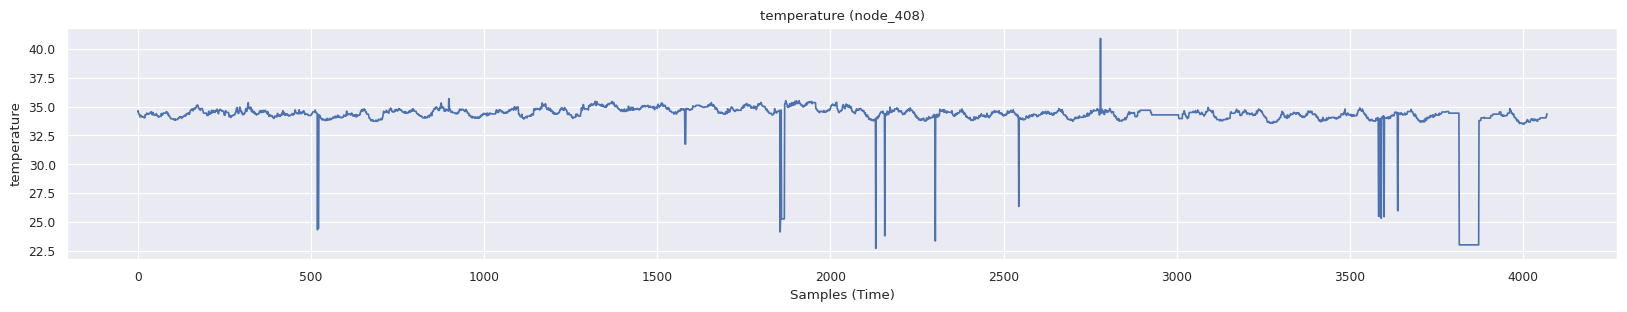

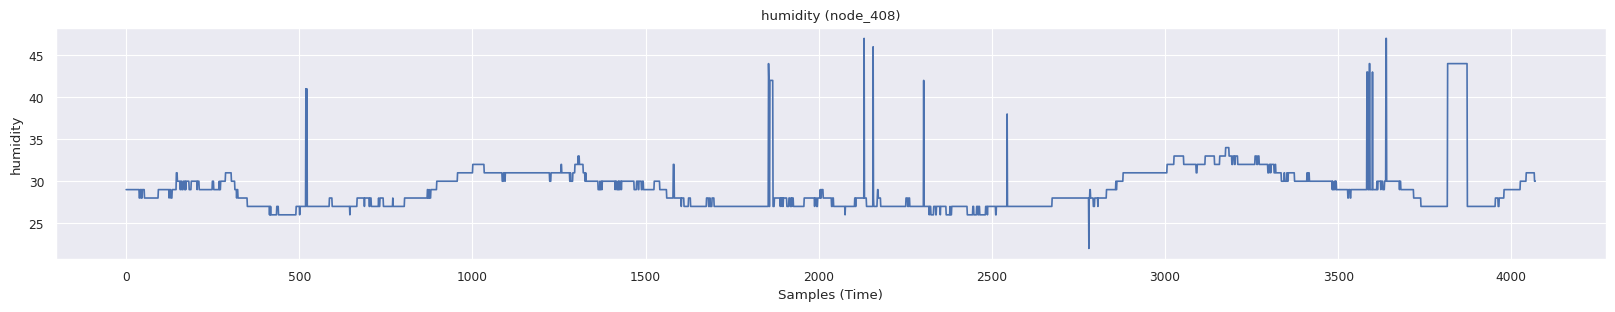

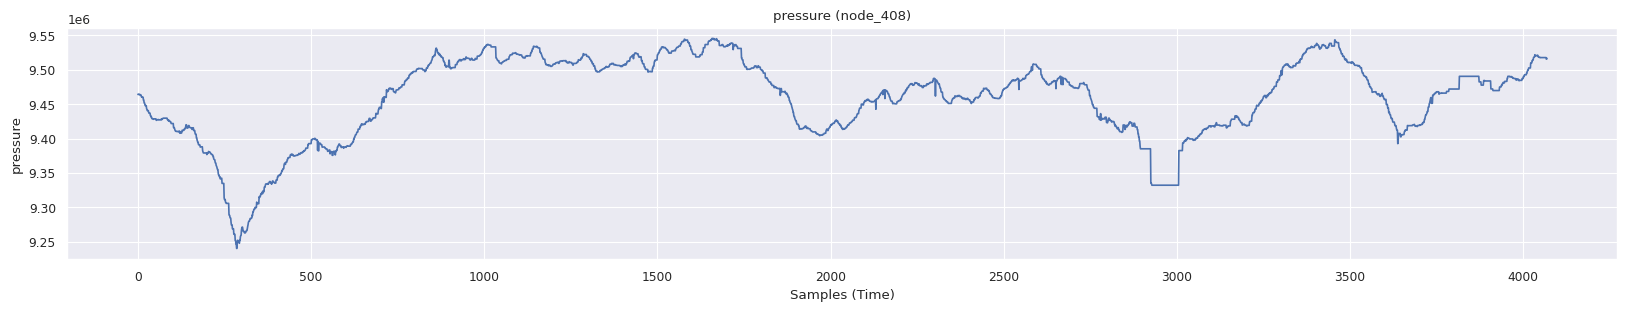




********************************************************************************
*                            ^^^ Sample node 31 ^^^                            *
********************************************************************************





********************************************************************************
*               Sample node nº 48 - Outlet: 1 - Shape: (4070, 6)               *
********************************************************************************




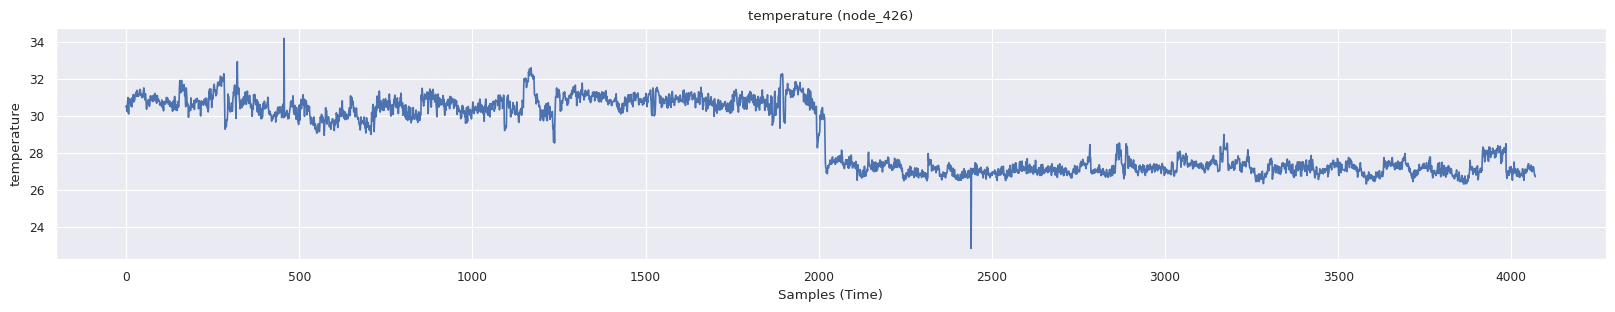

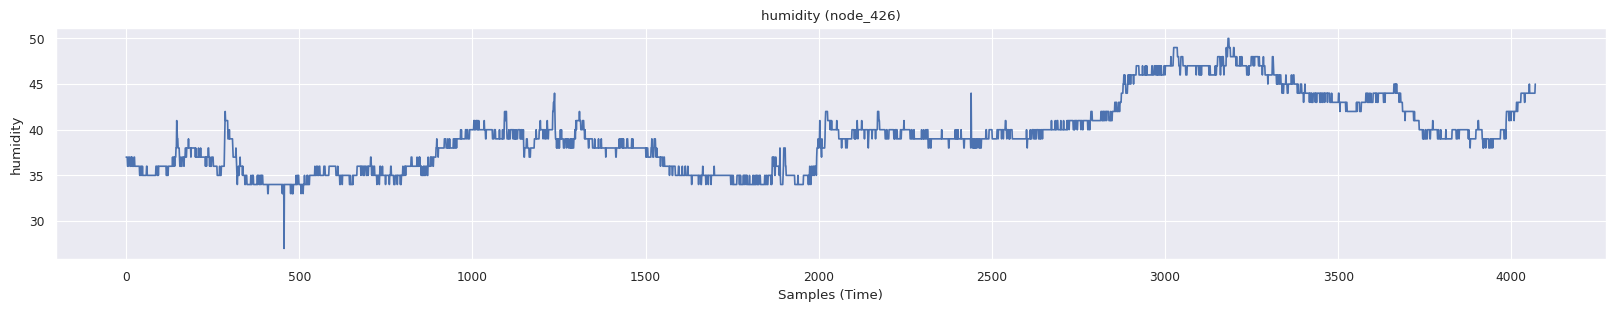

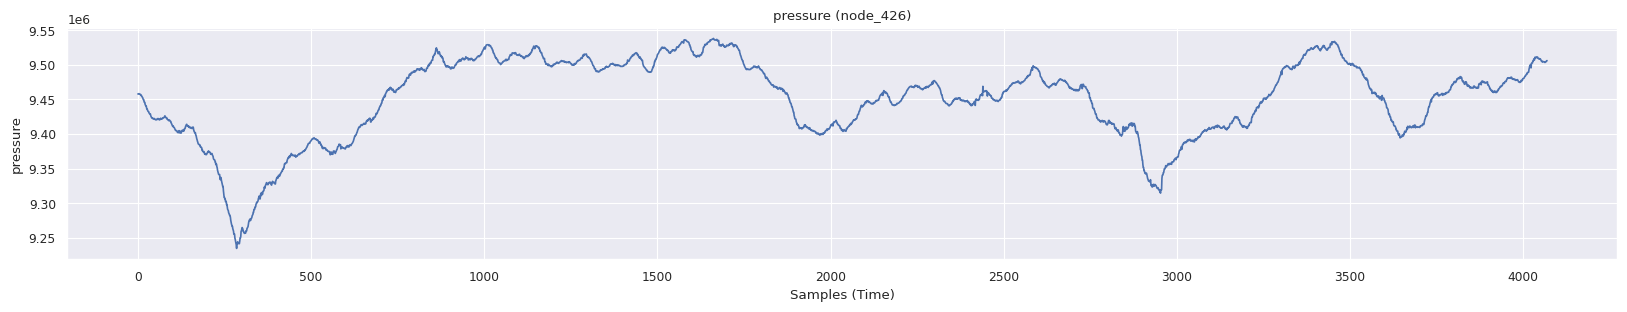




********************************************************************************
*                            ^^^ Sample node 48 ^^^                            *
********************************************************************************





********************************************************************************
*               Sample node nº 19 - Outlet: 1 - Shape: (4070, 6)               *
********************************************************************************




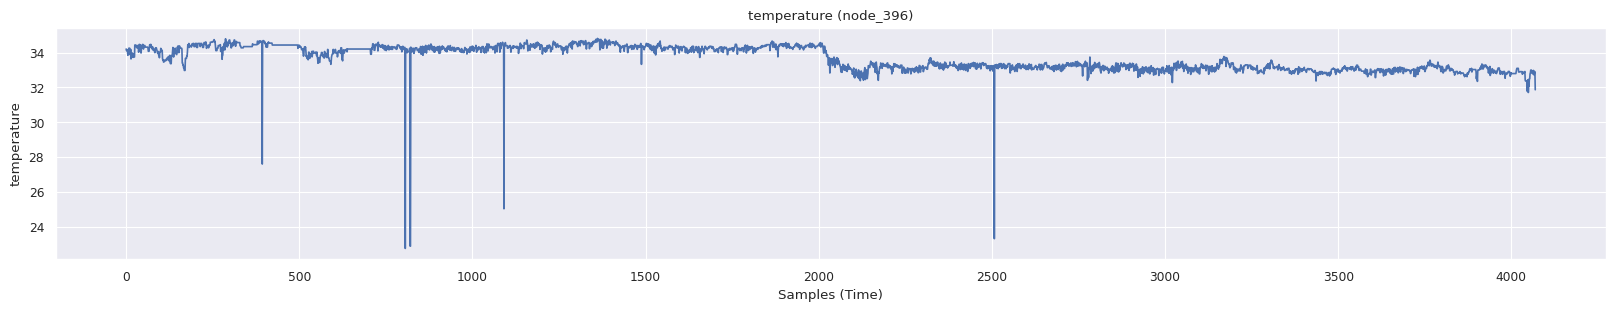

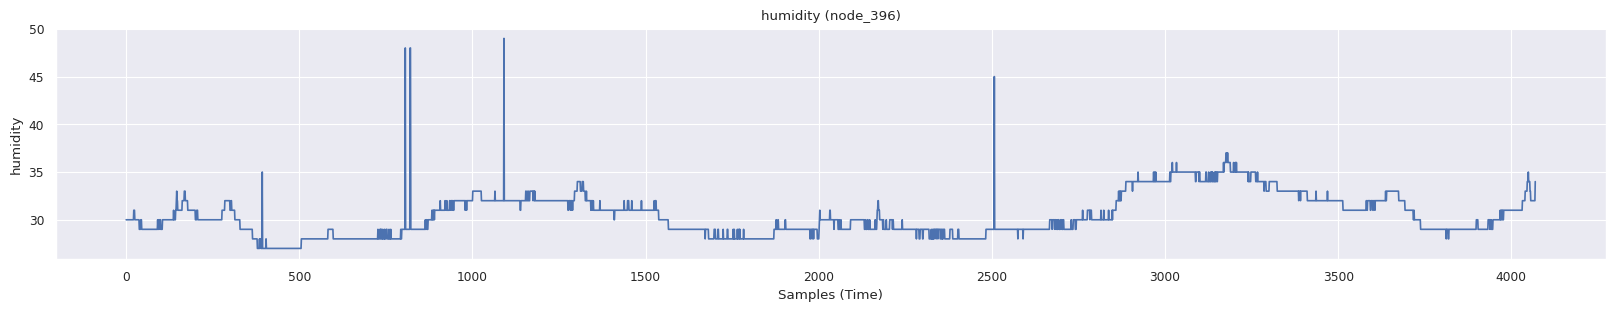

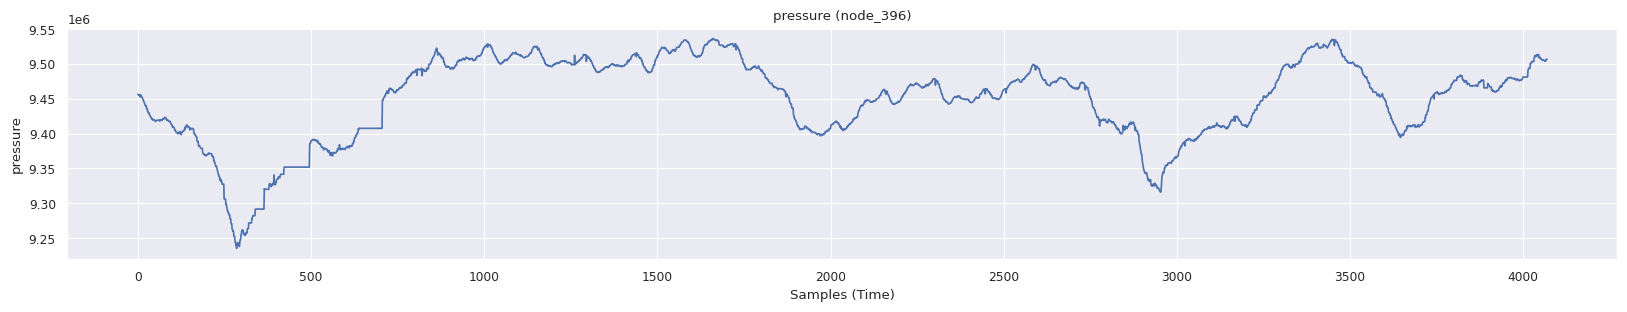




********************************************************************************
*                            ^^^ Sample node 19 ^^^                            *
********************************************************************************




In [21]:
#for j in range(len(groups_sensor)): # Descomentar esta línea si se desea visualizar todos los nodos (ATENCIÓN! LLEVA TIEMPO!!!)
for j in p_num_nodos_random:
    sensor_df = groups_sensor[j].copy()
    headers = list(sensor_df)
    outlet = str(sensor_df['Outlet'].iloc[j])
    name = str(sensor_df['Name'].iloc[j])
    sensor_df.loc[:, 'temperature'] = sensor_df.loc[:, 'temperature'] / 100

    print('\n\n\n********************************************************************************')
    print(f'*               Sample node nº %02d - Outlet: {outlet} - Shape: {sensor_df.shape}               *' % (j))
    print('********************************************************************************\n\n')

    for i in range(3, len(headers)):
        column = str(headers[i])
        fig, ax = plt.subplots(figsize=(20,3))
        ax.set(xlabel='Samples (Time)')
        data = sensor_df[column]
        data = data.reset_index(drop = True)
        sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
        plt.show()

    print('\n\n\n********************************************************************************')
    print('*                            ^^^ Sample node %02d ^^^                            *' % (j))
    print('********************************************************************************\n\n')

## 6.2. Histogramas

In [22]:
all_groups = df_sensor.copy()
all_groups.loc[:, 'temperature'] = all_groups.loc[:, 'temperature'] / 100
all_groups.loc[:, 'pressure'] = all_groups.loc[:, 'pressure'] / 10000
all_groups = all_groups.sort_values(['Name', 'timestamp'])
all_groups = all_groups.reset_index(drop = True)
all_groups

Name     timestamp  Outlet  temperature  humidity  pressure
0       node_376  1.601457e+09       0        36.42        28  947.3322
1       node_376  1.601457e+09       0        36.42        28  947.3322
2       node_376  1.601458e+09       0        32.44        32  946.4555
3       node_376  1.601459e+09       0        32.22        32  946.4560
4       node_376  1.601459e+09       0        32.04        32  946.4209
...          ...           ...     ...          ...       ...       ...
256405  node_441  1.603900e+09       1        28.53        41  951.8915
256406  node_441  1.603901e+09       1        28.53        41  951.8915
256407  node_441  1.603901e+09       1        28.53        41  951.8915
256408  node_441  1.603902e+09       1        28.53        41  951.8915
256409  node_441  1.603902e+09       1        28.53        41  951.8915

[256410 rows x 6 columns]

### Temperatura

La ayuda de la función empleada para pintar el histograma puede consultarse aquí:
https://seaborn.pydata.org/generated/seaborn.histplot.html

En particular se usa "kde = True":

*"If True, compute a kernel density estimate to smooth the distribution and show on the plot as (one or more) line(s). Only relevant with univariate data."*

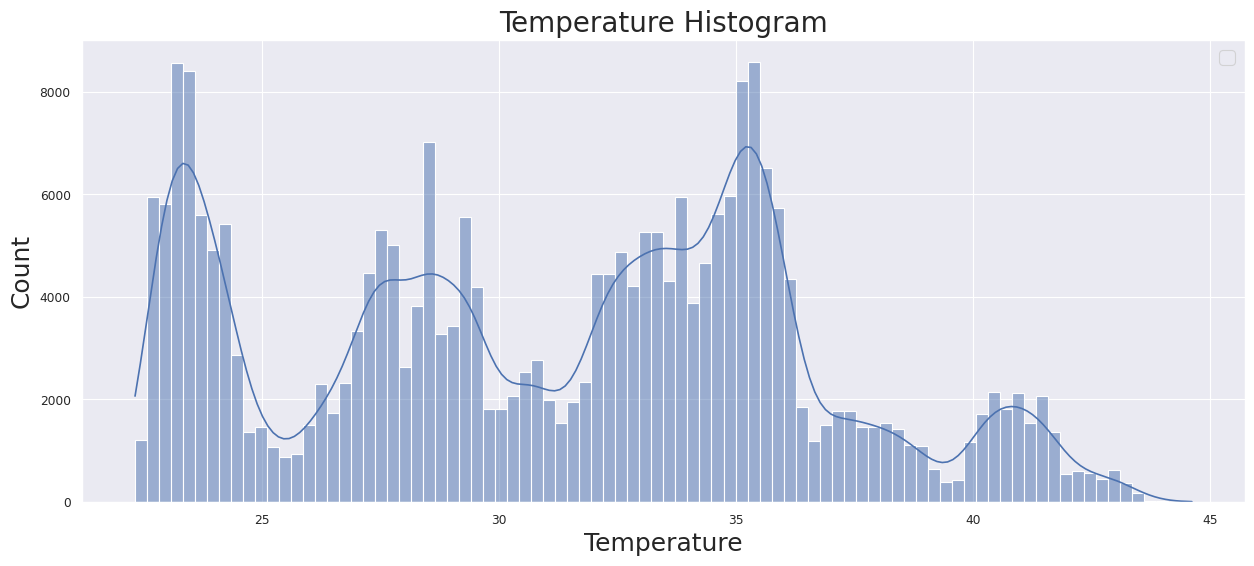

In [23]:
plt.figure(figsize=(15,6))
ax = sns.histplot(all_groups, x='temperature', bins='auto', kde=True, legend=False)
set_size_letters('Temperature Histogram', 'Temperature', 'Count')
sns.set(font_scale = 1.5)

A continuación realizaremos una representación alternativa aprovechando las siguientes propiedades de la función "histplot":

*   **hue**: vector or key in data. Semantic variable that is mapped to determine the color of plot elements.
*   **multiple**: {“layer”, “dodge”, “stack”, “fill”}. Approach to resolving multiple elements when semantic mapping creates subsets. Only relevant with univariate data.

Esta representación nos permitirá observar la contribución individual de cada uno de los nodos (cuyos registros serán representados mediante un color distinto) a dicho histograma.

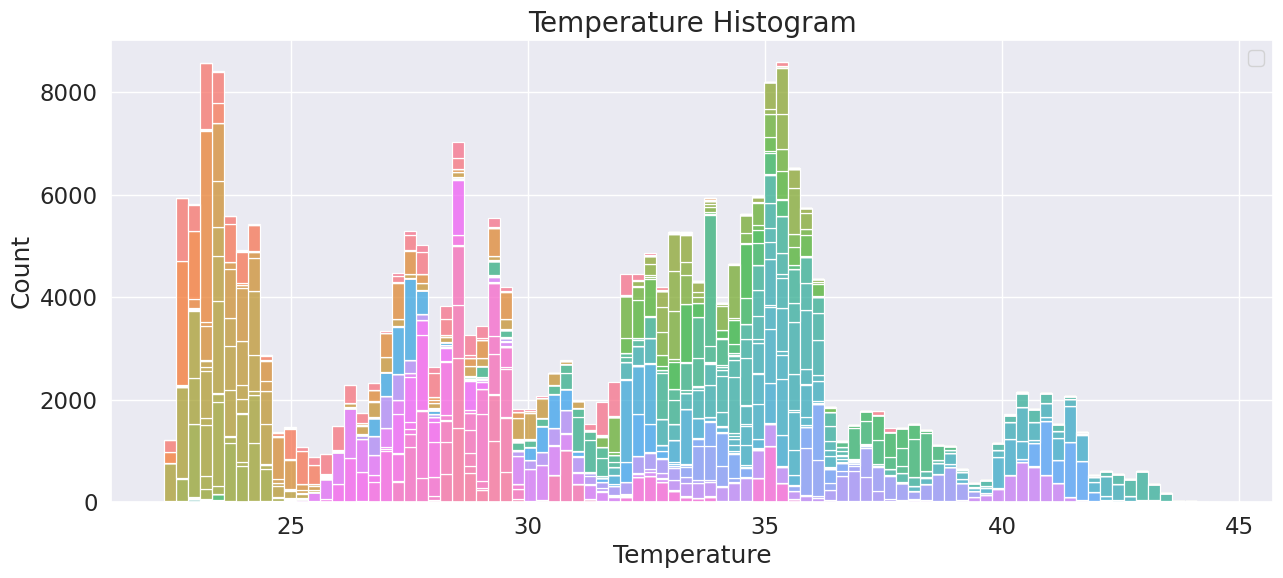

In [24]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='temperature', hue="Name", bins='auto', multiple='stack', legend=False)
set_size_letters('Temperature Histogram', 'Temperature', 'Count')
sns.set(font_scale = 1.5)

Como podemos observar, hay sensores o nodos que sistemáticamente registran temperaturas inferiores (o superiores) al resto. Este resultado tiene todo el sentido del mundo si tenemos en cuenta que una parte de los sensores están colocados en el "pasillo frío" mientras que la otra se encuentran ubicados en el "pasillo caliente". Confirmaremos este resultado en la siguiente gráfica en la que emplearemos el campo "Outlet" para colorear los datos (el campo Outlet sólo puede tomar dos posibles valores: 0 ó 1, dependiendo de la ubicación del sensor en el pasillo frío o caliente respectivamente).

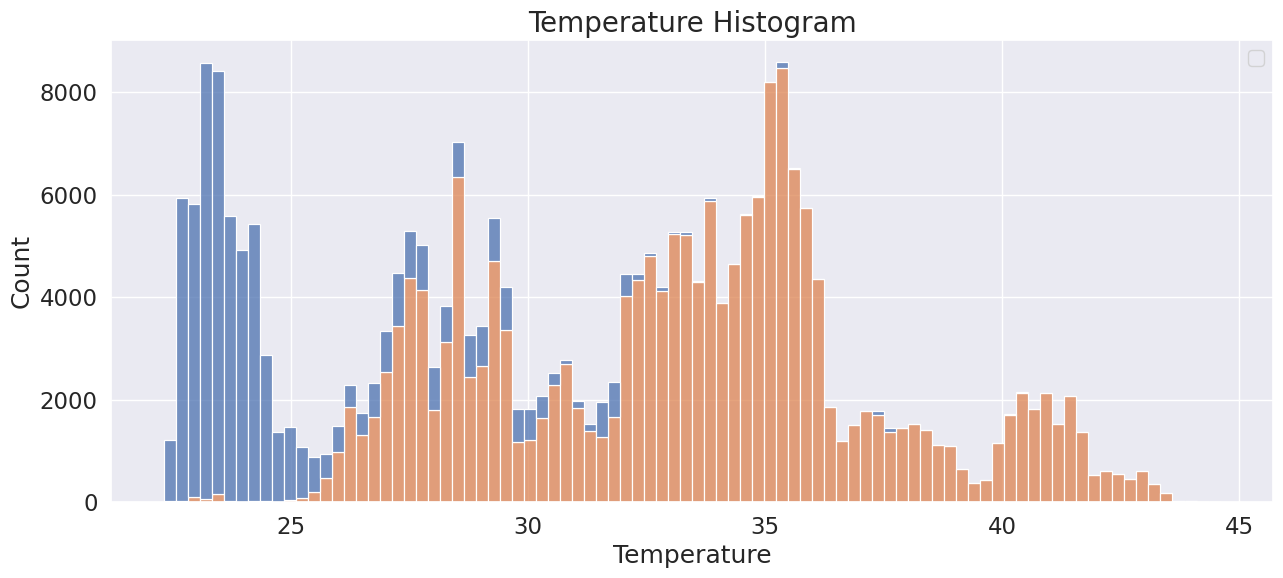

In [25]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='temperature', hue="Outlet", bins='auto', multiple='stack', legend=True)
set_size_letters('Temperature Histogram', 'Temperature', 'Count')
sns.set(font_scale = 1.5)

Como se puede comprobar, en general los sensores en el pasillo caliente registran temperaturas más altas que los sensores en el pasillo frío, como era de esperar. No obstante, llama la atención la existencia de registros en los que los sensores del pasillo frío pueden llegar a alcanzar temperaturas más propias del pasillo caliente y viceversa.

### Humedad

Realizamos el mismo análisis en el caso de la humedad.

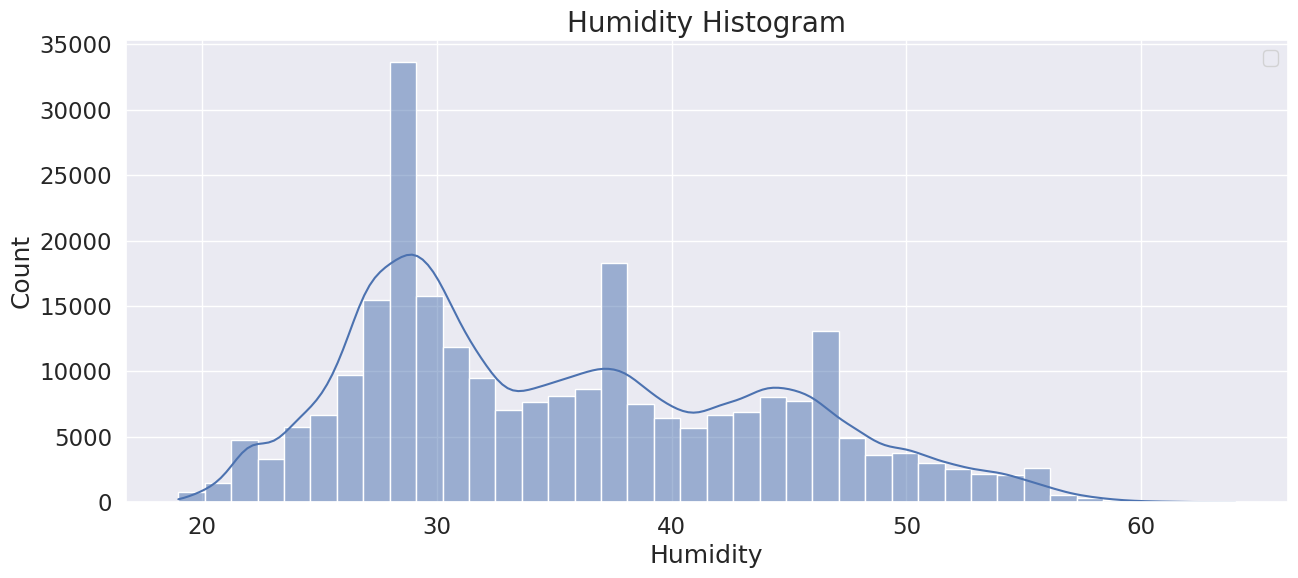

In [26]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='humidity', bins=40, kde=True, legend=False)
set_size_letters('Humidity Histogram', 'Humidity', 'Count')
sns.set(font_scale = 1.5)

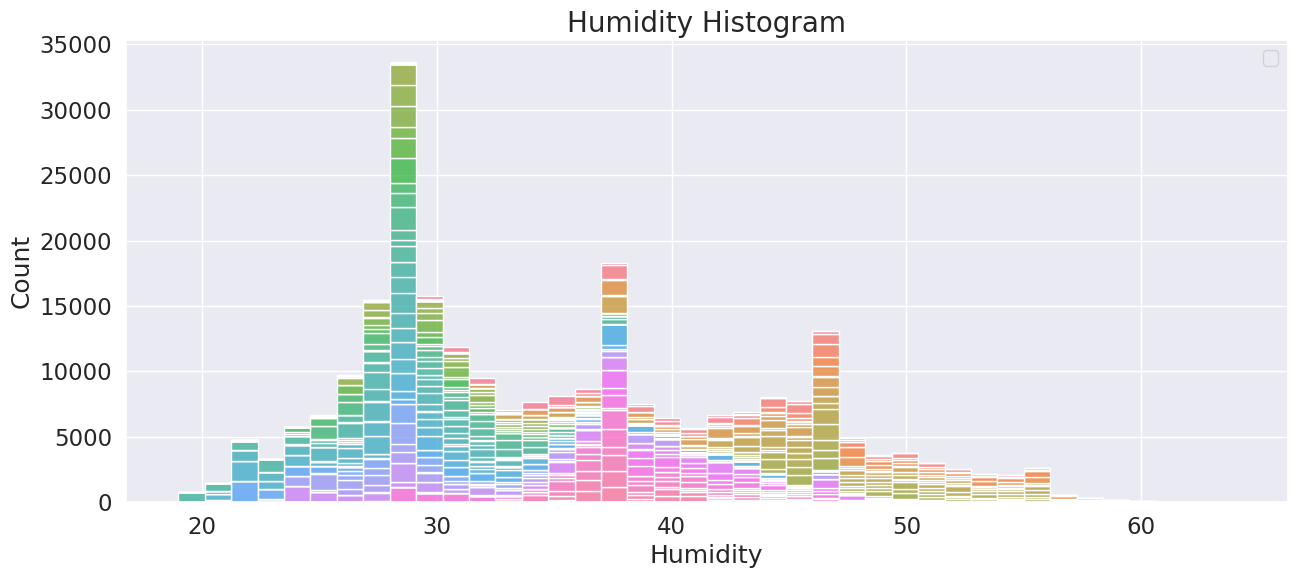

In [27]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='humidity', hue="Name", bins=40, multiple='stack', legend=False)
set_size_letters('Humidity Histogram', 'Humidity', 'Count')
sns.set(font_scale = 1.5)

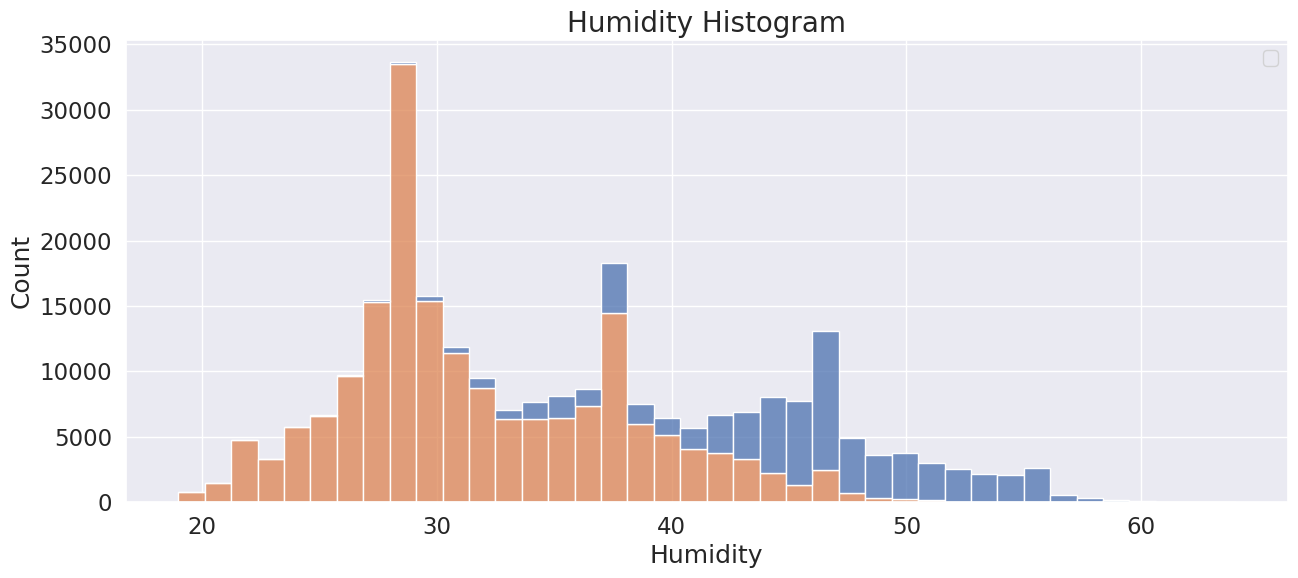

In [28]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='humidity', hue="Outlet", bins=40, multiple='stack', legend=True)
set_size_letters('Humidity Histogram', 'Humidity', 'Count')
sns.set(font_scale = 1.5)

### Presión

Y finalmente también en el caso de la presión.

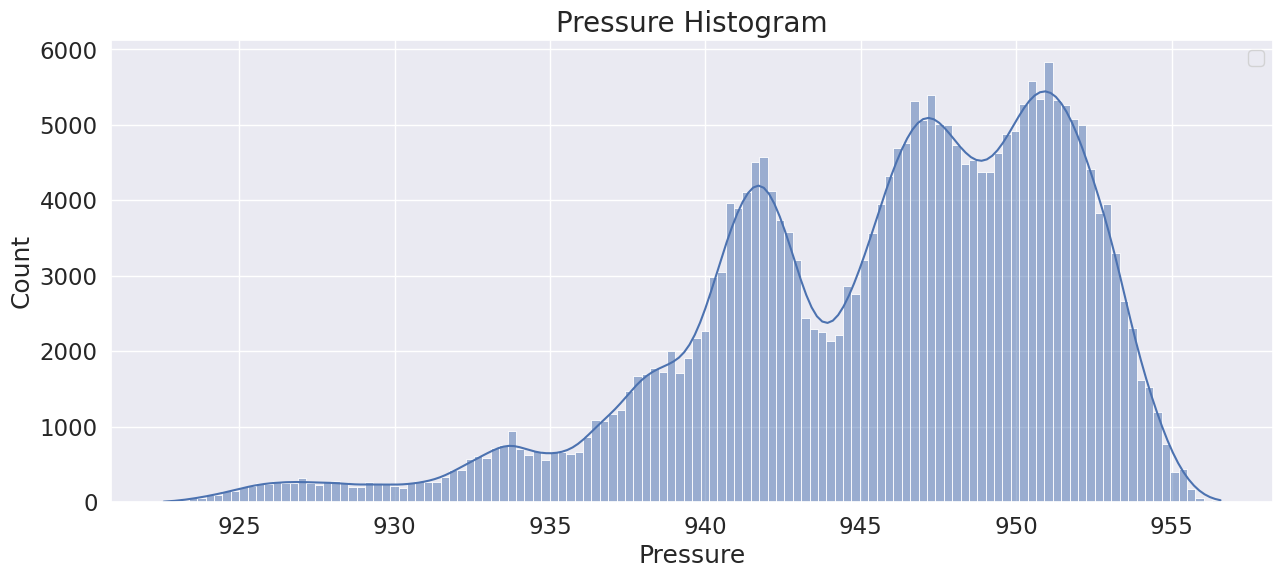

In [29]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='pressure', bins='auto', kde=True, legend=False)
set_size_letters('Pressure Histogram', 'Pressure', 'Count')
sns.set(font_scale = 1.5)

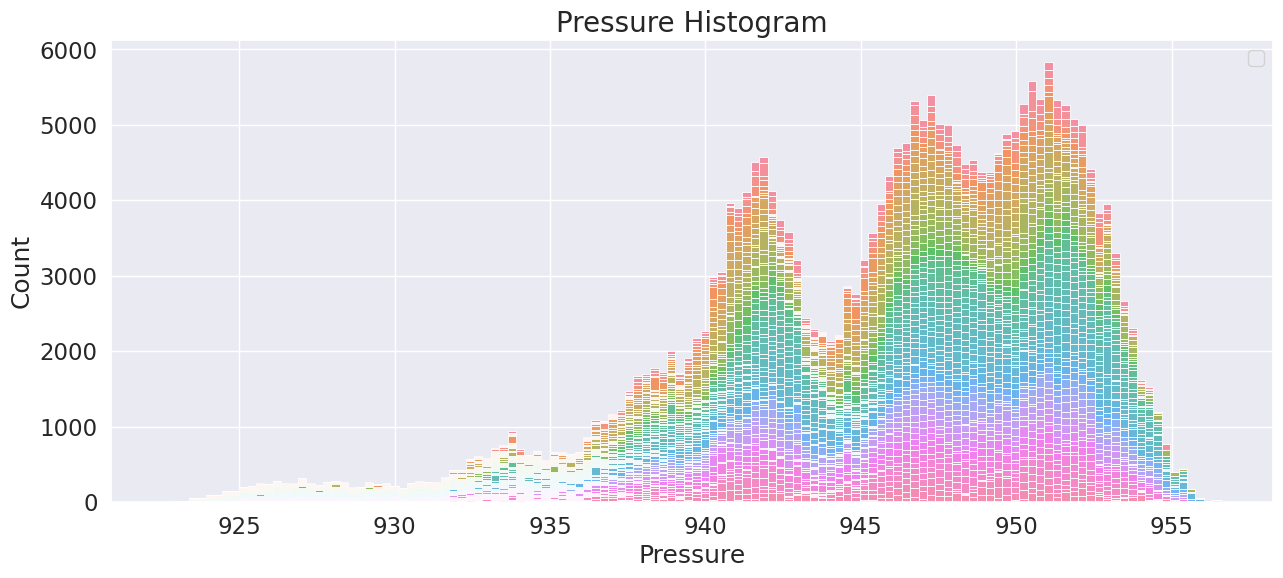

In [30]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='pressure', hue="Name", bins='auto', multiple='stack', legend=False)
set_size_letters('Pressure Histogram', 'Pressure', 'Count')
sns.set(font_scale = 1.5)

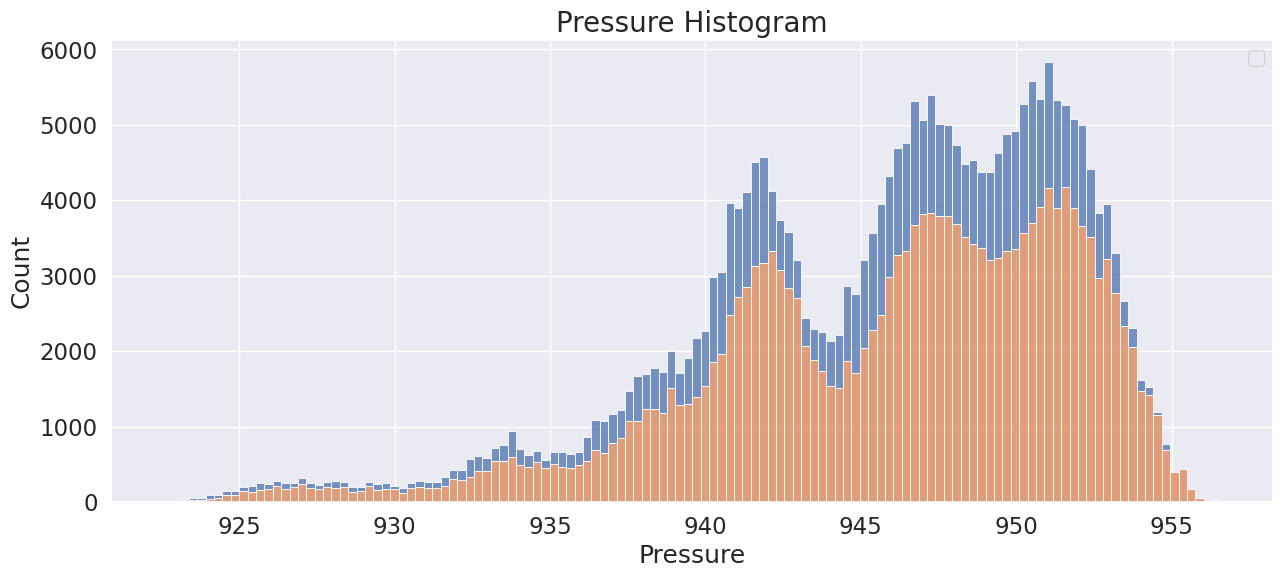

In [31]:
plt.figure(figsize=(15,6))
sns.histplot(all_groups, x='pressure', hue="Outlet", bins='auto', multiple='stack', legend=True)
set_size_letters('Pressure Histogram', 'Pressure', 'Count')
sns.set(font_scale = 1.5)

## 6.3. Análisis de correlación

La idea aquí es crear una tabla (i.e. dataframe) en la que disponemos los registros de cada nodo en diferentes columnas. A su vez, las lecturas de cada columna (correspondientes al mismo nodo) están ordenadas según el instante de su obtención (i.e. timestamp). La siguiente figura muestra el tipo de tabla al que nos referimos.

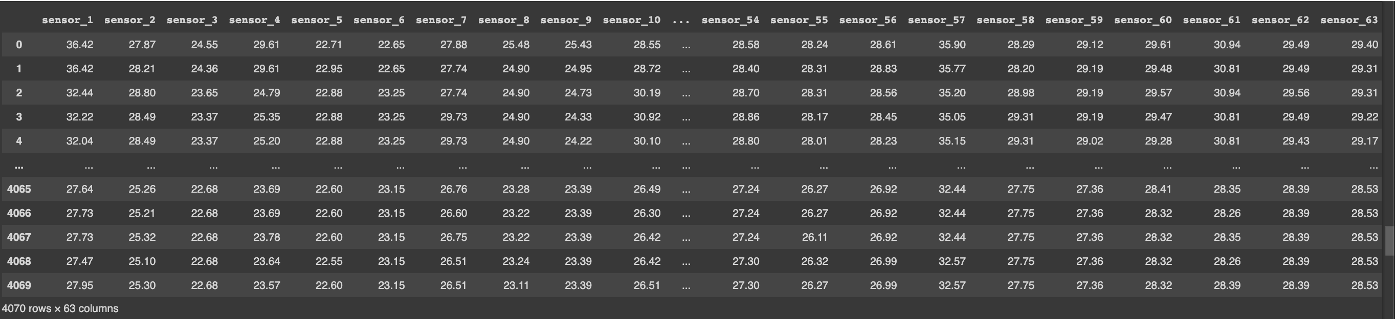

Text(0.5, 1.0, 'Correlación entre sensores de temperatura')

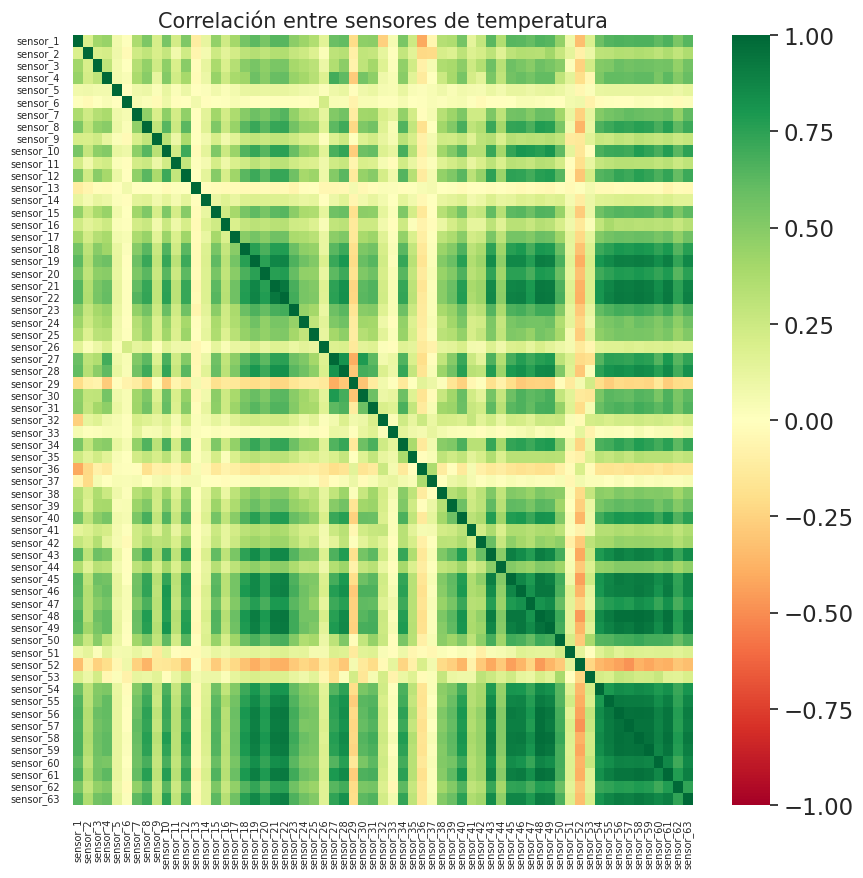

In [32]:
corr_df_temp = pd.DataFrame()
for i in range(len(groups_sensor)):
  sensor_map = groups_sensor[i] # Aprovechamos que los datos en groups_sensor están ordenados por sensor y por timestamp
  data = np.array(sensor_map.drop(columns=['Name']))
  data_temp = data[:,2]
  name = 'sensor_'+str(i+1)
  corr_df_temp[name]=data_temp
corr_df_temp.loc[:, :] = corr_df_temp.loc[:, :] / 100
plt.figure(figsize=(10,10))
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.heatmap(corr_df_temp.corr(), vmin=-1, vmax=1, xticklabels=1, yticklabels=1, cmap='RdYlGn', annot=False, linewidths=0).set_title('Correlación entre sensores de temperatura', fontsize=15)

### **[Ejercicio 1]**
Complete en el siguiente bloque el código necesario para generar una figura similar a la anterior pero en este caso para la humedad y para la presión.

In [33]:
# Teclee su código aquí para el caso de la humedad


In [34]:
# Teclee su código aquí para el caso de la presión

## 6.4. Representaciones 1 vs 1
**¡ATENCIÓN! ¡Representaciones "PESADAS"! (>10 minutos cada una)**

### **Temperatura vs Humedad**
Se adjunta la siguiente figura a modo de backup o contingencia en caso de que el tiempo de ejecución resulte excesivo.
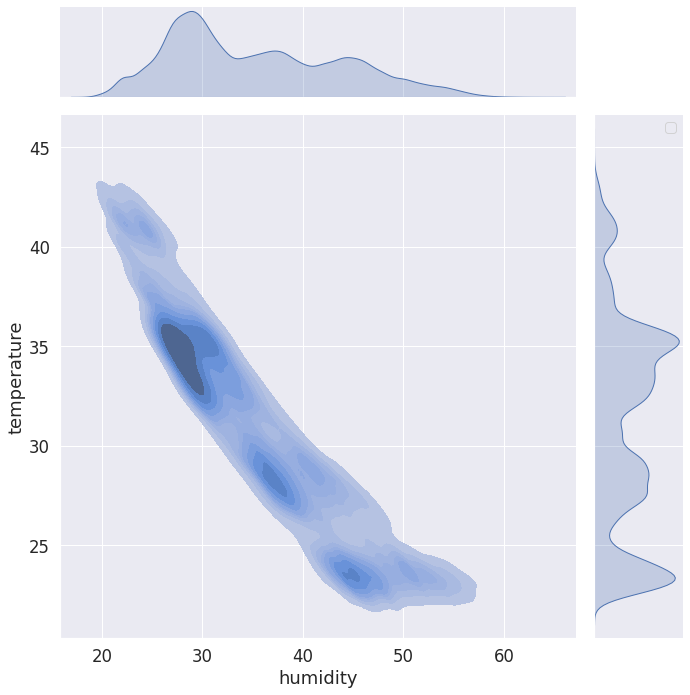

En este caso aprovecharemos la función "**joinplot**" de la librería Seaborn. Se puede consultar la documentación de dicha función aquí:
https://seaborn.pydata.org/generated/seaborn.jointplot.html

Esta función nos permite mostrar un gráfico con la función de distribución de ambas variables objeto de análisis, así como también un histograma adicional para cada una de ellas.

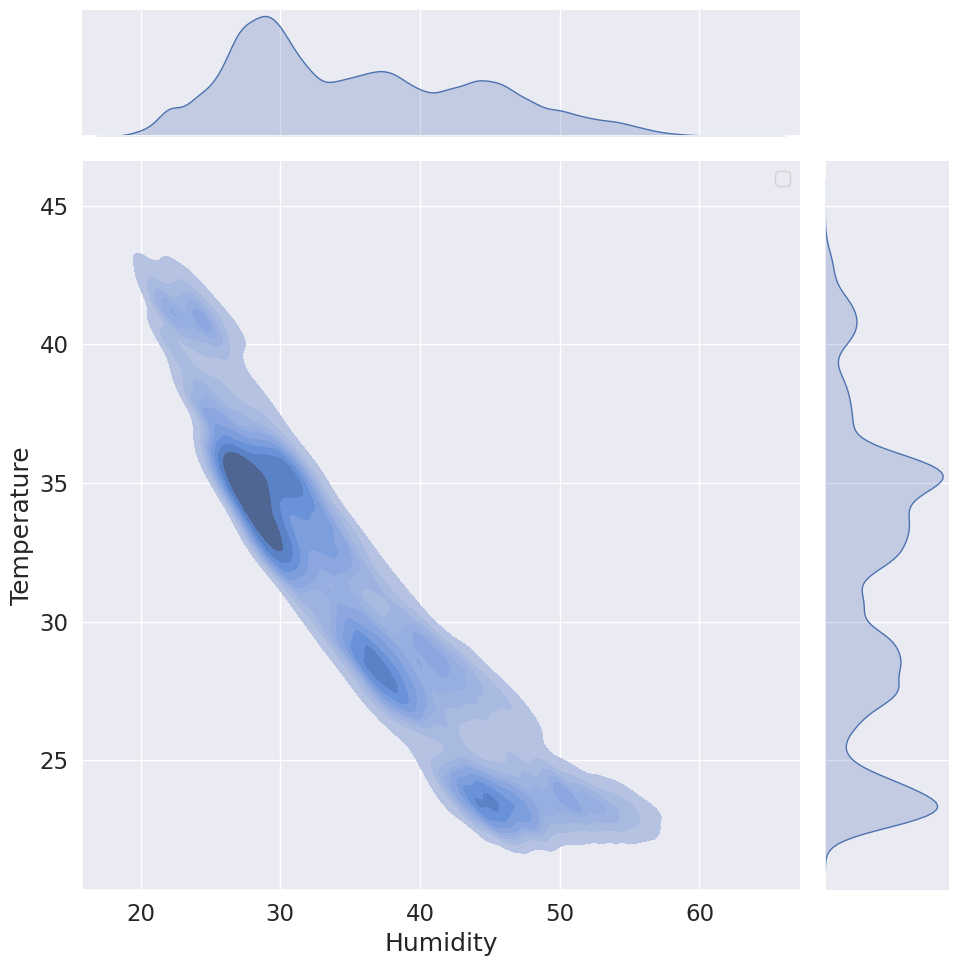

In [35]:
sns.jointplot(data=all_groups, x='humidity', y='temperature', kind='kde', height=10, fill=True)
set_size_letters(' ', 'Humidity', 'Temperature')
sns.set(font_scale = 1.5)

### **Temperatura vs Presión**
Seguimos un procedimiento similar y volvemos a adjuntar la siguiente figura a modo de backup o contingencia en caso de que el tiempo de ejecución resulte excesivo.

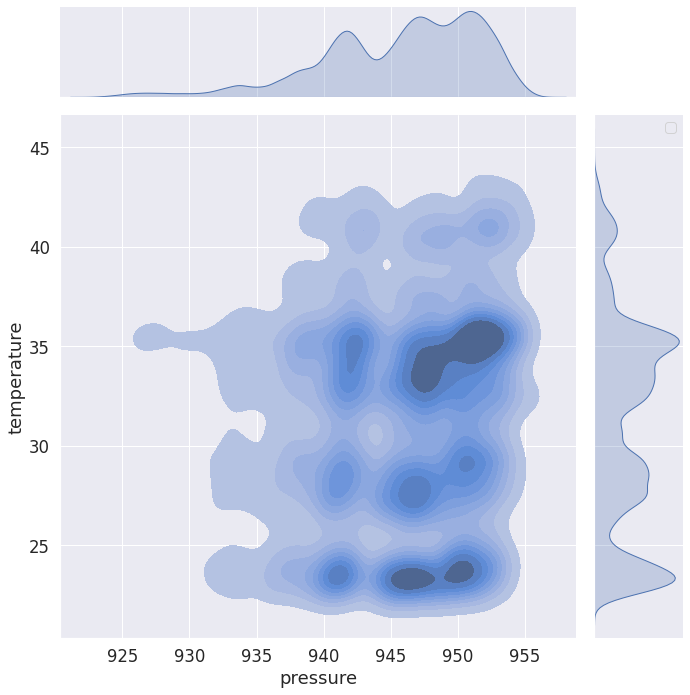

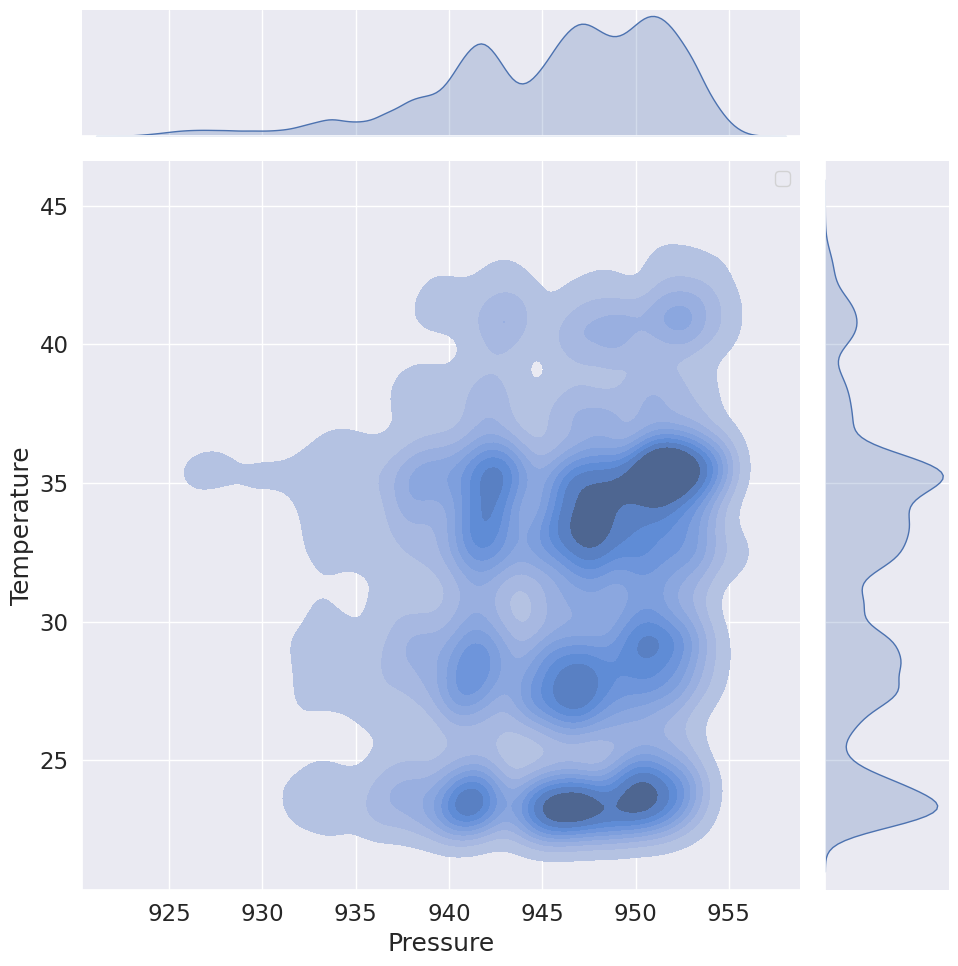

In [36]:
sns.jointplot(data=all_groups, x='pressure', y='temperature',  kind='kde', height=10, fill=True)
set_size_letters(' ', 'Pressure', 'Temperature')
sns.set(font_scale = 1.5)

### **Humedad vs Presión**
Seguimos un procedimiento similar y volvemos a adjuntar la siguiente figura a modo de backup o contingencia en caso de que el tiempo de ejecución resulte excesivo.

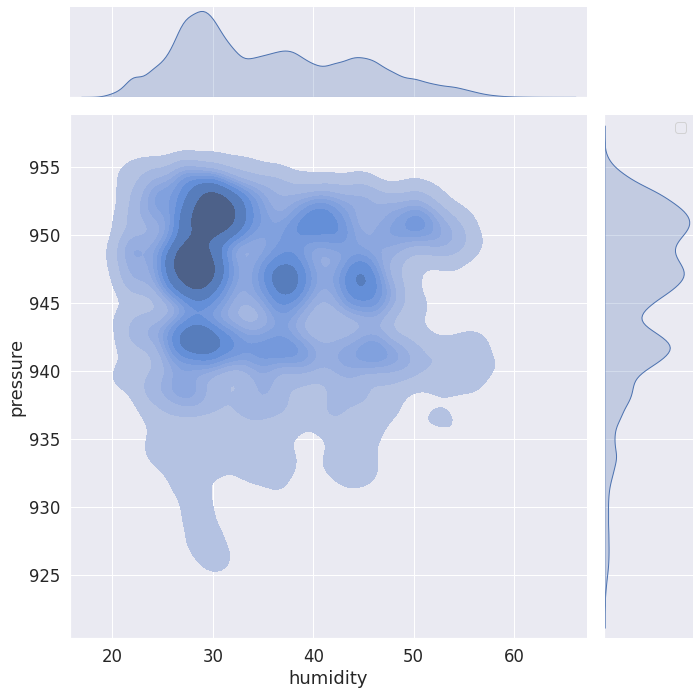

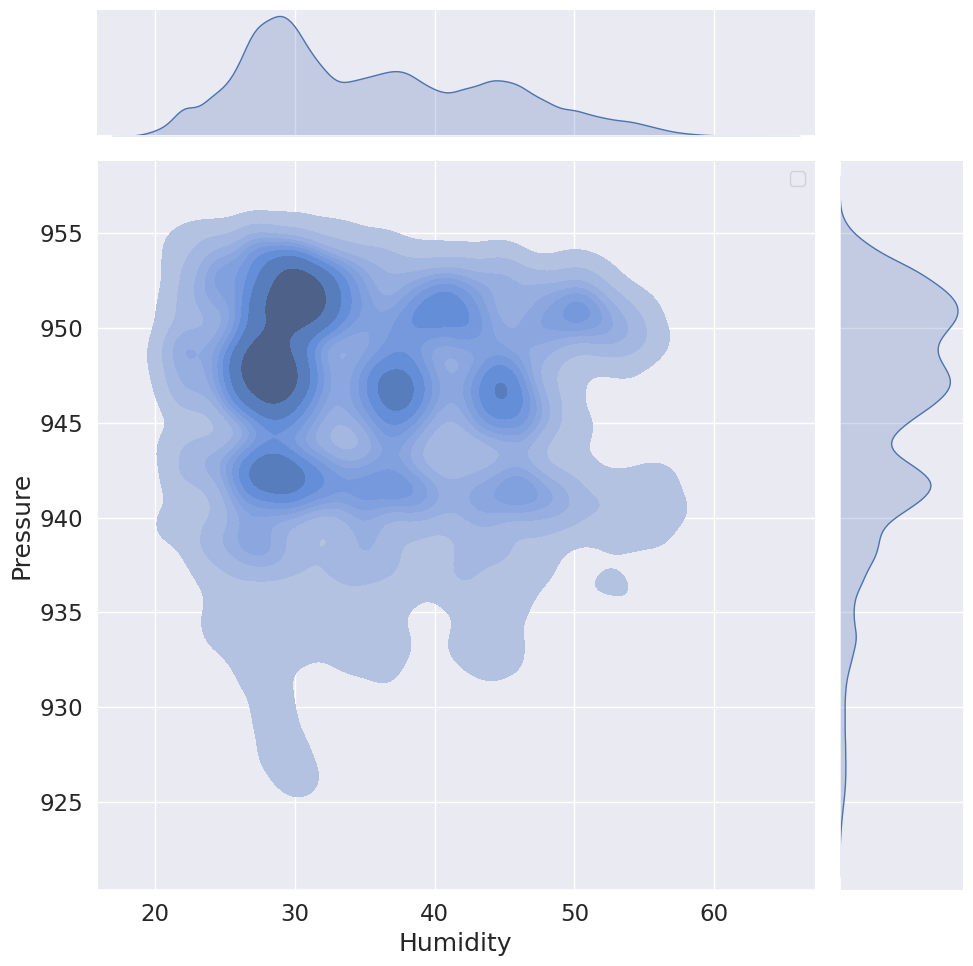

In [37]:
sns.jointplot(data=all_groups, x='humidity', y='pressure',  kind='kde', height=10, fill=True)
set_size_letters(' ', 'Humidity', 'Pressure')
sns.set(font_scale = 1.5)

## Puntos raros


Sensor nº 0 - node_376 - outlet : 0 - Shape: (4070, 6)


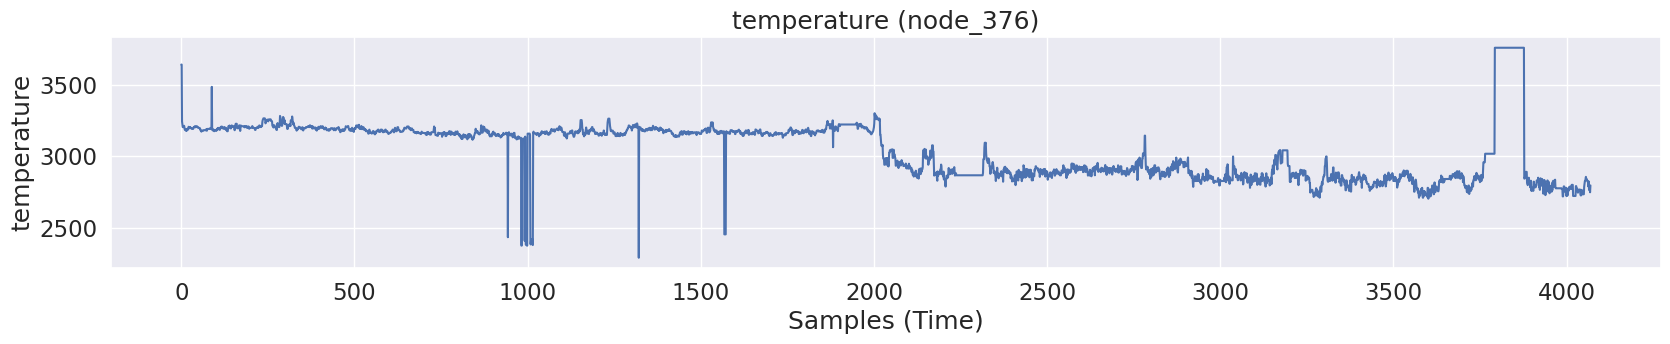

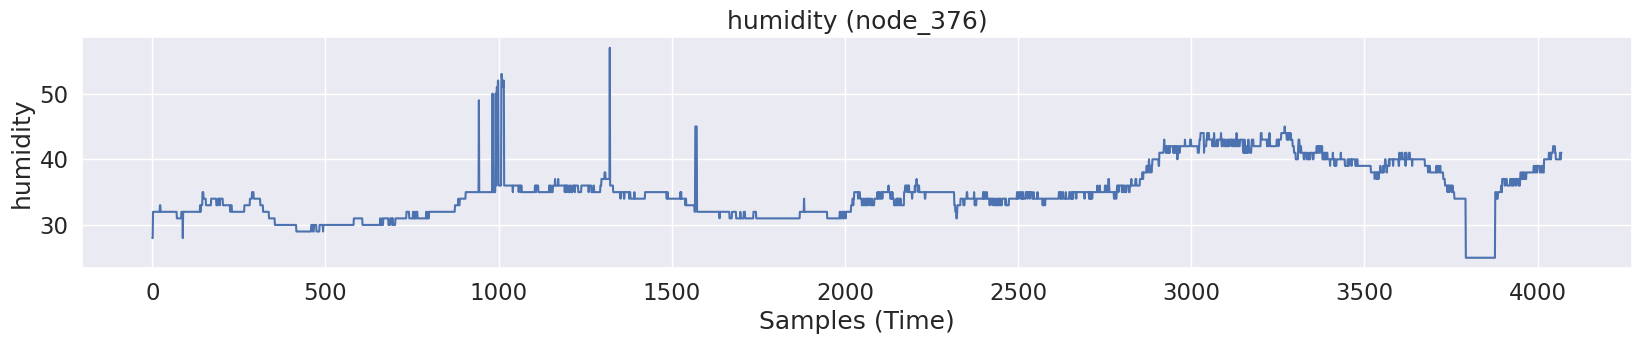

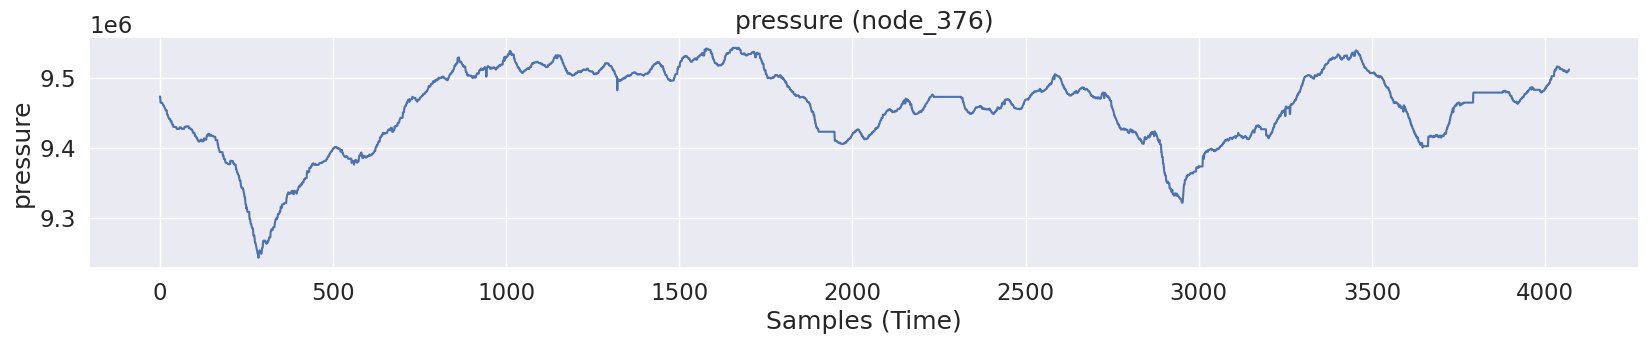




*******************************************
*******************************************
*******************************************



Zoom -> init: 3700, max_ 4000


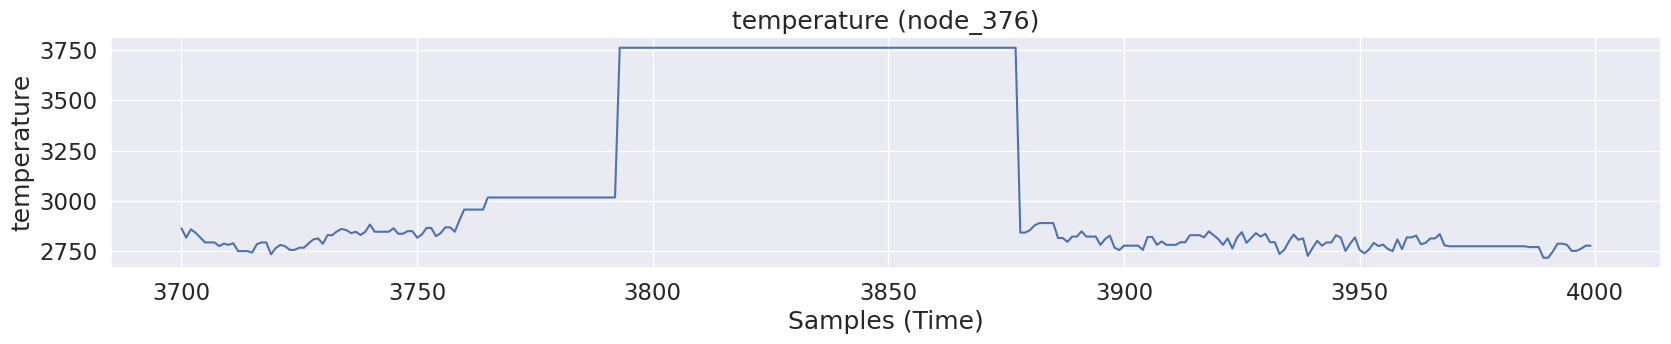

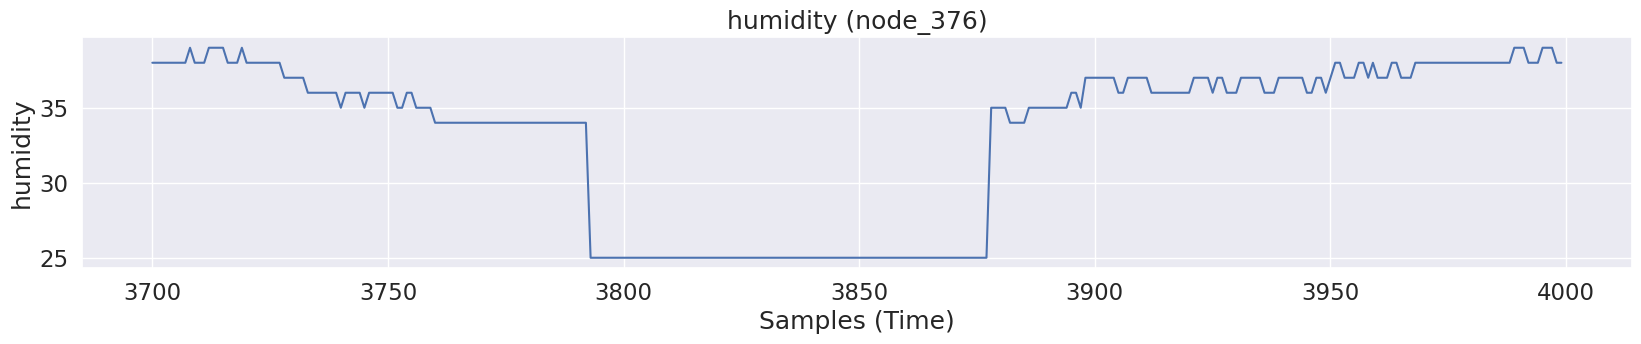

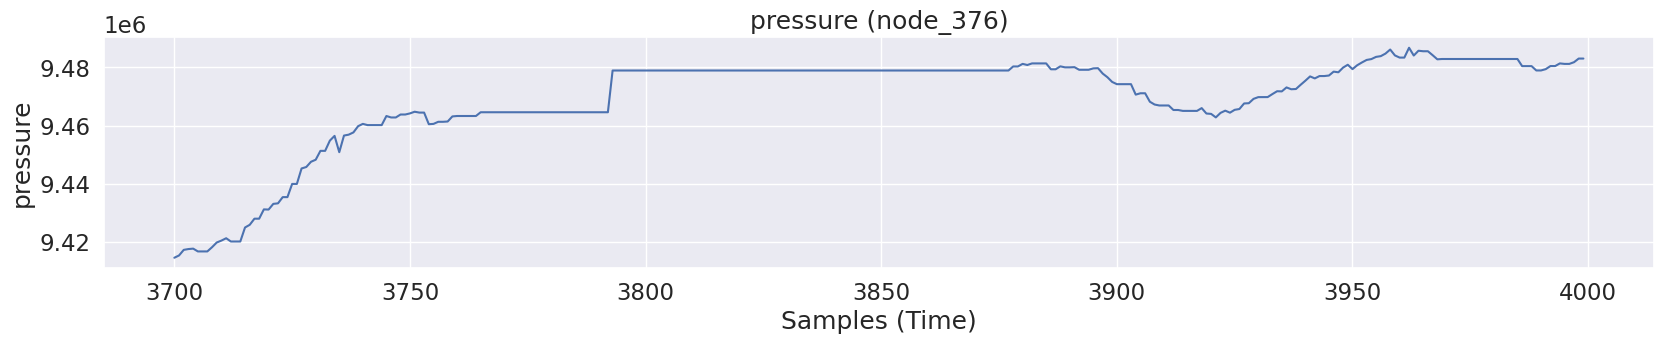

In [38]:
selected_sensor = 0

sensor_df = groups_sensor[selected_sensor]
headers = list(sensor_df)
outlet = str(sensor_df['Outlet'].iloc[selected_sensor])
name = str(sensor_df['Name'].iloc[selected_sensor])
print(f'Sensor nº {selected_sensor} - {name} - outlet : {outlet} - Shape: {sensor_df.shape}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()
print('\n\n\n*******************************************')
print('*******************************************')
print('*******************************************\n\n\n')


init = 3700
end = 4000
print(f'Zoom -> init: {init}, max_ {end}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    data = data[init:end]
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()

Sensor nº 23 - node_400 - outlet : 1 - Shape: (4070, 6)


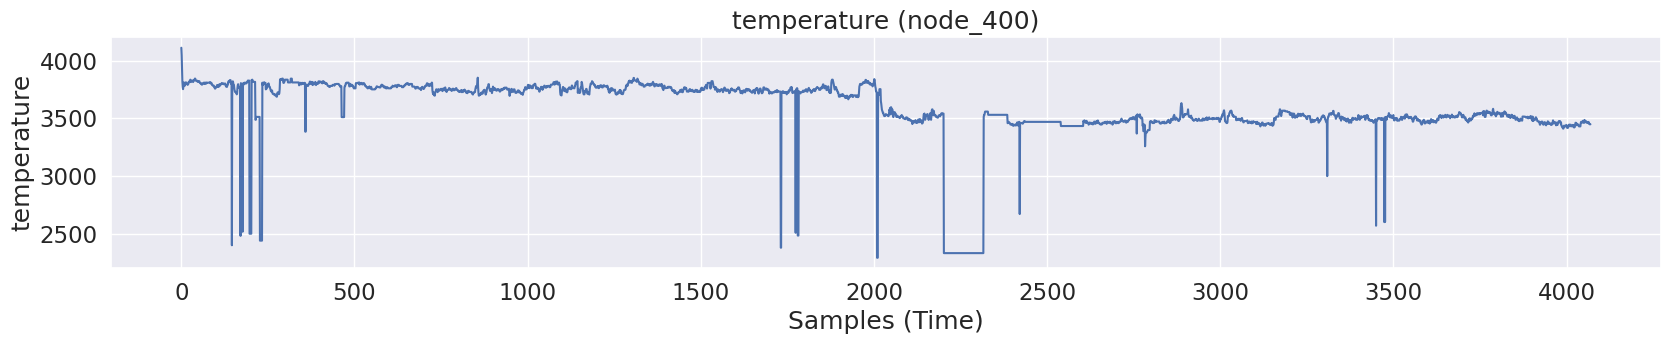

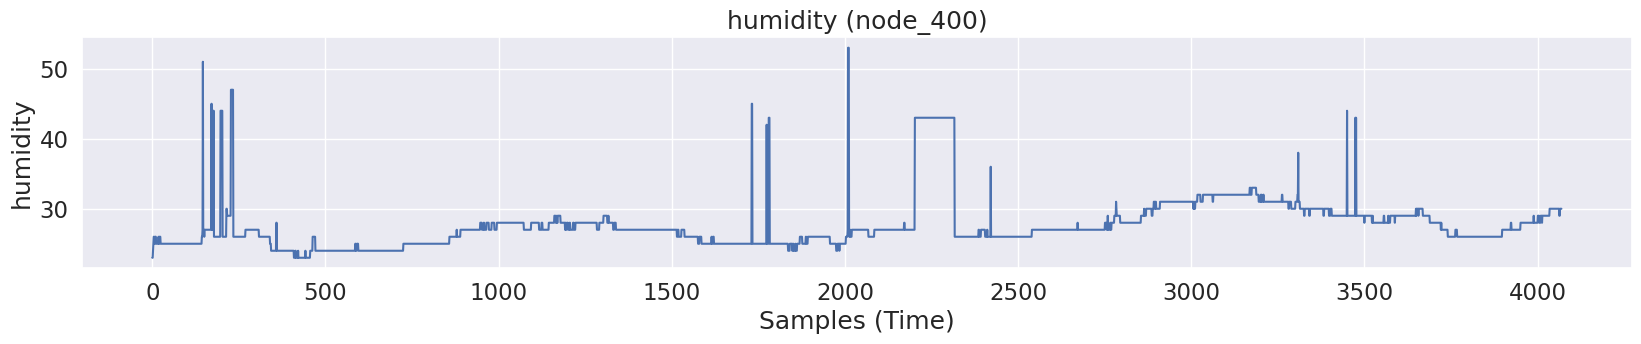

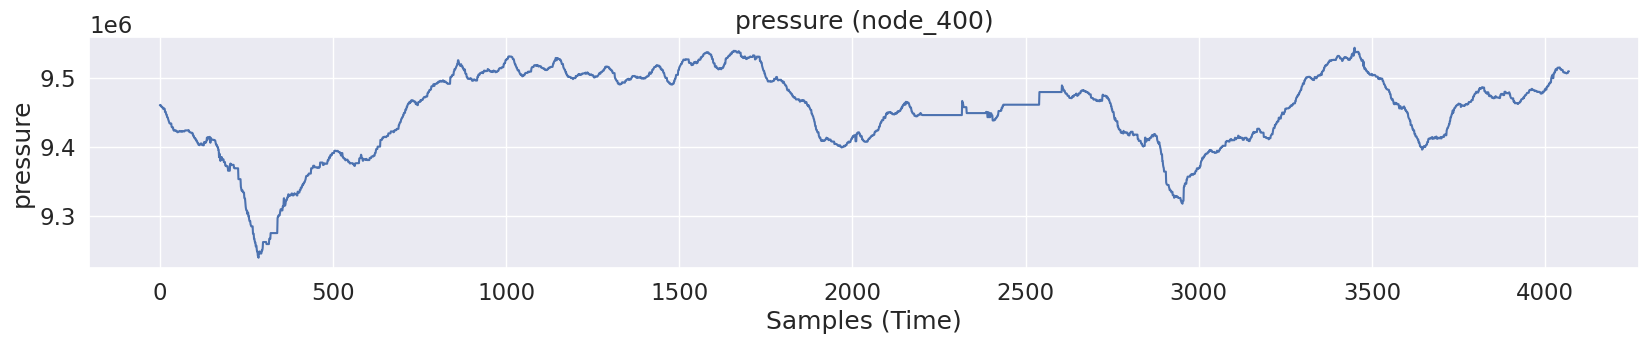




*******************************************
*******************************************
*******************************************



Zoom -> init: 2000, max_ 2500


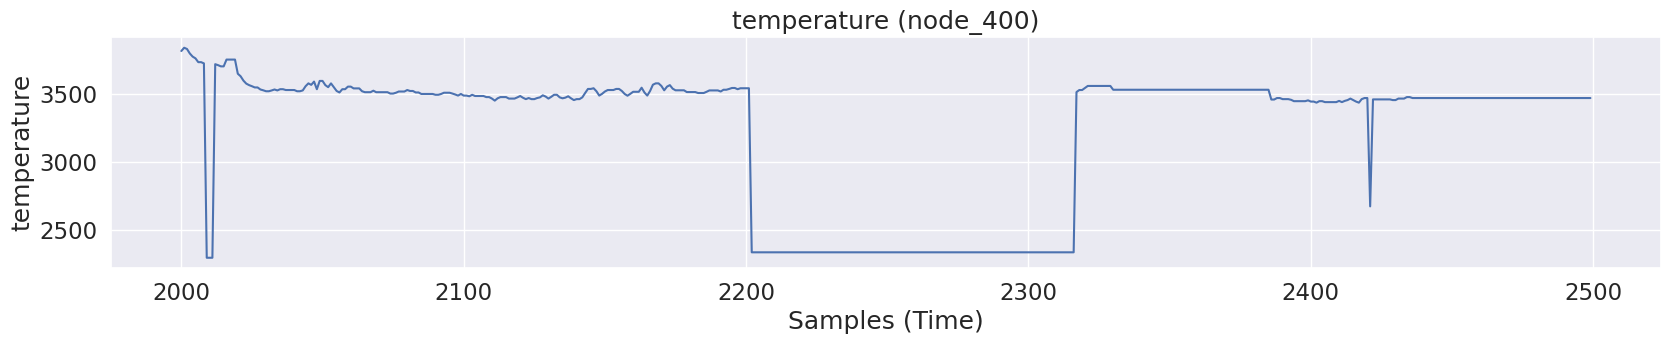

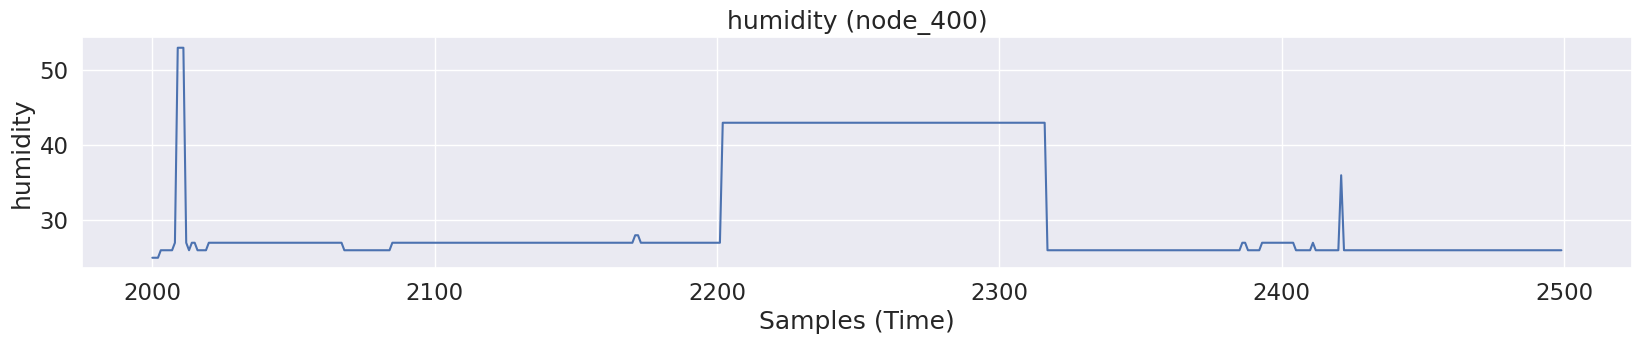

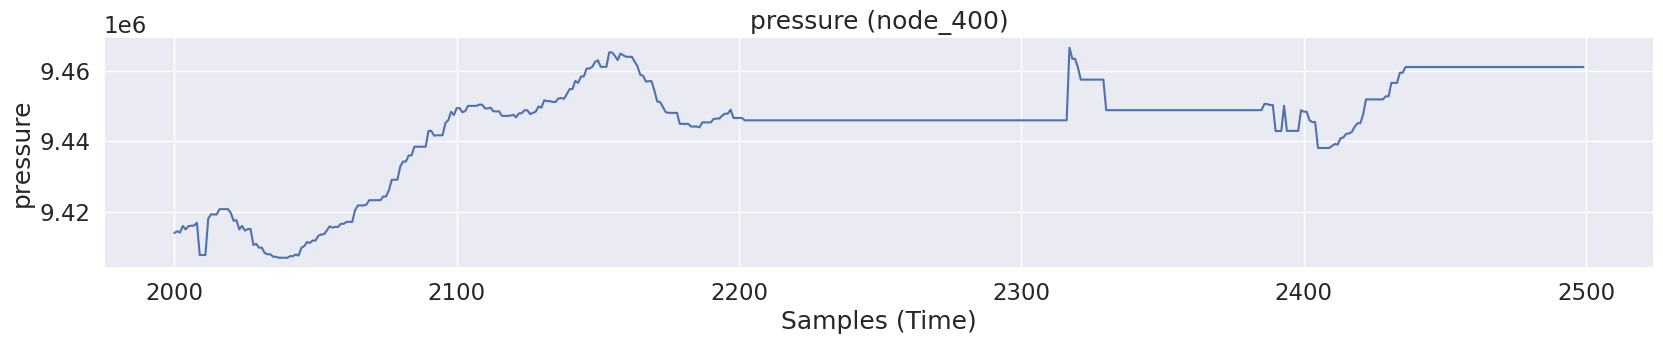

In [39]:
selected_sensor = 23

sensor_df = groups_sensor[selected_sensor]
headers = list(sensor_df)
outlet = str(sensor_df['Outlet'].iloc[selected_sensor])
name = str(sensor_df['Name'].iloc[selected_sensor])
print(f'Sensor nº {selected_sensor} - {name} - outlet : {outlet} - Shape: {sensor_df.shape}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()
print('\n\n\n*******************************************')
print('*******************************************')
print('*******************************************\n\n\n')


init = 2000
end = 2500
print(f'Zoom -> init: {init}, max_ {end}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    data = data[init:end]
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()

Sensor nº 32 - node_409 - outlet : 1 - Shape: (4070, 6)


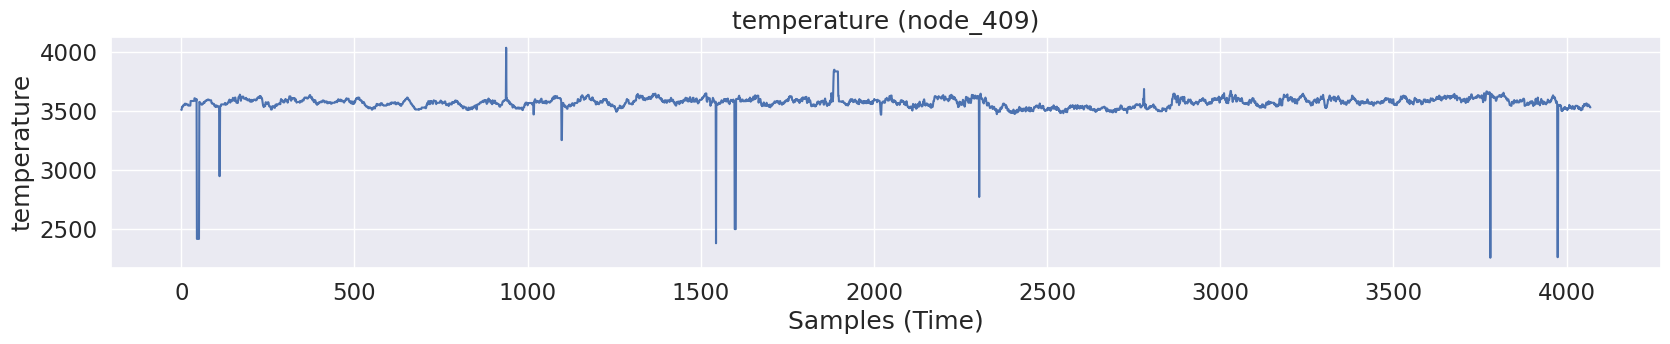

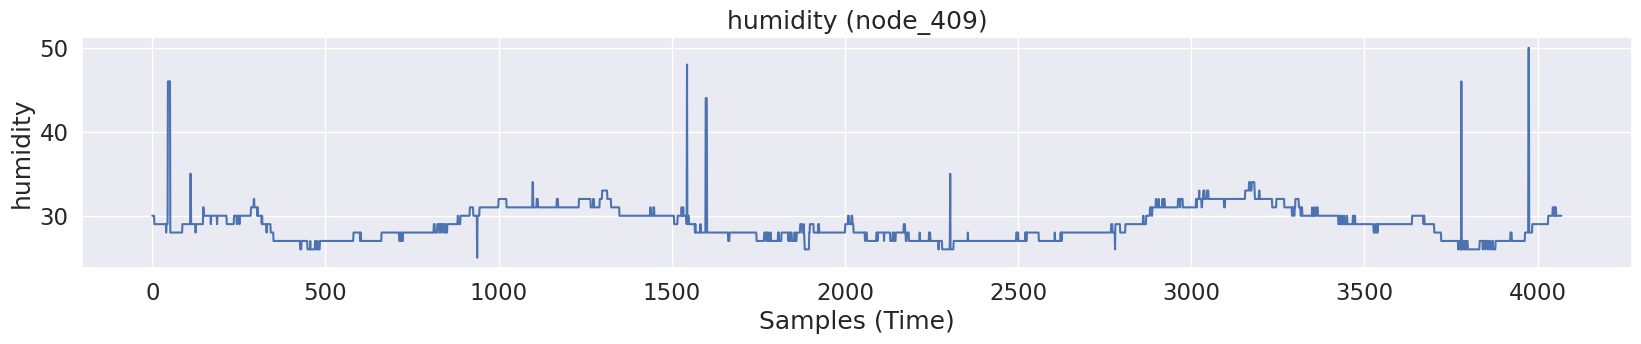

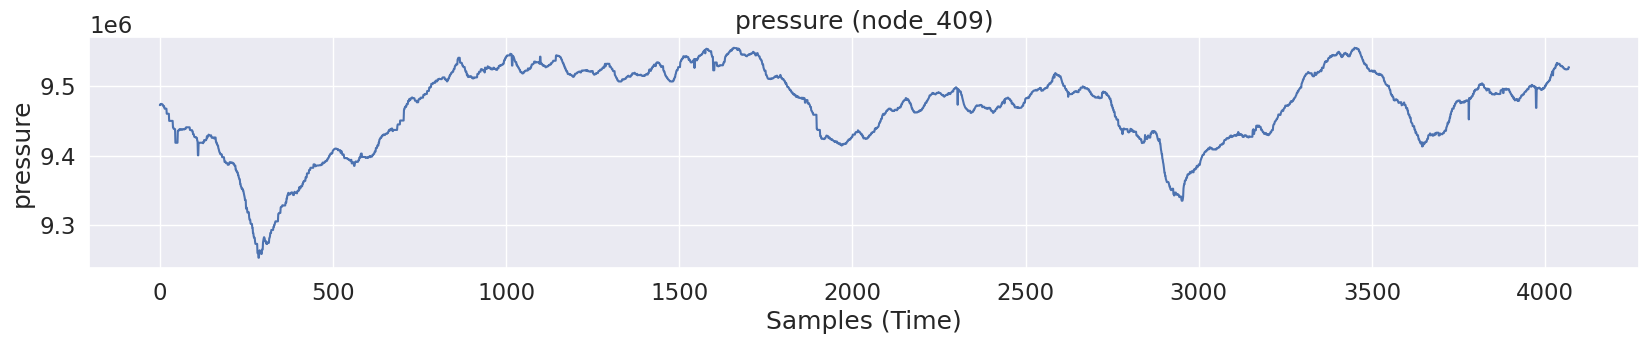




*******************************************
*******************************************
*******************************************



Zoom -> init: 1540, max_ 1620


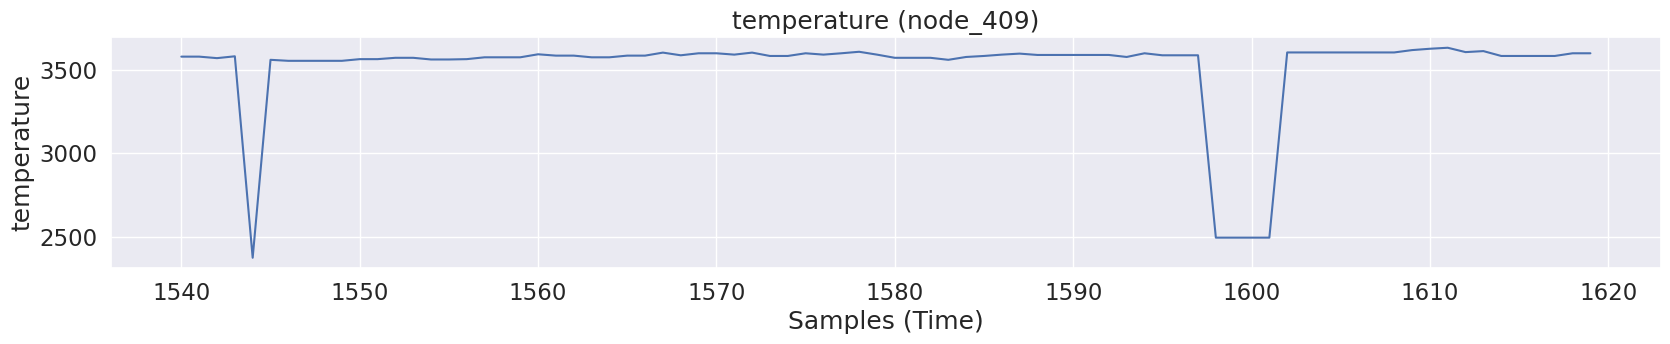

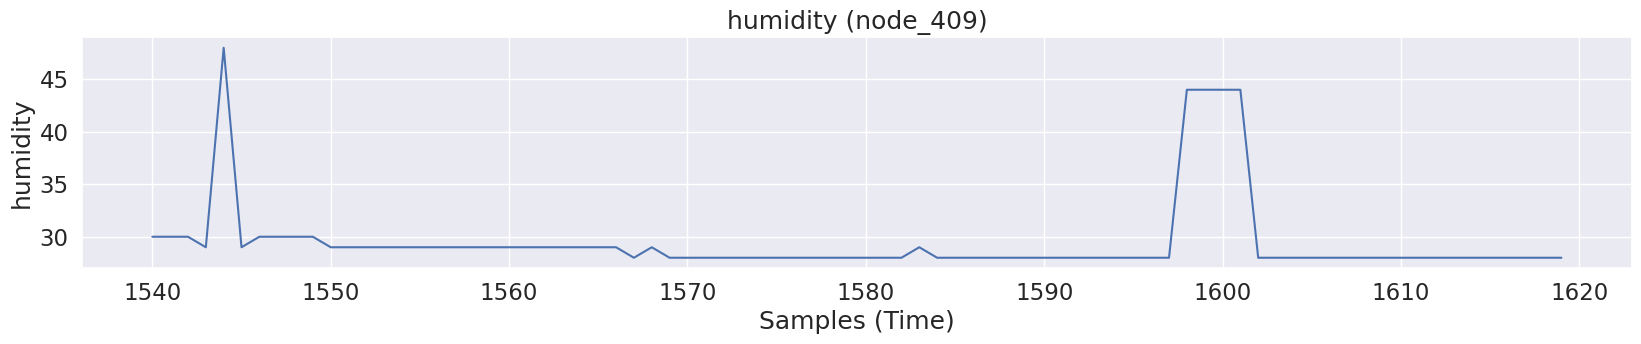

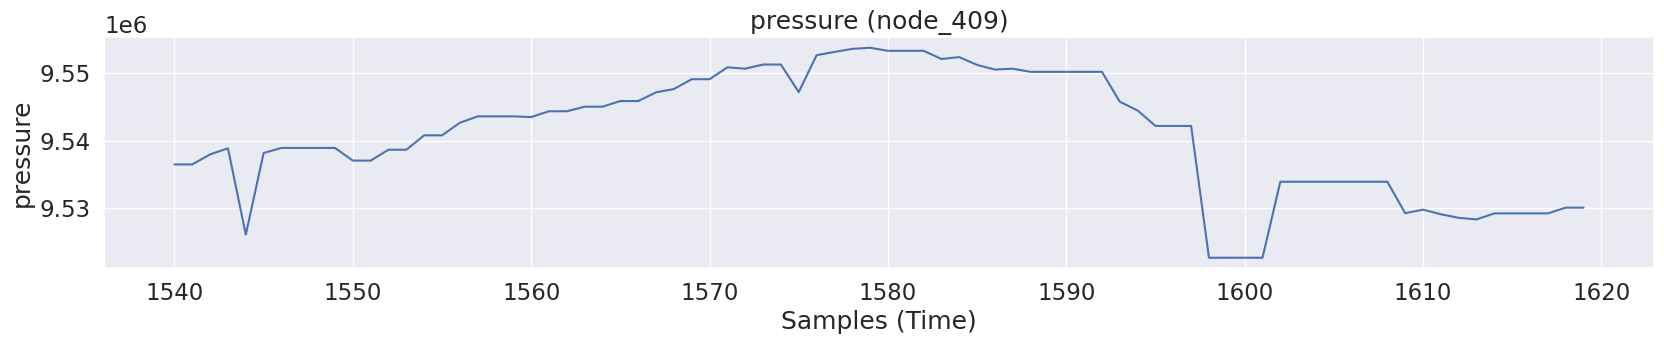

In [40]:
selected_sensor = 32

sensor_df = groups_sensor[selected_sensor]
headers = list(sensor_df)
outlet = str(sensor_df['Outlet'].iloc[selected_sensor])
name = str(sensor_df['Name'].iloc[selected_sensor])
print(f'Sensor nº {selected_sensor} - {name} - outlet : {outlet} - Shape: {sensor_df.shape}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()
print('\n\n\n*******************************************')
print('*******************************************')
print('*******************************************\n\n\n')


init = 1540
end = 1620
print(f'Zoom -> init: {init}, max_ {end}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    data = data[init:end]
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()

Sensor nº 32 - node_409 - outlet : 1 - Shape: (4070, 6)


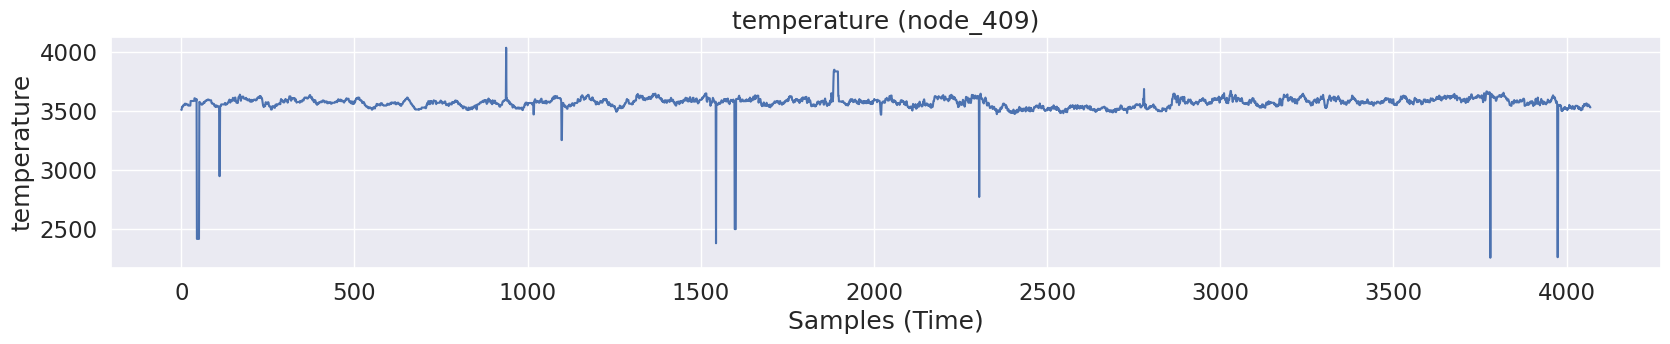

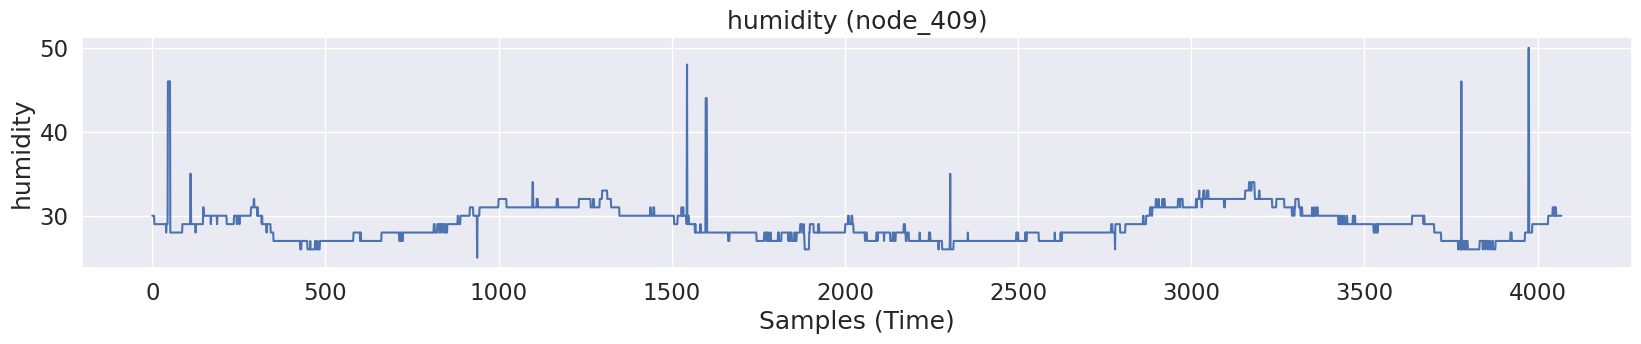

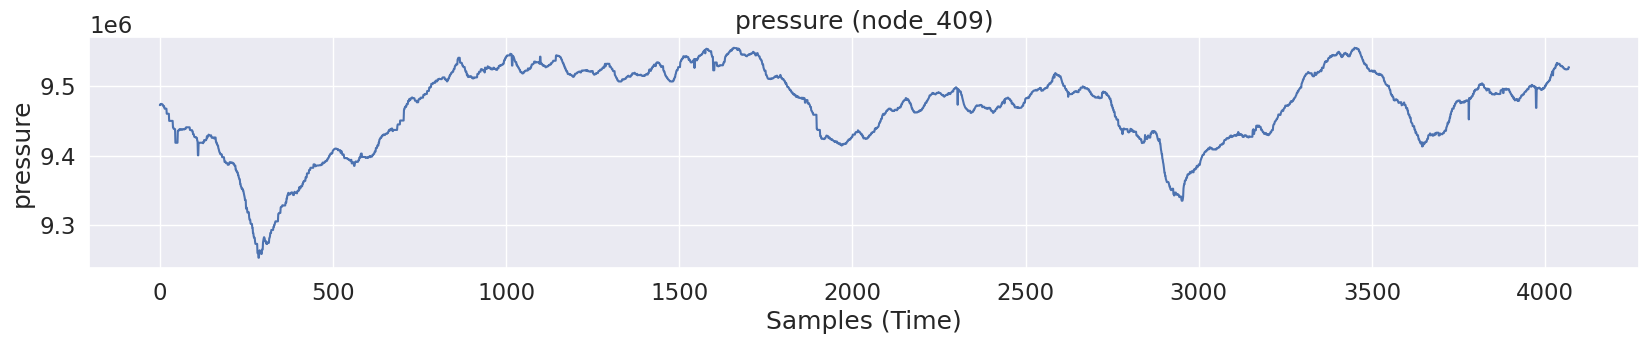




*******************************************
*******************************************
*******************************************



Zoom -> init: 900, max_ 1000


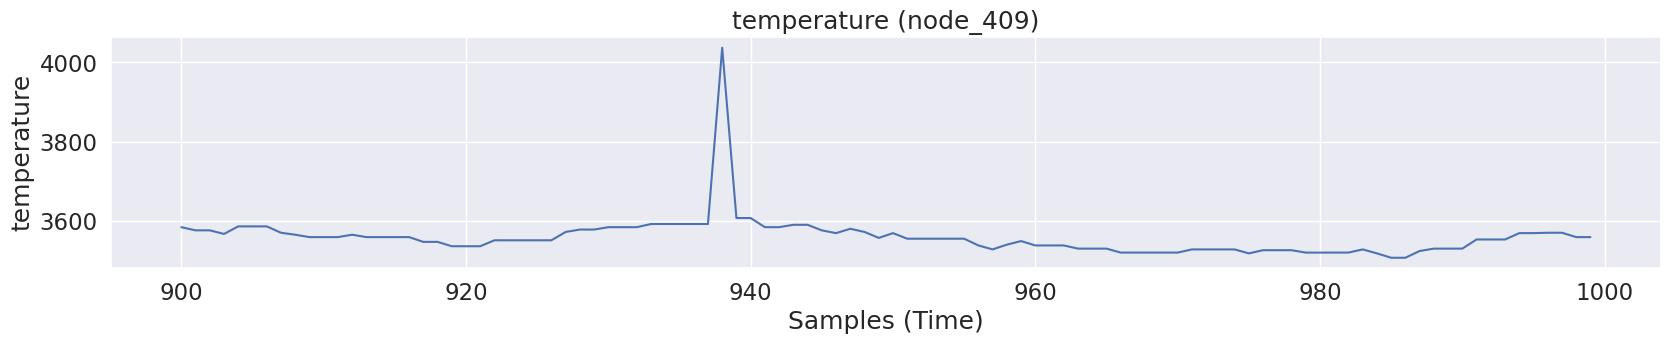

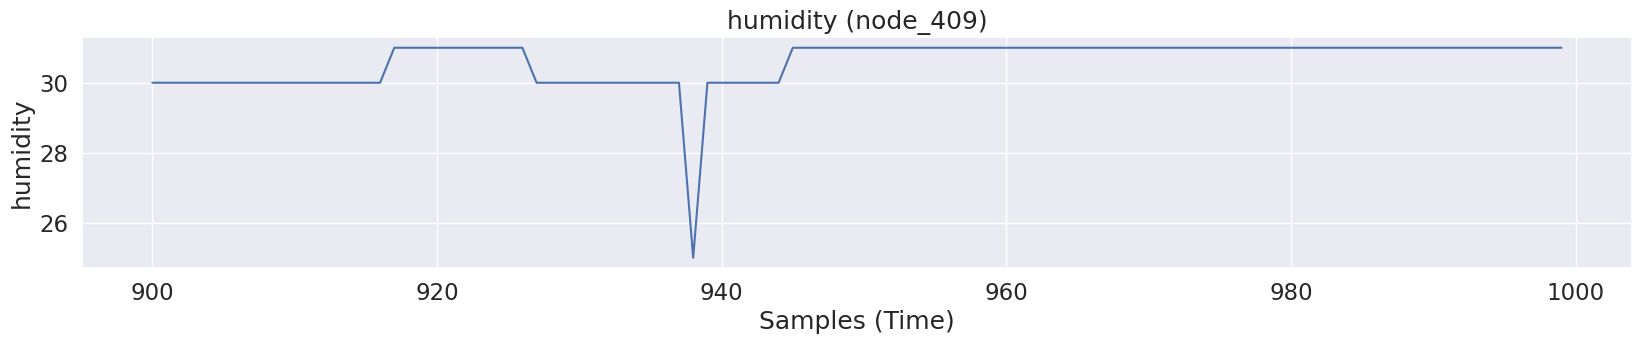

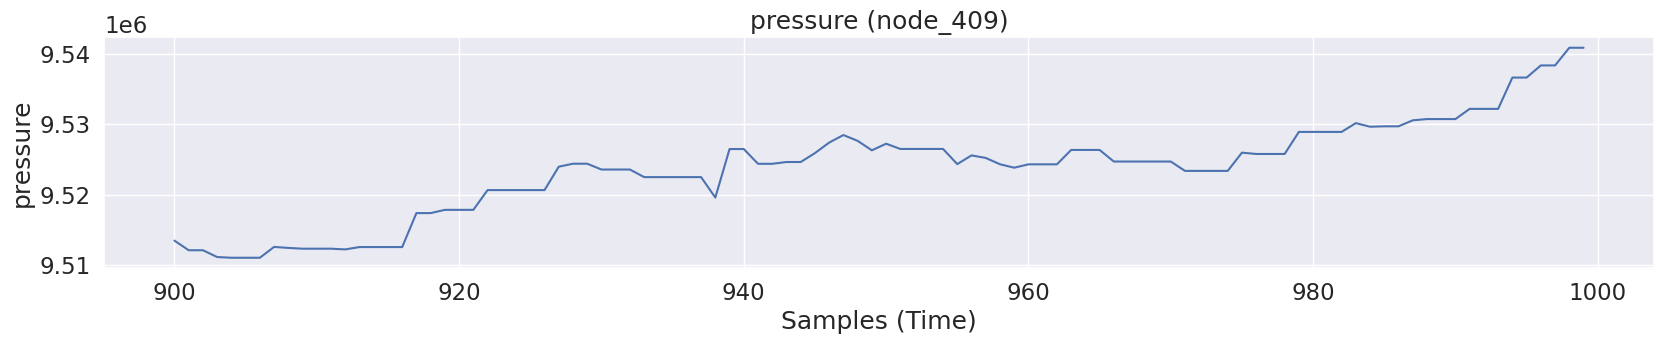

In [41]:
selected_sensor = 32

sensor_df = groups_sensor[selected_sensor]
headers = list(sensor_df)
outlet = str(sensor_df['Outlet'].iloc[selected_sensor])
name = str(sensor_df['Name'].iloc[selected_sensor])
print(f'Sensor nº {selected_sensor} - {name} - outlet : {outlet} - Shape: {sensor_df.shape}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()
print('\n\n\n*******************************************')
print('*******************************************')
print('*******************************************\n\n\n')


init = 900
end = 1000
print(f'Zoom -> init: {init}, max_ {end}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    data = data[init:end]
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()

Sensor nº 8 - node_384 - outlet : 0 - Shape: (4070, 6)


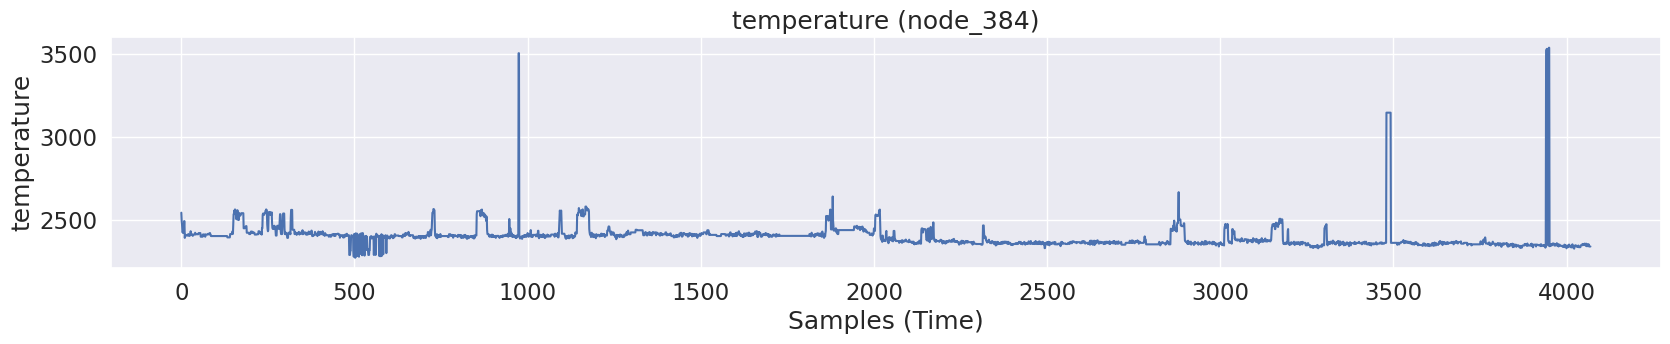

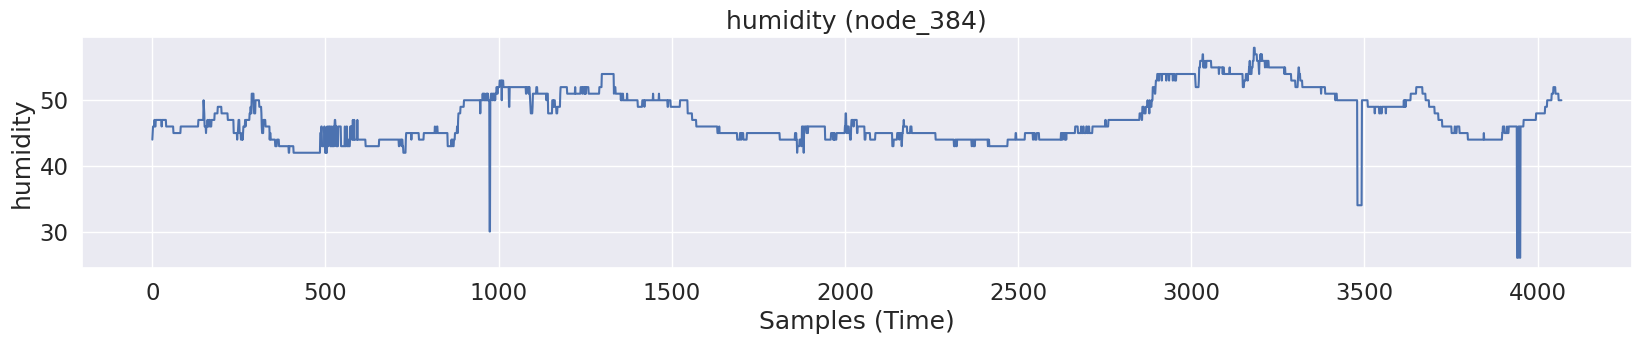

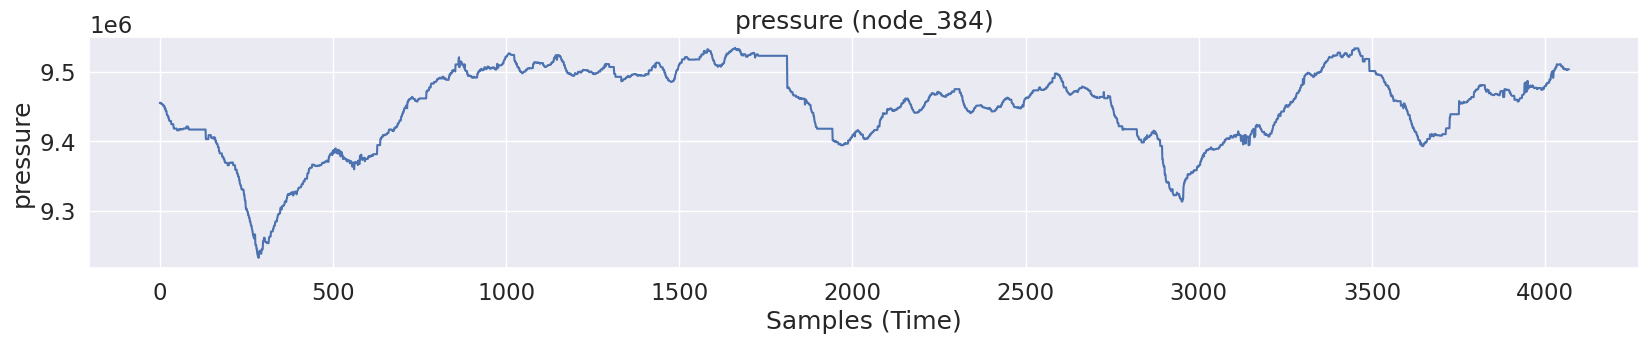




*******************************************
*******************************************
*******************************************



Zoom -> init: 400, max_ 1000


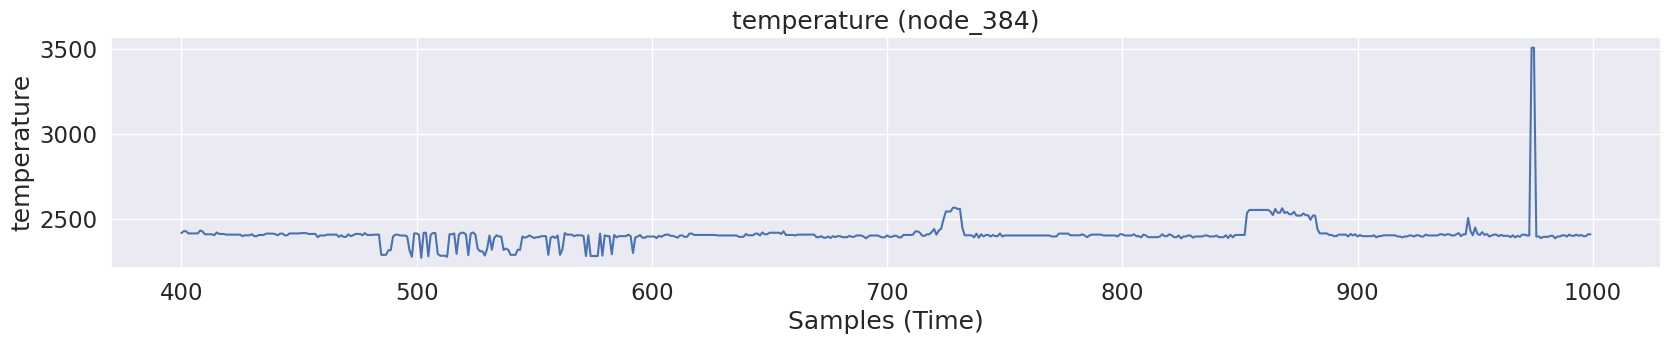

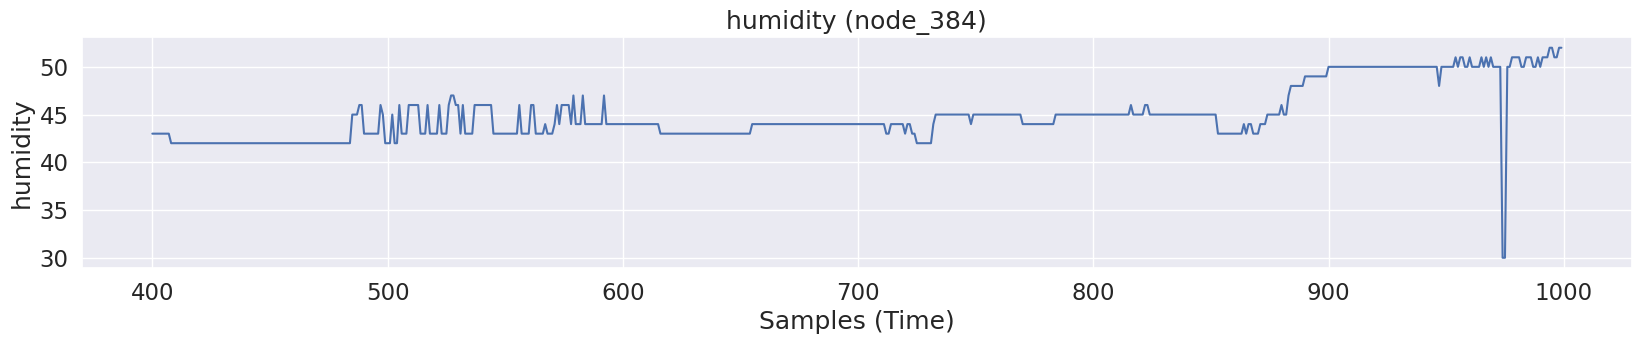

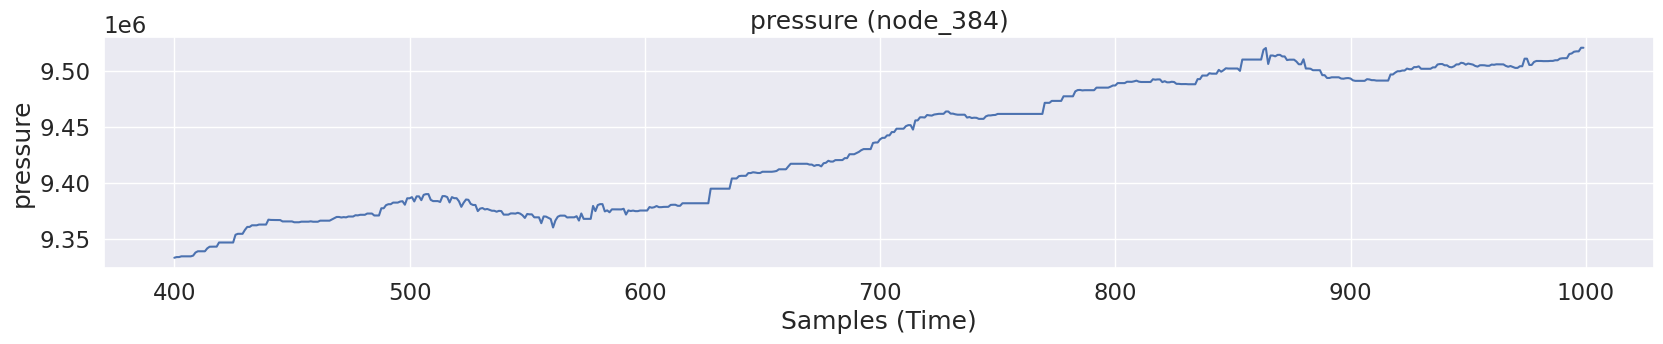

In [42]:
selected_sensor = 8

sensor_df = groups_sensor[selected_sensor]
headers = list(sensor_df)
outlet = str(sensor_df['Outlet'].iloc[selected_sensor])
name = str(sensor_df['Name'].iloc[selected_sensor])
print(f'Sensor nº {selected_sensor} - {name} - outlet : {outlet} - Shape: {sensor_df.shape}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()
print('\n\n\n*******************************************')
print('*******************************************')
print('*******************************************\n\n\n')


init = 400
end = 1000
print(f'Zoom -> init: {init}, max_ {end}')
for i in range(3, len(headers)):
    column = str(headers[i])
    fig, ax = plt.subplots(figsize=(20,3))
    ax.set(xlabel='Samples (Time)')
    data = sensor_df[column]
    data = data.reset_index(drop = True)
    data = data[init:end]
    sns.lineplot(data=data, ax=ax).set(title=column + ' (' + name + ')')
    plt.show()

# Paso 7) Clustering sobre los datos "en crudo"

Necesario ejecutar previamente:

*   Carga y limpieza de datos

Variables creadas:


*   data_vector: datos de los sensores ordenados por momento temporal y por nodo
*   temp_vector, humd_vector, pres_vector: data_vector pero separado por medidas



En este proceso se realizará un primer intento de clustering DBSCAN para ver qué resultado se obtiene. También se probarán diferentes representaciones 2D y 3D para así elegir cuál nos gusta más para futuros análisis.

Es poner un punto de partida

## 7.1. Preparación de los datos

Comenzamos recuperando el dataframe original con todos los datos y creando a partir de éste un nuevo dataframe en el que prescindiremos del nombre de los nodos, de los timestamps, y de la condición inlet/oulet de cada lectura (no las necesitamos para realizar el clustering).

In [43]:
df_sensor

Name     timestamp  Outlet  temperature  humidity  pressure
0       node_441  1.601457e+09       1         2940        38   9469914
1       node_440  1.601457e+09       1         2949        38   9450785
2       node_439  1.601457e+09       1         3094        36   9454878
3       node_396  1.601457e+09       1         3421        30   9456506
4       node_395  1.601457e+09       1         3536        28   9465874
...          ...           ...     ...          ...       ...       ...
256405  node_419  1.603902e+09       1         3029        36   9510119
256406  node_418  1.603902e+09       1         2711        42   9499704
256407  node_417  1.603902e+09       1         3195        33   9535832
256408  node_416  1.603902e+09       1         3321        32   9506282
256409  node_415  1.603902e+09       1         3976        24   9520996

[256410 rows x 6 columns]

Cada una de las diferentes columnas de datos de nuestro dataframe están organizadas en bloques de 63 valores (ordenados cronológicamente según el momento de su adquisición) uno por cada uno de los 63 sensores o nodos con los que estamos trabajando. El siguiente código permite mostrar los primeros 63 valores correspondientes a la primera lectura o primer instante de adquisición.

In [44]:
df_sensor[df_sensor['timestamp']==df_sensor['timestamp'][0]]

Name     timestamp  Outlet  temperature  humidity  pressure
0   node_441  1.601457e+09       1         2940        38   9469914
1   node_440  1.601457e+09       1         2949        38   9450785
2   node_439  1.601457e+09       1         3094        36   9454878
3   node_396  1.601457e+09       1         3421        30   9456506
4   node_395  1.601457e+09       1         3536        28   9465874
..       ...           ...     ...          ...       ...       ...
58  node_419  1.601457e+09       1         3509        28   9463782
59  node_418  1.601457e+09       1         2973        37   9449641
60  node_417  1.601457e+09       1         3300        31   9484401
61  node_416  1.601457e+09       1         3661        28   9458932
62  node_415  1.601457e+09       1         4277        22   9476584

[63 rows x 6 columns]

El siguiente código muestra las siguientes 63 lecturas del dataframe.
Nótese que **el orden es idéntico desde el punto de vista de los nodos**.

In [45]:
df_sensor[df_sensor['timestamp']==df_sensor['timestamp'][64]]

Name     timestamp  Outlet  temperature  humidity  pressure
63   node_441  1.601457e+09       1         2931        38   9468417
64   node_440  1.601457e+09       1         2949        38   9450785
65   node_439  1.601457e+09       1         3081        35   9453703
66   node_396  1.601457e+09       1         3412        30   9455832
67   node_395  1.601457e+09       1         3525        28   9465168
..        ...           ...     ...          ...       ...       ...
121  node_419  1.601457e+09       1         3504        28   9462417
122  node_418  1.601457e+09       1         2960        37   9448625
123  node_417  1.601457e+09       1         3300        31   9484401
124  node_416  1.601457e+09       1         3641        28   9458176
125  node_415  1.601457e+09       1         4214        22   9475459

[63 rows x 6 columns]

Por último, mostramos el último conjunto de 63 lecturas.

In [46]:
df_sensor[df_sensor['timestamp']==df_sensor['timestamp'][256409]]

Name     timestamp  Outlet  temperature  humidity  pressure
256347  node_441  1.603902e+09       1         2853        41   9518915
256348  node_440  1.603902e+09       1         2839        40   9501447
256349  node_439  1.603902e+09       1         2839        41   9504735
256350  node_396  1.603902e+09       1         3187        34   9506923
256351  node_395  1.603902e+09       1         3305        32   9515693
...          ...           ...     ...          ...       ...       ...
256405  node_419  1.603902e+09       1         3029        36   9510119
256406  node_418  1.603902e+09       1         2711        42   9499704
256407  node_417  1.603902e+09       1         3195        33   9535832
256408  node_416  1.603902e+09       1         3321        32   9506282
256409  node_415  1.603902e+09       1         3976        24   9520996

[63 rows x 6 columns]

Finalmente, creamos el dataframe con la información estrictamente necesaria para abordar el clustering.

In [47]:
selected_columns = df_sensor[["temperature","humidity", "pressure"]]
new_df = selected_columns.copy()

temp_df = df_sensor[["temperature"]].copy()
humd_df = df_sensor[["humidity"]].copy()
pres_df = df_sensor[["pressure"]].copy()

In [48]:
new_df

temperature  humidity  pressure
0              2940        38   9469914
1              2949        38   9450785
2              3094        36   9454878
3              3421        30   9456506
4              3536        28   9465874
...             ...       ...       ...
256405         3029        36   9510119
256406         2711        42   9499704
256407         3195        33   9535832
256408         3321        32   9506282
256409         3976        24   9520996

[256410 rows x 3 columns]

### Pre-procesado de los datos
Vamos a realizar ciertas transformaciones sobre los datos para las cuales es necesario convertir nuestro dataframe en un array de **numpy** (https://numpy.org/doc/stable/reference/generated/numpy.array.html).

**NumPy** (pronunciado /ˈnʌmpaɪ/ (numpai) o, a veces /ˈnʌmpi/​​ (numpi)) es una biblioteca para el lenguaje de programación Python que da soporte para crear vectores y matrices grandes multidimensionales, junto con una gran colección de funciones matemáticas de alto nivel para operar con ellas (source: Wikipedia).

In [49]:
np_data = new_df.to_numpy()
np_data

array([[   2940,      38, 9469914],
       [   2949,      38, 9450785],
       [   3094,      36, 9454878],
       ...,
       [   3195,      33, 9535832],
       [   3321,      32, 9506282],
       [   3976,      24, 9520996]])

La primera operación de pre-procesado importante que aplicaremos será la **normalización** de los datos.
Este proceso tiene por objetivo mejorar la interpretabilidad y la comparación de los datos.
En nuestro caso, emplearemos la **estandarización** mediante el cálculo de los Z-scores (https://en.wikipedia.org/wiki/Standard_score).

Nótese que para calcular la media y la desviación estándar correspondientes a cada magnitud sólo empleamos los datos propios de dicha magnitud.

In [50]:
temp_data = np_data[:,0]
temp_data_z = stats.zscore(temp_data)

humd_data = np_data[:,1]
humd_data_z = stats.zscore(humd_data)

pres_data = np_data[:,2]
pres_data_z = stats.zscore(pres_data)

In [51]:
np_data.shape

(256410, 3)

In [52]:
np_data_norm = np.zeros(np_data.shape) # permite crear un array numpy relleno de ceros y con las dimensiones especificadas por np_data.shape

np_data_norm[:,0] = temp_data_z[:]
np_data_norm[:,1] = humd_data_z[:]
np_data_norm[:,2] = pres_data_z[:]

In [53]:
np_data_norm

array([[-0.31809939,  0.30604329,  0.22465012],
       [-0.30118775,  0.30604329, -0.09724104],
       [-0.02872245,  0.07071257, -0.02836653],
       ...,
       [ 0.16106373, -0.28228353,  1.33387808],
       [ 0.39782669, -0.39994889,  0.83662868],
       [ 1.62861824, -1.34127181,  1.08422691]])

### Creación de los vectores de características

Una vez convenientemente normalizados los datos, el siguiente paso es construir los **vectores de características** con los que alimentaremos el algoritmo de clustering. En este sentido, la propuesta más sencilla pasa por asimilar el conjunto de valores correspondiente a un mismo timestamp o instante de medida como nuestro vector de características. Dicho vector constará, por tanto, de 63 nodos x 3 magnitudes/nodo = **189 componentes o dimensiones**.

Dispondremos una matriz con 189 columnas (una por dimensión o característica) y en la que cada vector ocupará una fila, resultando en tantas filas como timestamps distintos dispongamos. Para ello usaremos la función **"CreateFeatureVectors"** definida a continuación.

In [54]:
def CreateFeatureVectors(data):
  num_nodes = 63
  num_rows, num_cols = data.shape # shape: devuelve las dimensiones de nuestro array (matriz en este caso) numpy
  num_measures_per_node = num_cols # 3 (i.e. temperatura, humedad y presión)
  num_samples = int(num_rows / num_nodes)

  samples = np.zeros((num_samples, num_nodes*num_cols)) # para crear una nueva matriz "samples" rellena de ceros y de dimensiones (4070, 189)

  # recordemos que "data" es una matriz (256410, 3)
  n_row = 0 # hasta num_samples
  n_col = 0 # hasta num_nodes*num_cols = 189

  for i in range(num_rows): # recorremos todas las filas de la matriz original (256410, 3)
    for elem in data[i]: # añadimos a la fila los valores de cada nodo de 3 en 3 hasta agotar los del timestamp específico
      if (n_col == num_nodes*num_measures_per_node): # si llenamos la fila, pasamos a la siguiente (siguiente timestamp)
        n_col = 0
        n_row += 1 # siguiente fila
      samples[n_row, n_col] = elem
      n_col += 1

  return samples

In [55]:
samples = CreateFeatureVectors(np_data_norm)

Comprobamos el número y las dimensiones de nuestros vectores de características.

In [56]:
samples.shape

(4070, 189)

## 7.2. Clustering DBScan
Como primera solución para realizar el clustering emplearemos uno de los llamados **"métodos basados en densidad"**. Emplear la densidad de puntos como criterio de agrupamiento local nos permite identificar o distinguir diferentes regiones densas de puntos (i.e. clusters) que están separadas entre sí por otras regiones poco o menos densas.

Este tipo de métodos resultan particularmente útiles cuando los clusters tienen formas irregulares o arbitrarias, están entrelazados o ante la presencia de ruido (outliers) en los datos (son soluciones que destacan por su robustez frente al ruido).

En particular, emplearemos el método "DBSCAN: Density Based Spatial Clustering of Applications with Noise" (Ester et al., KDD’1996) (source: https://es.wikipedia.org/wiki/DBSCAN).

### Ajuste de parámetros

Para poder aplicar DBSCAN, es necesario especificar dos parámetros:
* epsilon (eps): el radio de vecindad que determina si dos puntos son potencialmente parte de un clúster.
* MinPts: el número mínimo de puntos requeridos para que una región se considere densa.

Idealmente, el valor de eps vendría dado por el problema a resolver (por ejemplo, una distancia física), circunstancia para la que MinPts sería entonces el tamaño de clúster mínimo deseado. Sin embargo, en problemas como el que nos ocupa, el valor a emplear para ambos parámetros no resulta tan sencillo o evidente.

Como regla general, cuanto más grande es el conjunto de datos, mayor será el valor de MinPts elegido. Nótese que un valor de MinPts = 1 no tendría sentido, ya que de ese modo todos los puntos con los que trabajamos serían un clúster. En general, los valores grandes de MinPts son mejores para conjuntos de datos con ruido y producirán agrupaciones (i.e. clusters) más importantes.

Para elegir el valor de eps podemos hacer uso de lo que podríamos denominar un gráfico de "distancias al K-vecino". Este tipo de gráfico muestra de una manera ordenada cuál es la distancia de cada muestra o punto con el que estamos trabajando a su K-vecino más cercano (i.e. si K=1 al vecino más cercano, si K=2 al segundo más cercano, si K=3 al tercero y así sucesivamente). De este modo, **podemos proponer un valor adecuado para eps a partir de la localización en dicho gráfico del punto o la zona en la que se evidencie una mayor o más fuerte curvatura.**

La idea que hay detrás de este procedimiento es que para valores de eps demasiado pequeños (i.e. por debajo o a la izquierda del citado "codo" de la curva), no se agruparán una gran parte de los datos. Por otro lado, para valores excesivamente altos (i.e. por encima o a la derecha del codo), las agrupaciones se fusionan y la mayoría de los muestras o puntos terminan cayendo en el mismo cluster.

También podemos verlo del siguiente modo: en los puntos de un mismo cluster, su k-ésimo vecino debería estar más o menos a la misma distancia.
Por el contrario, en los puntos de ruido, su k-ésimo vecino debería estar más lejos.

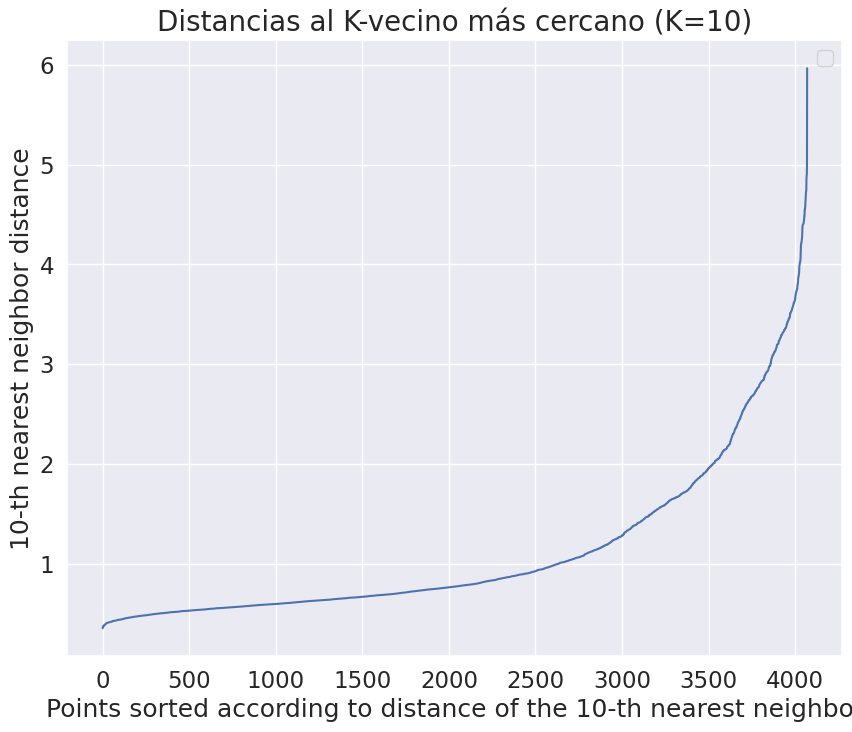

In [57]:
PlotDistancesToKnearestNeighbor(samples, 10)

### [**Ejercicio 2]**
Tome una decisión en relación al valor que desea emplear para **MinPts**. Después ejecute la correspondiente llamada a la función **"PlotDistancesToKnearestNeighbor"**, obtenga la representación adecuada a dicha decisión y decida igualmente a partir de dicha representación el valor que considere adecuado para **epsilon**. **Recuerde guardar una captura de la representación obtenida.**

In [58]:
MinPts = 10

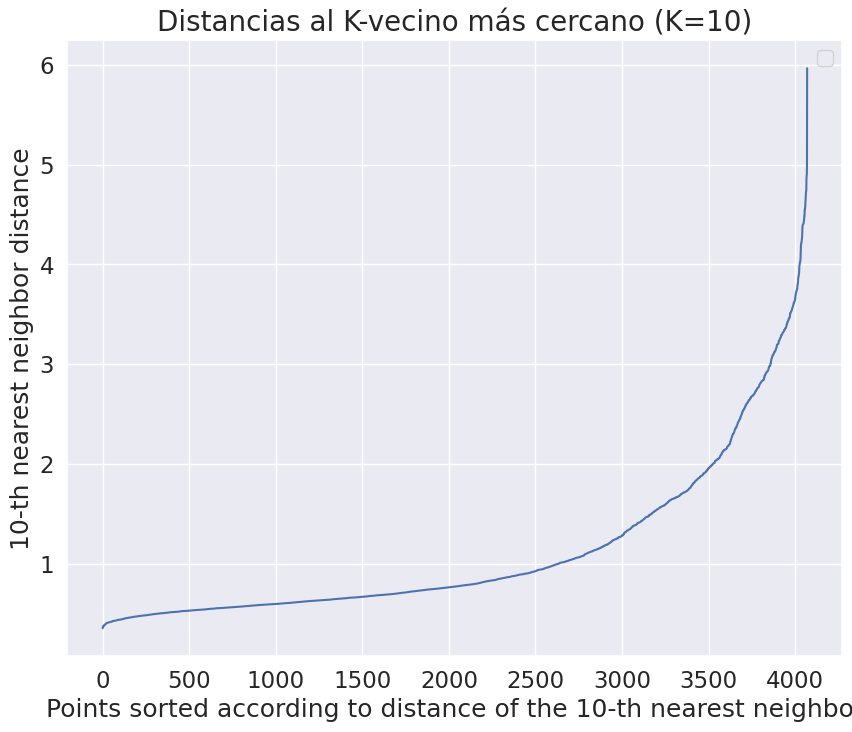

In [59]:
min_samples = MinPts # reemplace MinPts por el valor que considere oportuno
PlotDistancesToKnearestNeighbor(samples, min_samples)

In [60]:
eps = 2

In [61]:
epsilon = eps # reemplace eps por el valor que considere oportuno

### Algoritmo de clustering
El siguiente bloque de código permite aplicar el algoritmo DBScan a nuestros datos mediante la llamada al procedimiento **"ApplyDBScanToData"**. Como puede observarse, se hace para diferentes valores del parámetro epsilon. En cada caso, se reportan los datos correspondientes al resultado del mismo incluyendo: el número de clusteres resultante, el número de puntos o muestras que no han sido asignadas a cluster alguno (i.e. consideradas como "ruido") y finalmente el conocido como coeficiente "silueta".

El coeficiente de silueta es una métrica para evaluar la calidad del agrupamiento obtenido con algoritmos de clustering. El objetivo de la silueta es identificar cuál es el número óptimo de agrupamientos.

El coeficiente de silueta es un valor comprendido entre -1 y 1 (source: https://en.wikipedia.org/wiki/Silhouette_(clustering)).

Los valores cercanos a 1 indican que, en promedio, nuestras muestras están bien asignadas a su cluster. Por el contrario, los valores cercanos a −1 indican que, en promedio, nuestras muestras están mal asignadas a su cluster. Finalmente, valores alrededor de 0 indican que nuestras muestras equidistan de varios clusters.

In [62]:
min_samples = 10
epsilon_values = [1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples, epsilon, min_samples=min_samples)

epsilon = 2.5
labels = aux_labels[epsilon]


Test for epsilon = 1.5
Estimated number of clusters: 30
Estimated number of noise points: 693
Silhouette Coefficient: -0.065

Test for epsilon = 1.75
Estimated number of clusters: 26
Estimated number of noise points: 534
Silhouette Coefficient: -0.290

Test for epsilon = 2
Estimated number of clusters: 19
Estimated number of noise points: 416
Silhouette Coefficient: -0.383

Test for epsilon = 2.25
Estimated number of clusters: 15
Estimated number of noise points: 358
Silhouette Coefficient: -0.433

Test for epsilon = 2.5
Estimated number of clusters: 15
Estimated number of noise points: 288
Silhouette Coefficient: -0.441

Test for epsilon = 2.75
Estimated number of clusters: 11
Estimated number of noise points: 200
Silhouette Coefficient: -0.405

Test for epsilon = 3
Estimated number of clusters: 7
Estimated number of noise points: 154
Silhouette Coefficient: -0.351

Test for epsilon = 3.25
Estimated number of clusters: 6
Estimated number of noise points: 106
Silhouette Coefficient: -

El siguiente código muestra el detalle de cuántas muestras han sido asignadas a cada uno de los diferentes clústeres. Tenga en cuenta que el cluster "-1" no es en realidad un cluster sino el conjunto de muestras consideradas como "ruido".

In [63]:
np.unique(labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([ 288, 3553,   10,   26,   17,   12,   13,   14,   13,   21,   10,
          11,   10,   14,   47,   11]))

### Visualización del resultado en 2D
En este apartado visualizaremos el resultado de aplicar el algoritmo de clustering a nuestros datos. A modo de referencia, comenzaremos visualizando los datos tal cual, sin ninguna información relativa al clustering. Para ello, y dada la elevada dimensionalidad de los mismos, debemos hacer uso de alguna técnica de reducción de dimensionalidad que permita transformar los datos originales a un nuevo espacio de como mucho 2 ó 3 dimensiones con el fin de poder representarlos gráficamente. Para ello haremos uso de PCA (source: https://en.wikipedia.org/wiki/Principal_component_analysis), una de las técnicas vistas en clase.

In [64]:
pca2D = PCA(n_components=2)
pca2D.fit(samples)
samples_PCA_2D = pca2D.transform(samples)
df_samples_PCA_2D = pd.DataFrame(data=samples_PCA_2D, columns=["pca0", "pca1"])
df_samples_PCA_2D

pca0      pca1
0    -0.826601 -1.615488
1    -0.829172 -1.637459
2    -0.851822 -1.409487
3    -0.831423 -1.443471
4    -0.811776 -1.425638
...        ...       ...
4065 -7.362090  2.483118
4066 -7.406225  2.468769
4067 -7.501489  2.471624
4068 -7.566521  2.531090
4069 -7.631921  2.649524

[4070 rows x 2 columns]

<ipython-input-5-bc98db8e206f>:207: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(data=df_samples_2D,


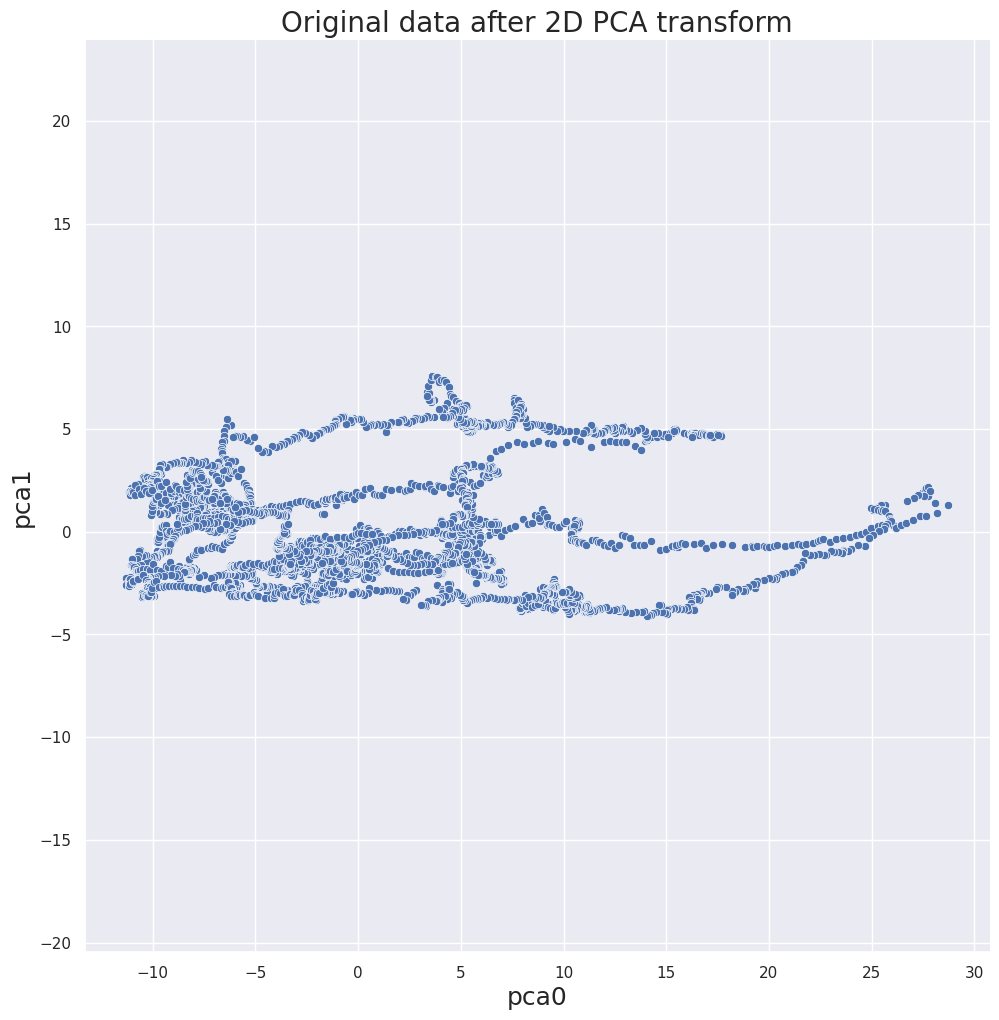

In [65]:
title = 'Original data after 2D PCA transform'
axes_PCA_2D = {'x': 'pca0', 'y': 'pca1'}
Plot2D (samples_PCA_2D, title, axes_PCA_2D)

A continuación pintamos el resultado de nuestro clustering.

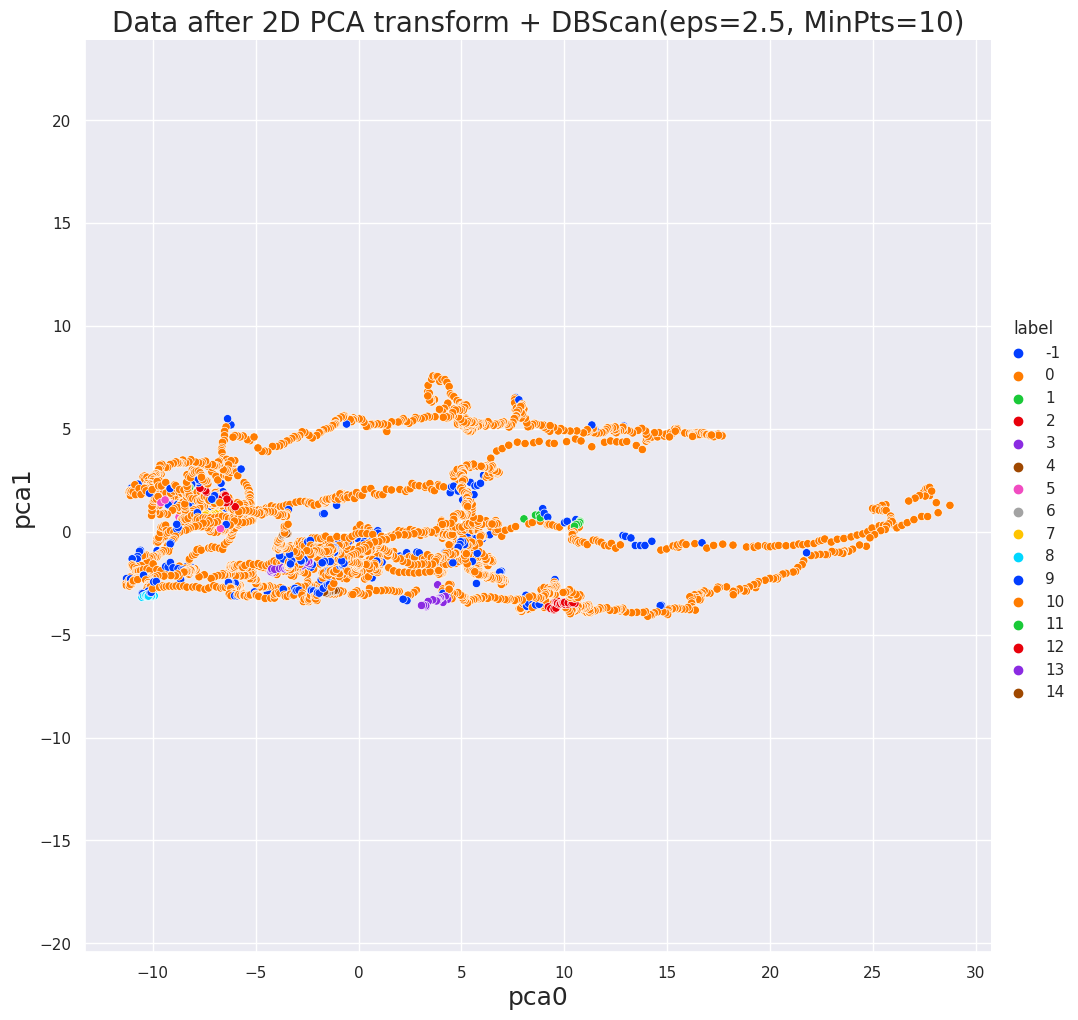

In [66]:
title = f'Data after 2D PCA transform + DBScan(eps={epsilon}, MinPts={min_samples})'
Plot2D_WithLabels (samples_PCA_2D, labels, title, axes_PCA_2D)

### Visualización del resultado en 3D

Antes de continuar con otras estrategias probaremos a representar una vez más el resultado anterior pero en este caso tras realizar una transformación PCA a 3 dimensiones.

In [67]:
pca3D = PCA(n_components=3)
pca3D.fit(samples)
samples_PCA_3D = pca3D.transform(samples)
df_samples_PCA_3D = pd.DataFrame(data=samples_PCA_3D, columns=["pca0", "pca1", "pca2"])
df_samples_PCA_3D

pca0      pca1      pca2
0    -0.826601 -1.615488  1.290720
1    -0.829172 -1.637459  1.424050
2    -0.851822 -1.409487  1.178457
3    -0.831423 -1.443471  1.229613
4    -0.811776 -1.425638  1.217962
...        ...       ...       ...
4065 -7.362090  2.483118 -1.164760
4066 -7.406225  2.468769 -1.195986
4067 -7.501489  2.471624 -1.229575
4068 -7.566521  2.531090 -1.214109
4069 -7.631921  2.649524 -1.236836

[4070 rows x 3 columns]

In [68]:
title = 'Original data after 3D PCA transform'
axes_PCA_3D = {'x': 'pca0', 'y': 'pca1', 'z': 'pca2'}
Plot3D (samples_PCA_3D, title, axes_PCA_3D)

Finalmente, pintamos de nuevo el resultado del clustering pero en esta ocasión en el espacio 3D.

In [69]:
title = f'Data after 3D PCA transform + DBScan(eps={epsilon}, MinPts={min_samples})'
Plot3D_WithLabels (samples_PCA_3D, labels, title, axes_PCA_3D)

## 7.3. Reducción de dimensionalidad + clustering
A diferencia de como hicimos en el apartado anterior, en el que realizamos el clustering directamente sobre el espacio original de los atributos o características, en esta ocasión **aplicaremos el algoritmo de reducción de dimensionalidad ANTES de realizar el clustering.**

### Visualización del resultado en 2D

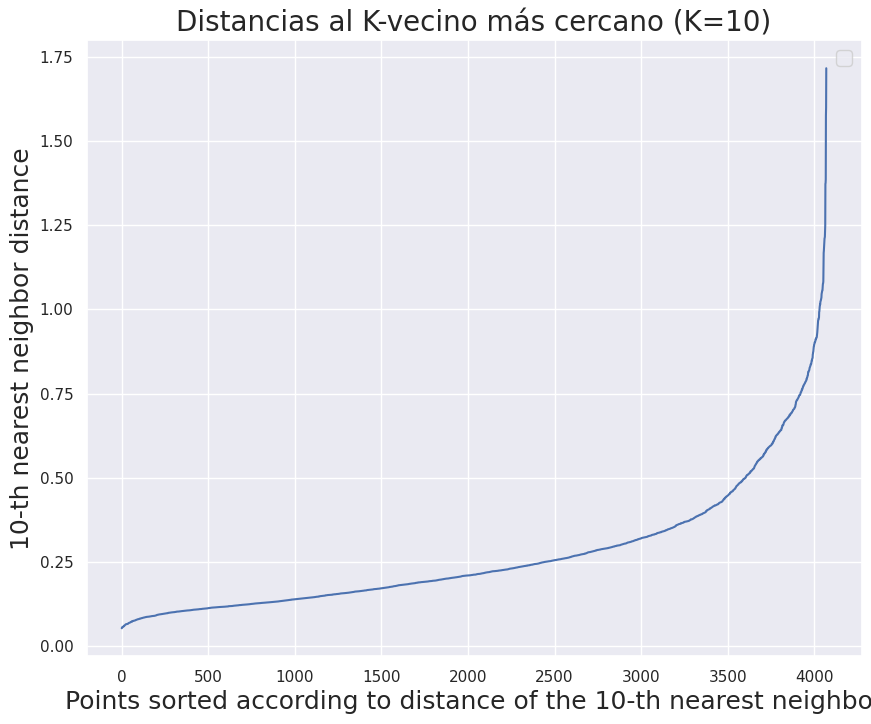

In [70]:
PlotDistancesToKnearestNeighbor(samples_PCA_2D, 10) # notese que el parametro de entrada NO es samples

In [71]:
min_samples = 10
epsilon_values = [0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.400, 0.425, 0.450, 0.475, 0.500, 0.525, 0.550, 0.575, 0.600, 0.625, 0.65]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_PCA_2D, epsilon, min_samples=min_samples)

epsilon = 0.425
labels_PCA_2D = aux_labels[epsilon]


Test for epsilon = 0.25
Estimated number of clusters: 49
Estimated number of noise points: 1051
Silhouette Coefficient: -0.064

Test for epsilon = 0.275
Estimated number of clusters: 39
Estimated number of noise points: 893
Silhouette Coefficient: -0.012

Test for epsilon = 0.3
Estimated number of clusters: 37
Estimated number of noise points: 746
Silhouette Coefficient: 0.023

Test for epsilon = 0.325
Estimated number of clusters: 33
Estimated number of noise points: 630
Silhouette Coefficient: 0.094

Test for epsilon = 0.35
Estimated number of clusters: 26
Estimated number of noise points: 551
Silhouette Coefficient: 0.136

Test for epsilon = 0.375
Estimated number of clusters: 19
Estimated number of noise points: 493
Silhouette Coefficient: 0.081

Test for epsilon = 0.4
Estimated number of clusters: 19
Estimated number of noise points: 445
Silhouette Coefficient: 0.095

Test for epsilon = 0.425
Estimated number of clusters: 19
Estimated number of noise points: 381
Silhouette Coeffi

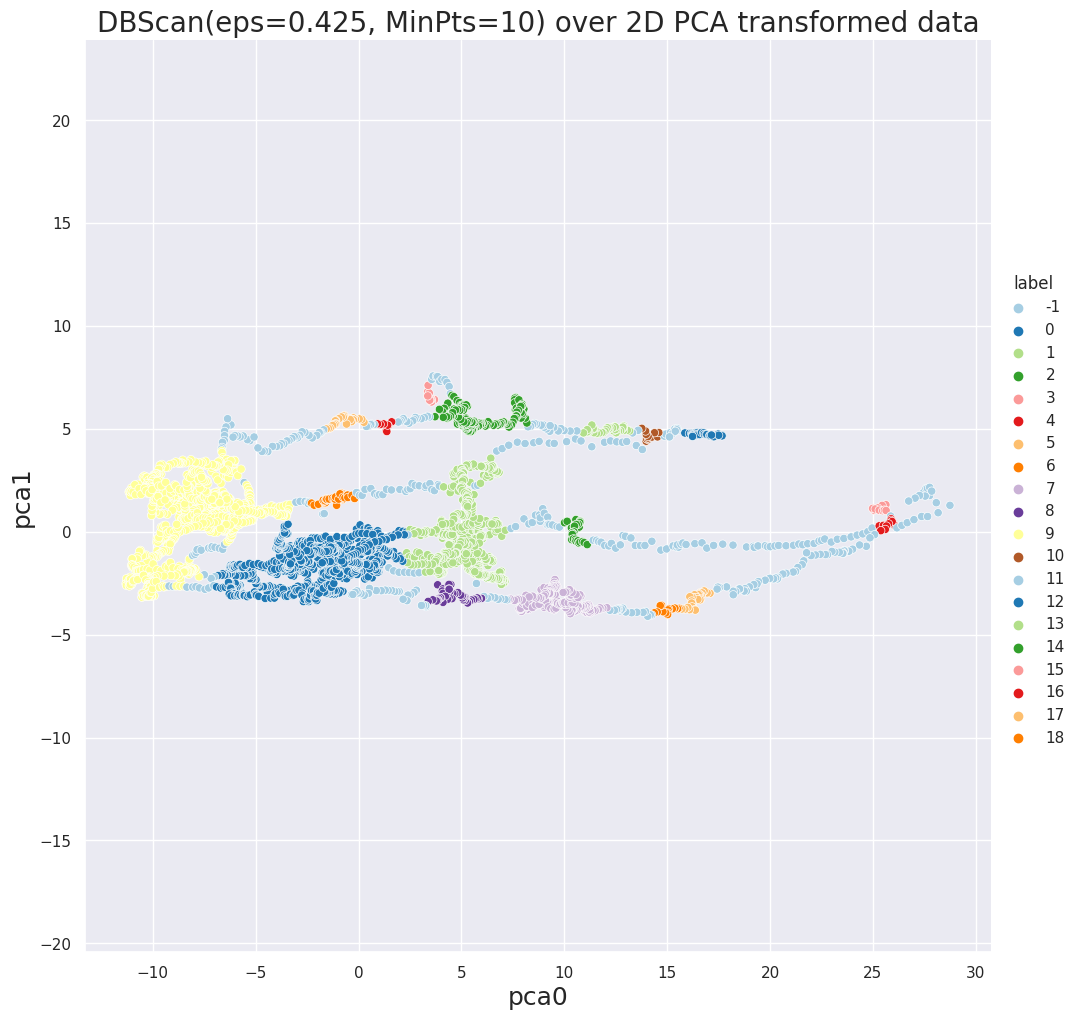

In [72]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D PCA transformed data'
Plot2D_WithLabels (samples_PCA_2D, labels_PCA_2D, title, axes_PCA_2D, palette="Paired") # Cambiamos colores para mejor visualizacion del ruido

### Visualización del resultado en 3D

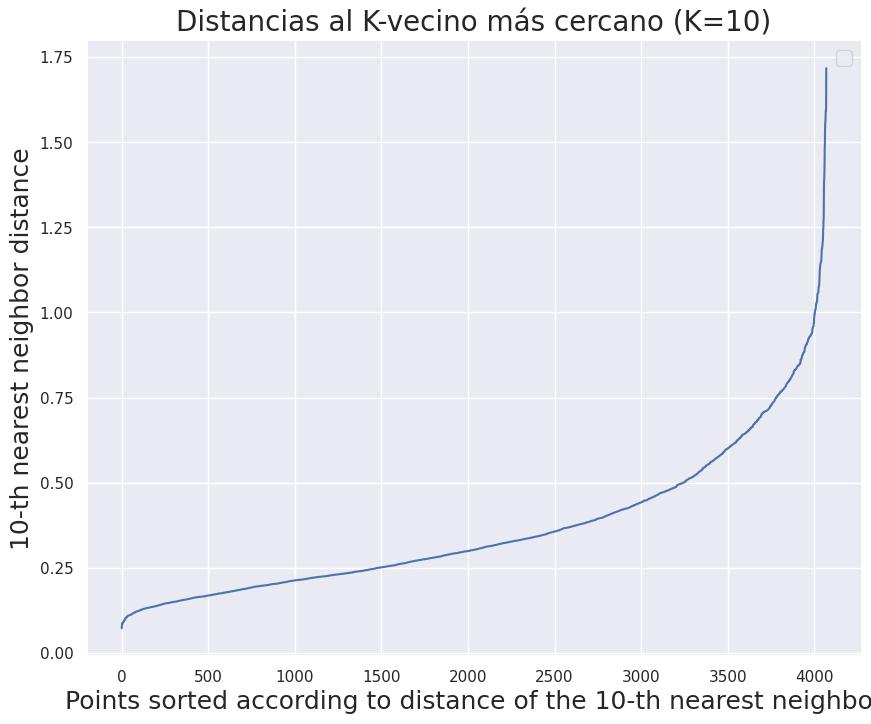

In [73]:
PlotDistancesToKnearestNeighbor(samples_PCA_3D, 10) # notese que el parametro de entrada NO es samples

In [74]:
min_samples = 10
epsilon_values = [0.350, 0.375, 0.400, 0.425, 0.450, 0.475, 0.5, 0.525, 0.550, 0.575, 0.600, 0.625, 0.650, 0.675]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_PCA_3D, epsilon, min_samples=min_samples)

epsilon = 0.5
labels_PCA_3D = aux_labels[epsilon]


Test for epsilon = 0.35
Estimated number of clusters: 52
Estimated number of noise points: 1050
Silhouette Coefficient: 0.070

Test for epsilon = 0.375
Estimated number of clusters: 51
Estimated number of noise points: 904
Silhouette Coefficient: 0.133

Test for epsilon = 0.4
Estimated number of clusters: 43
Estimated number of noise points: 794
Silhouette Coefficient: 0.172

Test for epsilon = 0.425
Estimated number of clusters: 39
Estimated number of noise points: 718
Silhouette Coefficient: 0.145

Test for epsilon = 0.45
Estimated number of clusters: 32
Estimated number of noise points: 646
Silhouette Coefficient: 0.155

Test for epsilon = 0.475
Estimated number of clusters: 27
Estimated number of noise points: 571
Silhouette Coefficient: 0.152

Test for epsilon = 0.5
Estimated number of clusters: 27
Estimated number of noise points: 480
Silhouette Coefficient: 0.155

Test for epsilon = 0.525
Estimated number of clusters: 23
Estimated number of noise points: 449
Silhouette Coeffici

In [75]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 3D PCA transformed data'
Plot3D_WithLabels (samples_PCA_3D, labels_PCA_3D, title, axes_PCA_3D)

## 7.4. Técnica de reducción de dimensionalidad alternativa: t-SNE

### Visualización del resultado en 2D

In [76]:
tsne2D = TSNE(n_components=2)
samples_TSNE_2D = tsne2D.fit_transform(samples)
df_samples_TSNE_2D = pd.DataFrame(data=samples_TSNE_2D, columns=["tsne0", "tsne1"])
df_samples_TSNE_2D

tsne0      tsne1
0      6.039347 -47.090271
1      6.040123 -47.094269
2      8.570801 -48.069267
3      9.115919 -47.765038
4      9.373711 -47.481995
...         ...        ...
4065 -16.659929  49.303127
4066 -16.756496  49.311691
4067 -16.993677  49.347046
4068 -17.177698  49.459797
4069 -17.385870  49.682598

[4070 rows x 2 columns]

<ipython-input-5-bc98db8e206f>:207: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



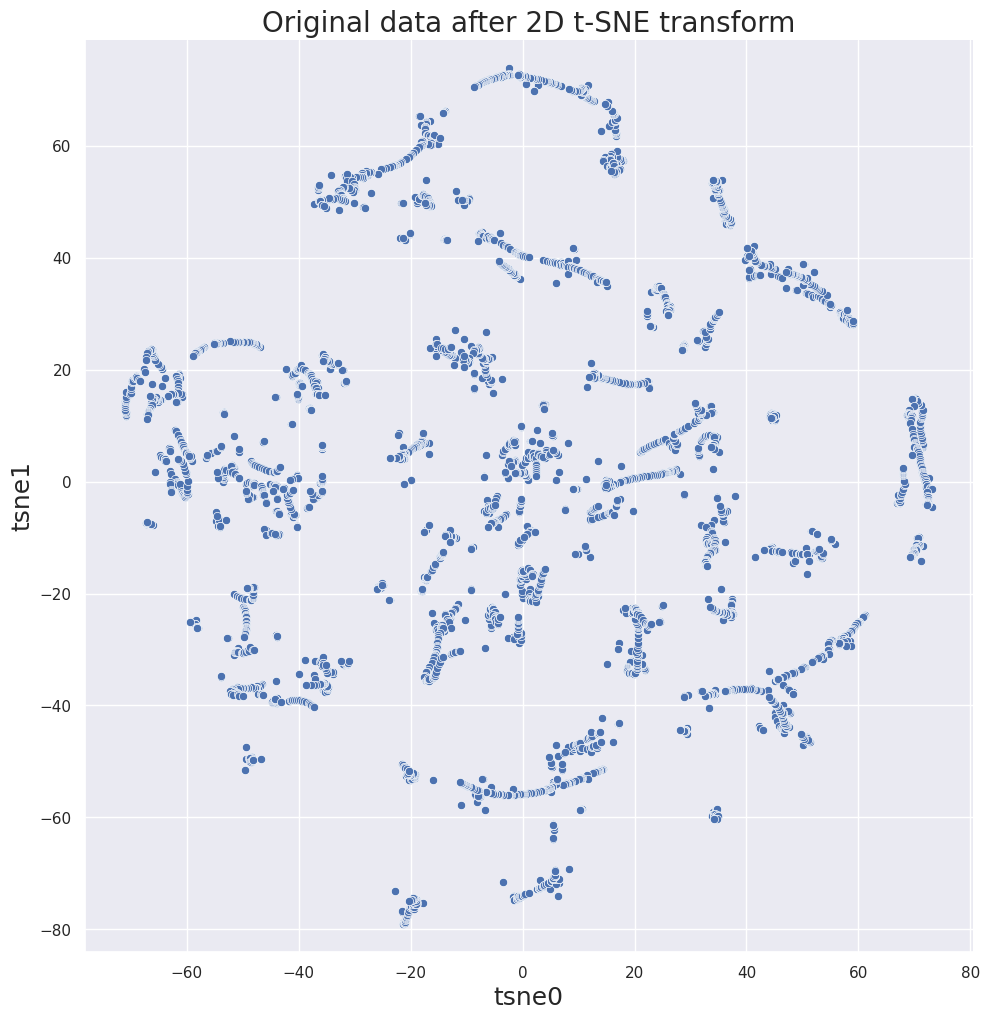

In [77]:
title = 'Original data after 2D t-SNE transform'
axes_TSNE_2D = {'x': 'tsne0', 'y': 'tsne1'}
Plot2D (samples_TSNE_2D, title, axes_TSNE_2D)

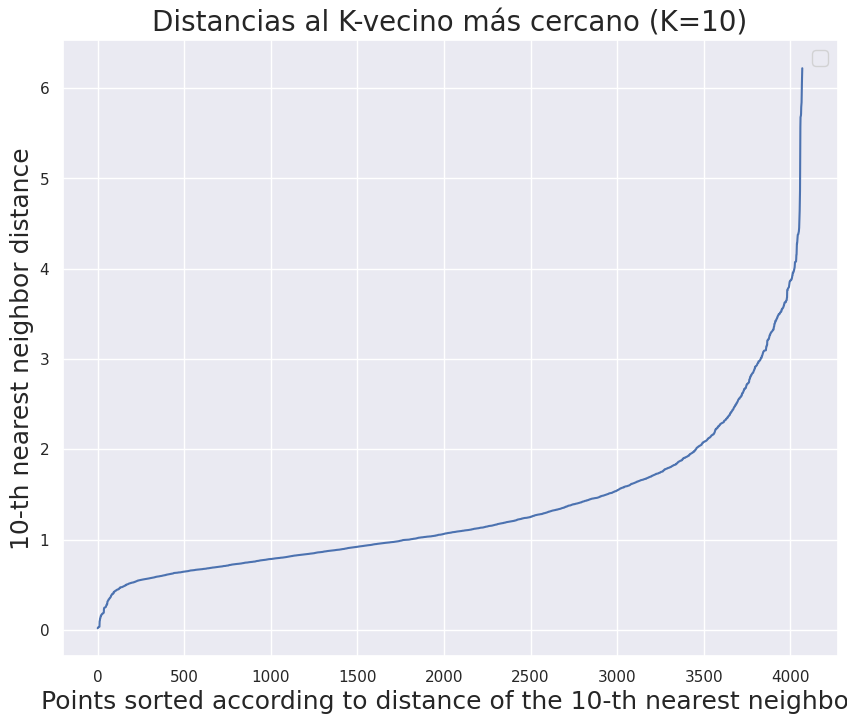

In [78]:
PlotDistancesToKnearestNeighbor(samples_TSNE_2D, 10) # notese que el parametro de entrada NO es samples

In [79]:
min_samples = 10
epsilon_values = [1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
aux_labels = {}
for epsilon in epsilon_values:
  aux_labels[epsilon] = ApplyDBScanToData (samples_TSNE_2D, epsilon, min_samples=min_samples)

epsilon = 3.25
labels_TSNE_2D = aux_labels[epsilon]


Test for epsilon = 1.25
Estimated number of clusters: 134
Estimated number of noise points: 922
Silhouette Coefficient: 0.328

Test for epsilon = 1.5
Estimated number of clusters: 119
Estimated number of noise points: 640
Silhouette Coefficient: 0.395

Test for epsilon = 1.75
Estimated number of clusters: 103
Estimated number of noise points: 460
Silhouette Coefficient: 0.405

Test for epsilon = 2
Estimated number of clusters: 87
Estimated number of noise points: 341
Silhouette Coefficient: 0.398

Test for epsilon = 2.25
Estimated number of clusters: 73
Estimated number of noise points: 278
Silhouette Coefficient: 0.385

Test for epsilon = 2.5
Estimated number of clusters: 69
Estimated number of noise points: 249
Silhouette Coefficient: 0.399

Test for epsilon = 2.75
Estimated number of clusters: 64
Estimated number of noise points: 163
Silhouette Coefficient: 0.408

Test for epsilon = 3
Estimated number of clusters: 60
Estimated number of noise points: 127
Silhouette Coefficient: 0.4

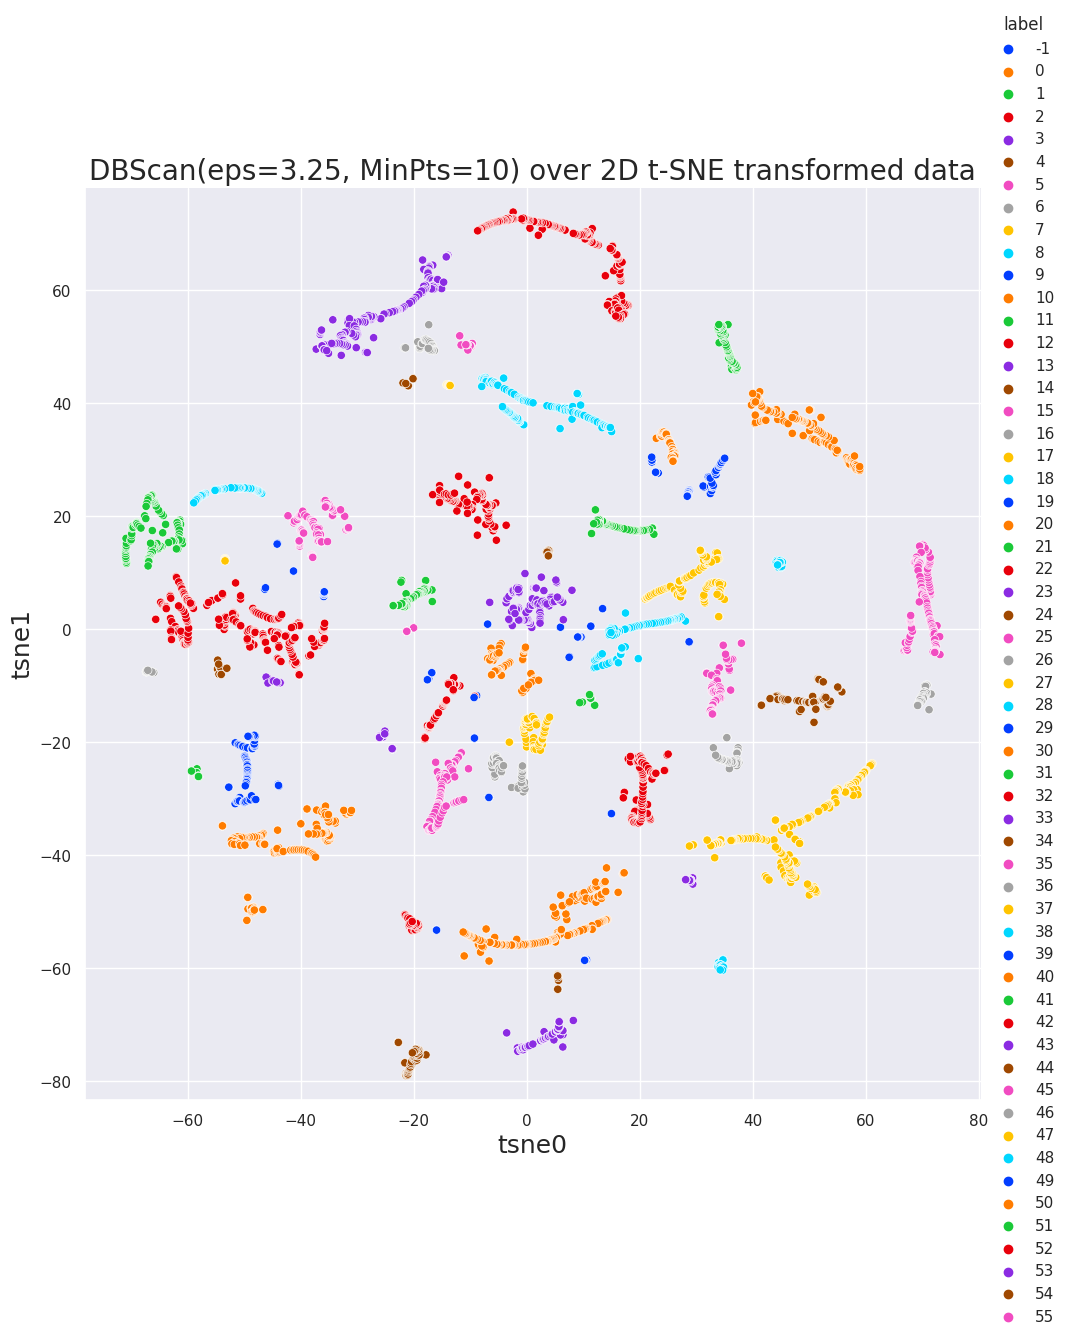

In [80]:
title = f'DBScan(eps={epsilon}, MinPts={min_samples}) over 2D t-SNE transformed data'
Plot2D_WithLabels (samples_TSNE_2D, labels_TSNE_2D, title, axes_TSNE_2D)

### [**Ejercicio 3]**
Tomando como punto de partida los ejemplos anteriores y la documentación del procedimiento "TSNE" (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) escriba a continuación el código necesario para:
* llevar a cabo una transformación t-SNE 3D de los datos,
* aplicar sobre dicho espacio transformado el algoritmo DBSCAN,
* y visualizar gráficamente el resultado.

In [81]:
# Teclee su código aquí

## 7.5. Técnicas de clustering alternativas

### K-Means sobre PCA 2D

In [82]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_PCA_2D)
labels_kmeans_PCA_2D = kmeans.labels_
labels_kmeans_PCA_2D

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [83]:
centroids_kmeans_PCA_2D = kmeans.cluster_centers_
centroids_kmeans_PCA_2D

array([[ 3.64100716,  0.40098693],
       [14.91065498, -0.52021521],
       [-5.9239765 , -0.14025314]])

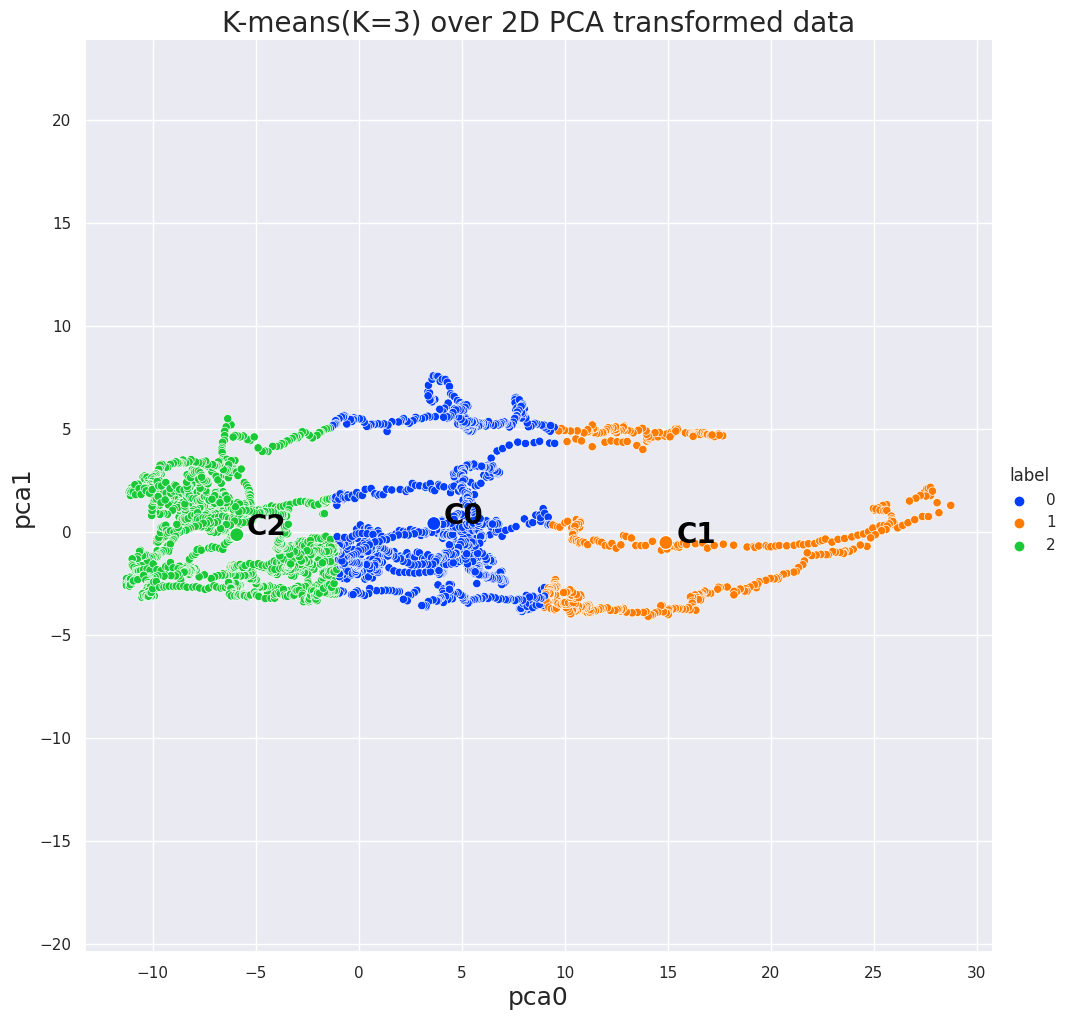

In [84]:
title = f'K-means(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels (samples_PCA_2D, labels_kmeans_PCA_2D, title, axes_PCA_2D, centroids_2D=centroids_kmeans_PCA_2D)

### K-Means sobre PCA 3D

In [85]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(samples_PCA_3D)
labels_kmeans_PCA_3D = kmeans.labels_
labels_kmeans_PCA_3D

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [86]:
centroids_kmeans_PCA_3D = kmeans.cluster_centers_
centroids_kmeans_PCA_3D

array([[ 3.52220105,  0.39797273, -0.37385296],
       [14.79666136, -0.55062481,  0.6254545 ],
       [-5.97747104, -0.1325811 ,  0.09811927]])

In [87]:
centroids_kmeans_PCA_3D


array([[ 3.52220105,  0.39797273, -0.37385296],
       [14.79666136, -0.55062481,  0.6254545 ],
       [-5.97747104, -0.1325811 ,  0.09811927]])

In [88]:
title = f'K-means(K={n_clusters}) over 3D PCA transformed data'
plot = Plot3D_WithLabels (samples_PCA_3D, labels_kmeans_PCA_3D, title, axes_PCA_3D, centroids_3D=centroids_kmeans_PCA_3D)

<ipython-input-5-bc98db8e206f>:345: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



### [Ejercicio 4]
Tomando como punto de partida los ejemplos anteriores y la documentación del procedimiento "Kmeans" (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) escriba a continuación el código necesario para encontrar un valor K para el número de clusters objetivo que resulte más adecuado para nuestros datos transformados vía PCA a 2 y 3 dimensiones respectivamente. Visualice gráficamente el resultado.

In [89]:
# Teclee su código aquí

### EM sobre PCA 2D

In [90]:
n_clusters = 5
gm_2D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_PCA_2D)
labels_EM_PCA_2D = gm_2D.predict(samples_PCA_2D)
labels_EM_PCA_2D

array([0, 0, 0, ..., 4, 4, 4])

In [91]:
centroids_EM_PCA_2D = gm_2D.means_
centroids_EM_PCA_2D

array([[-2.15659535, -1.52863614],
       [ 7.30962671,  5.31220747],
       [ 5.77515823, -0.8981075 ],
       [19.85077343, -1.58974853],
       [-7.84922595,  0.7715401 ]])

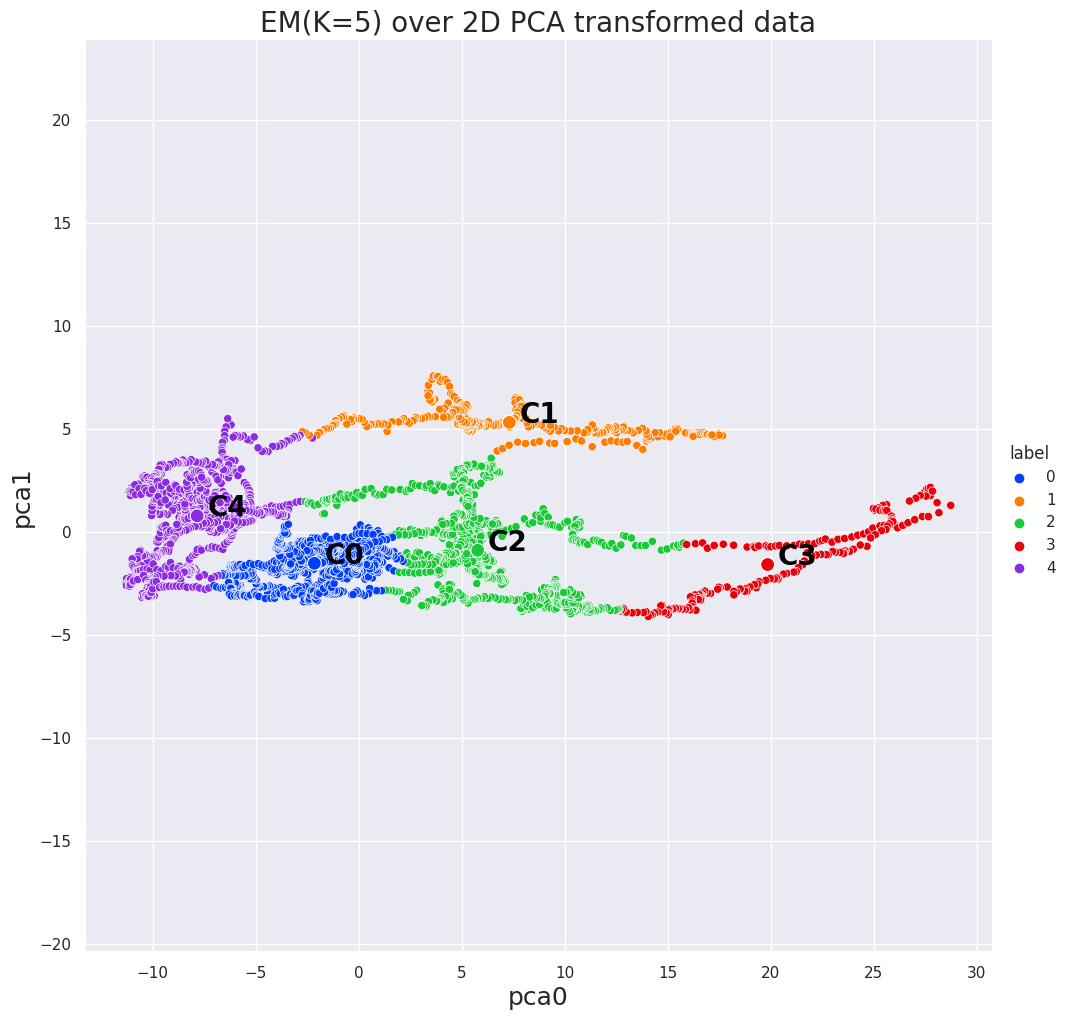

In [92]:
title = f'EM(K={n_clusters}) over 2D PCA transformed data'
plot = Plot2D_WithLabels (samples_PCA_2D, labels_EM_PCA_2D, title, axes_PCA_2D, centroids_2D=centroids_EM_PCA_2D)

### EM sobre PCA 3D

In [93]:
n_clusters = 7
gm_3D = GaussianMixture(n_components=n_clusters, random_state=0).fit(samples_PCA_3D)
labels_EM_PCA_3D = gm_3D.predict(samples_PCA_3D)
labels_EM_PCA_3D

array([3, 3, 3, ..., 4, 4, 4])

In [94]:
centroids_EM_PCA_3D = gm_3D.means_
centroids_EM_PCA_3D

array([[-1.87029675, -1.25025873, -1.77517216],
       [ 9.72260286,  5.04278817, -0.333644  ],
       [-6.32274919, -2.4746222 ,  0.85331373],
       [ 6.70183776, -2.07353636,  0.85590975],
       [-7.81214059,  1.30408886,  1.17075855],
       [19.67659753, -1.60447759,  1.20878945],
       [ 1.78981285,  2.20475749, -0.81797005]])

In [95]:
title = f'EM(K={n_clusters}) over 3D PCA transformed data'
plot = Plot3D_WithLabels (samples_PCA_3D, labels_EM_PCA_3D, title, axes_PCA_3D, centroids_3D=centroids_EM_PCA_3D)

<ipython-input-5-bc98db8e206f>:345: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



# Paso 8) Hacia la interpretación de los clusters

**Multimode**

Estamos utilizando Python 3.6 por lo que no está definida la función multimode en statistics, únicamente mode.

En caso de encotrar varios elementos con igual frecuencia, saltará error, por ello creamos multimode.


In [96]:
def multimode(data):
  freqs = groupby(Counter(data).most_common(), lambda x:x[1])
  return [val for val,count in next(freqs)[1]]

**Get statistics**

In [97]:
def get_statistics(cluster, id_cluster, name_dimension):
  for id in id_cluster:
    mean_aux   = statistics.mean(cluster[id+1].flatten())
    median_aux = statistics.median(cluster[id+1].flatten())
    var_aux    = statistics.variance(cluster[id+1].flatten())
    mode_aux   = multimode(cluster[id+1].flatten())
    stdev_aux  = statistics.stdev(cluster[id+1].flatten())

    print((f"Cluser {name_dimension} id: %d, mean: %.2f, variance %.2f, median: %.2f, mode: {mode_aux}, std_dev = %.2f" % (id, mean_aux, var_aux, median_aux, stdev_aux)))

In [98]:
def CreateDictFromArrayAndLabels(input_array, input_labels):
  """
    Parameters:
      input_array: numpy.ndarray de elementos
      input_labels: numpy.ndarray de etiquetas correspomndientes a dichos elementos
  """

  values_labels, k = np.unique(input_labels, return_counts=True) # Recuperamos el conjunto de ids únicos que identifican a nuestros clusters
  label_key_list = list(map(str, values_labels)) # Con ellos componemos una lista de claves a partir de la cual crearemos el citado di

  print('[CreateDictFromArrayAndLabels]')
  print('\n[List of unique keys]')
  for i in range(len(label_key_list)):
    print('\t[key %d][value = %s]' % (i, label_key_list[i]))

  dict_of_lists = {}
  for j in label_key_list:
    dict_of_lists[j] = []

  print('\n[Initiating new dict]')
  print(dict_of_lists)

  array_dims = input_array.shape
  n_samples = array_dims[0]

  print('\n[Processing %d samples]' % n_samples)
  if len(array_dims) == 2:
    n_dim_per_sample = n_samples = array_dims[1]
    print('\t[Samples have more than 1 dim (%d dims per sample)]' % n_dim_per_sample)

  aux = 0

  #for i in input_labels: # Procesamos todos los vectores de caracteristicas
  #  print(i)

  #aux = [0]*8
  #for i in range(input_labels.size): # Procesamos todos los vectores de caracteristicas
  #  aux[input_labels[i]] = aux[input_labels[i]] + 1

  #for i in range(len(aux)):
  #  print('%d (total = %d)' % (i, aux[i]))


  #for idx, j in enumerate(input_array):
  #  print(j)
  #  print('idx = %d' % (idx))

  num_samples_per_key = [0] * len(label_key_list)
  #for i in range(n_samples): # Procesamos todos los vectores de caracteristicas
  for i, item in enumerate(input_array): # Procesamos todos los vectores de caracteristicas
    key = str(input_labels[i]) # Para cada uno recuperamos su key, su etiqueta correspondiente (i.e. el id del cluster al que ha sido asignado)
    dict_of_lists[key].append(item) # Añadimos el vector a su entrada especifica del diccionario
    num_samples_per_key[input_labels[i]] = num_samples_per_key[input_labels[i]] + 1

  print('\n[Summary]')
  for i in range(len(label_key_list)):
    print('\t[key %d][value = %s][total = %d samples]' % (i, label_key_list[i], num_samples_per_key[i]))

  new_dict = {}
  for key in label_key_list:
    new_dict[key] = np.array(dict_of_lists[key])
    #new_dict[key] = np.append(new_dict[key], input_array[i]) # Añadimos el vector a su entrada especifica del diccionario

  # El siguiente bloque de codigo simplemente elimina el item 'None' con el que inicialmente se crea la entrada correspondiente a cada clave en el diccionario
  #for k in range(len(label_key_list)):
  #  new_dict[label_key_list[k]] = np.delete(new_dict[label_key_list[k]],[0])
  #  if len(array_dims) == 2:
  #    new_dict[label_key_list[k]] = np.reshape(new_dict[label_key_list[k]], (-1, n_dim_per_sample))

  return new_dict

In [99]:
len(labels)

4070

In [100]:
n_nodes = len(df_sensor.Name.unique()) # n_nodes = 63

In [101]:
n_nodes

63

In [102]:
temp_samples = samples[:, [0+i*3 for i in range(n_nodes)]] # temp_vector
humd_samples = samples[:, [1+i*3 for i in range(n_nodes)]]
pres_samples = samples[:, [2+i*3 for i in range(n_nodes)]]

In [103]:
len(temp_samples)

4070

In [104]:
clusters_temp = [temp_samples[labels == id] for id in range(-1,14)]
clusters_humd = [humd_samples[labels == id] for id in range(-1,14)]
clusters_pres = [pres_samples[labels == id] for id in range(-1,14)]

In [105]:
temp_samples

array([[-0.31809939, -0.30118775, -0.02872245, ...,  0.3583662 ,
         1.03671085,  2.19421864],
       [-0.33501103, -0.30118775, -0.05315037, ...,  0.3583662 ,
         0.99912943,  2.07583716],
       [-0.33501103, -0.28803425, -0.02872245, ...,  0.3452127 ,
         0.94839451,  2.07583716],
       ...,
       [-0.48157857, -0.50788557, -0.51540185, ...,  0.14603116,
         0.39782669,  1.62861824],
       [-0.48157857, -0.50788557, -0.53231349, ...,  0.16106373,
         0.39782669,  1.62861824],
       [-0.48157857, -0.50788557, -0.50788557, ...,  0.16106373,
         0.39782669,  1.62861824]])

In [106]:
temp_samples[labels == 2]

array([[-0.34816453, -0.32561568, -0.06630387, ...,  0.23998472,
         0.80370604,  1.98752082],
       [-0.34816453, -0.32561568, -0.08697365, ...,  0.23998472,
         0.79431069,  1.97060918],
       [-0.35755988, -0.32561568, -0.11140157, ...,  0.23998472,
         0.79431069,  1.95369754],
       ...,
       [-0.37071338, -0.33125289, -0.10764343, ...,  0.23998472,
         0.77739905,  1.94430218],
       [-0.37071338, -0.34440639, -0.10764343, ...,  0.23998472,
         0.77739905,  1.94430218],
       [-0.37071338, -0.34440639, -0.10764343, ...,  0.23998472,
         0.77739905,  1.94430218]])

In [107]:
clusters_temp[0]

array([[-0.37822967, -0.32185753, -0.07006201, ...,  0.26629171,
         0.72102691,  2.01382781],
       [-0.37822967, -0.32185753, -0.08509458, ...,  0.25313822,
         0.72102691,  2.01382781],
       [-0.35568081, -0.30118775, -0.08509458, ...,  0.27004986,
         0.72102691,  2.01382781],
       ...,
       [-0.33876917, -0.50788557, -0.65633218, ...,  0.15730559,
         0.38655226,  1.62110196],
       [-0.46842508, -0.50788557, -0.62626705, ...,  0.16858002,
         0.38091505,  1.62110196],
       [-0.48157857, -0.50788557, -0.58492748, ...,  0.12911953,
         0.40722204,  1.63425546]])

In [108]:
len(clusters_temp)

15

## 8.1. Visualización de los histogramas resultantes para los diferentes clusters

**IMPORTANTE**: para realizar cualquiera de los siguientes estudios o análisis sobre los resultados obtenidos con cualquiera de las diferentes estrategias de clustering ensayadas, basta con asignar a la variable **labels** la variable que contenga el array con la lista de etiquetas o ids de los clusters resultantes para la estrategia en cuyo análisis estemos interesados.

In [109]:
labels = labels_EM_PCA_2D
#labels = labels_kmeans_PCA_2D

labels nos dice el cluster de cada ejemplo. Tenemos 4070 ejemplos
Cada ejemplo tiene 63 sensores, por lo tanto los primeros 63 ejemplos pertenecen al cluster indicado en label[0], los siguientes 63 en label[1].

In [110]:
(unique, counts) = np.unique(labels, return_counts=True)

print('Esta es la distribución de muestras disponibles para cada cluster')
for i in range(len(unique)):
  print('[cluster = %s][%d samples]' % (unique[i], counts[i]))
print('----------------------------')
print('[ALL][%d samples]\n' % (len(labels)))

Esta es la distribución de muestras disponibles para cada cluster
[cluster = 0][1248 samples]
[cluster = 1][396 samples]
[cluster = 2][986 samples]
[cluster = 3][185 samples]
[cluster = 4][1255 samples]
----------------------------
[ALL][4070 samples]



In [111]:
values_labels, k = np.unique(labels, return_counts=True) # Recuperamos el conjunto de ids únicos que identifican a nuestros clusters
label_key_list = list(map(str, values_labels)) # Con ellos componemos una lista de claves a partir de la cual crearemos el citado diccionario

In [112]:
label_key_list

['0', '1', '2', '3', '4']

Recordemos que **"df_sensor"** es un dataframe en el que cada fila corresponde a la medida realizada por un determinado sensor en un determinado instante:

In [113]:
df_sensor

Name     timestamp  Outlet  temperature  humidity  pressure
0       node_441  1.601457e+09       1         2940        38   9469914
1       node_440  1.601457e+09       1         2949        38   9450785
2       node_439  1.601457e+09       1         3094        36   9454878
3       node_396  1.601457e+09       1         3421        30   9456506
4       node_395  1.601457e+09       1         3536        28   9465874
...          ...           ...     ...          ...       ...       ...
256405  node_419  1.603902e+09       1         3029        36   9510119
256406  node_418  1.603902e+09       1         2711        42   9499704
256407  node_417  1.603902e+09       1         3195        33   9535832
256408  node_416  1.603902e+09       1         3321        32   9506282
256409  node_415  1.603902e+09       1         3976        24   9520996

[256410 rows x 6 columns]

Vamos a añadir a dicho dataframe una nueva columna con la información de la etiqueta correspondiente al cluster al que dicha medida ha sido asignada como resultado del clustering:

In [114]:
n_nodes = 63
labels_per_node = np.repeat(labels, n_nodes) # Primero, como cada instante de medida afecta a los 63 nodos o sensores de que disponemos debemos repetir cada label 63 veces, 1 por cada sensor

In [115]:
len(labels_per_node)

256410

In [116]:
df_sensor_clustered = df_sensor.copy() # We create a copy of the original dataframe
df_sensor_clustered["cluster"] = labels_per_node # We add a new column with the corresponding cluster info for each sample
df_sensor_clustered['temperature'] = df_sensor_clustered['temperature'].div(100).round(2)
df_sensor_clustered['pressure'] = df_sensor_clustered['pressure'].div(10000).round(2)
df_sensor_clustered

Name     timestamp  Outlet  temperature  humidity  pressure  \
0       node_441  1.601457e+09       1        29.40        38    946.99   
1       node_440  1.601457e+09       1        29.49        38    945.08   
2       node_439  1.601457e+09       1        30.94        36    945.49   
3       node_396  1.601457e+09       1        34.21        30    945.65   
4       node_395  1.601457e+09       1        35.36        28    946.59   
...          ...           ...     ...          ...       ...       ...   
256405  node_419  1.603902e+09       1        30.29        36    951.01   
256406  node_418  1.603902e+09       1        27.11        42    949.97   
256407  node_417  1.603902e+09       1        31.95        33    953.58   
256408  node_416  1.603902e+09       1        33.21        32    950.63   
256409  node_415  1.603902e+09       1        39.76        24    952.10   

        cluster  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
256405        4  
256406        4  
256407        4  
256408        4  
256409        4  

[256410 rows x 7 columns]

Text(0.5, 0.98, 'Temperature density distribution per cluster')

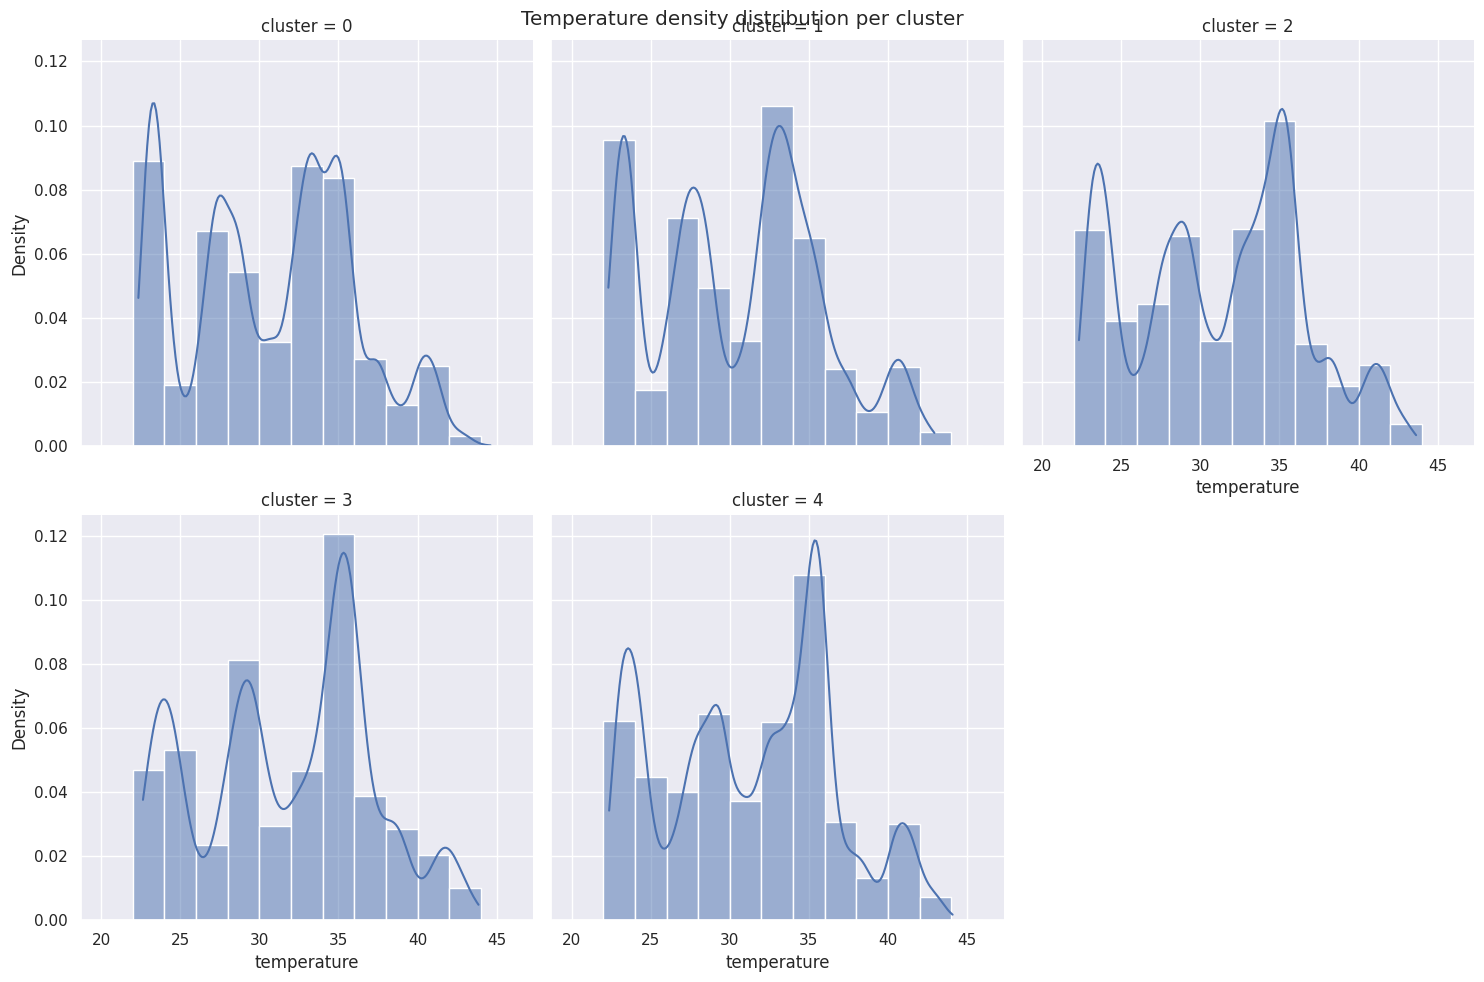

In [117]:
g = sns.FacetGrid(df_sensor_clustered, col="cluster", height=5, col_wrap=3)
g.map_dataframe(sns.histplot, x="temperature", stat='density', binwidth=2, binrange=(20, 45), kde = True)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Temperature density distribution per cluster')

Text(0.5, 0.98, 'Humidity density distribution per cluster')

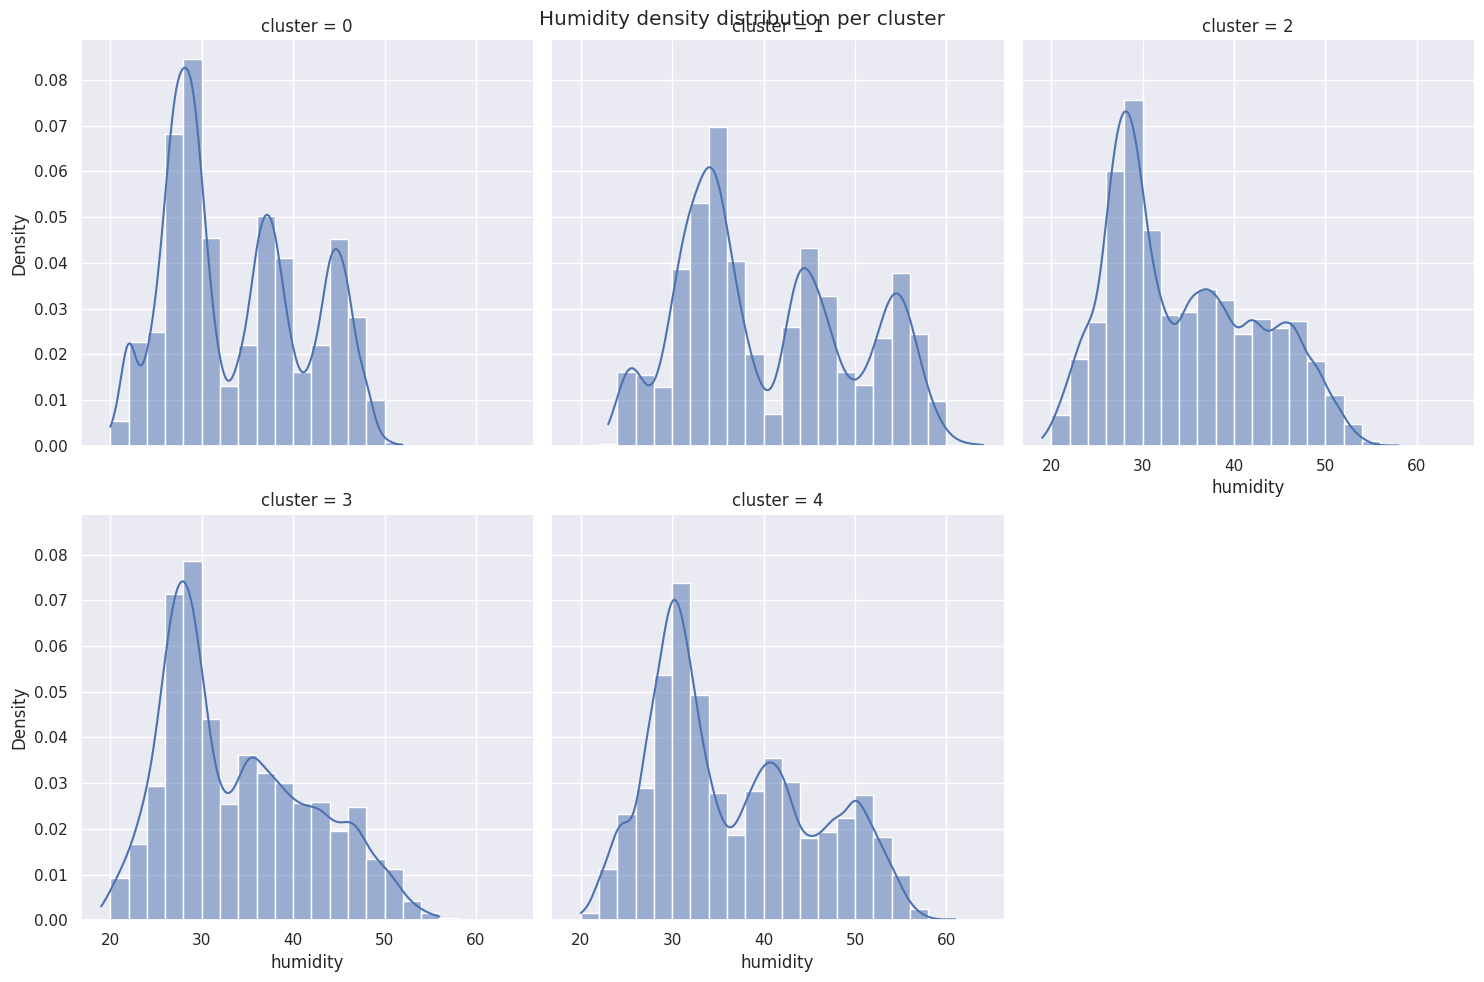

In [118]:
g = sns.FacetGrid(df_sensor_clustered, col="cluster", height=5, col_wrap=3)
g.map_dataframe(sns.histplot, x="humidity", stat='density', binwidth=2, binrange=(20, 60), kde = True)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Humidity density distribution per cluster')

Text(0.5, 0.98, 'Pressure density distribution per cluster')

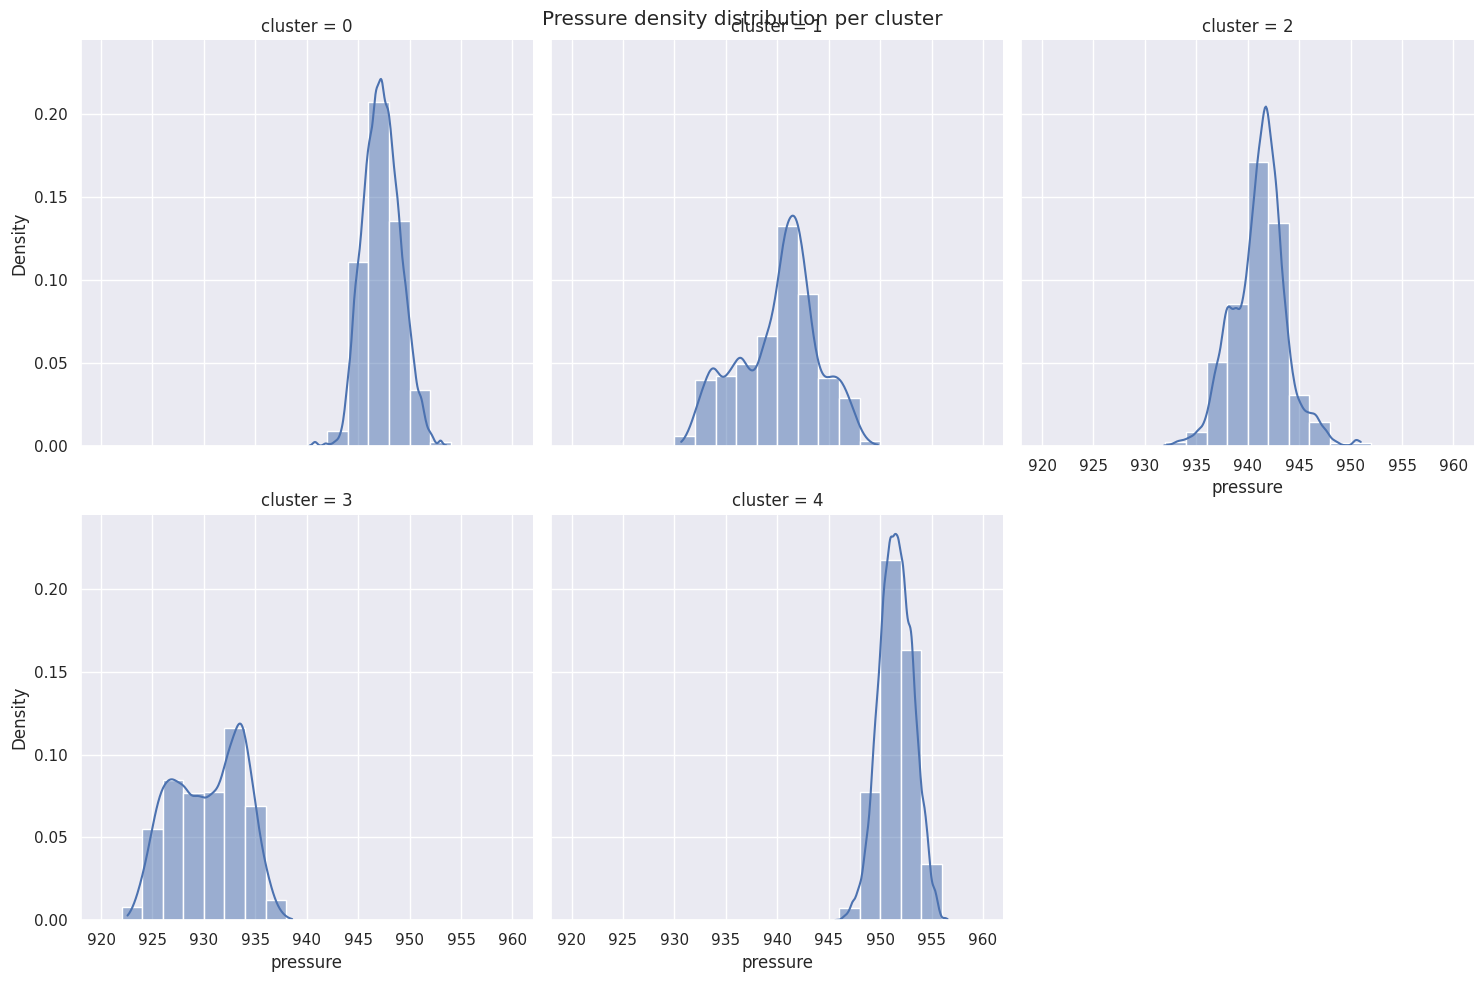

In [119]:
g = sns.FacetGrid(df_sensor_clustered, col="cluster", height=5, col_wrap=3)
g.map_dataframe(sns.histplot, x="pressure", stat='density', binwidth=2, binrange=(920, 960), kde = True)
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle('Pressure density distribution per cluster')

## 8.2. Estudio por franjas horarias


A continuación vamos a realizar un estudio del comportamiento de nuestro CPD a partir del resultado obtenido mediante el clustering y de la definición de las siguientes franjas horarias: "mañana"/"tarde"/"noche".

Cada una de esas 3 franjas copmprenderá **un periodo de 8 horas de duración**.
En particular, analizaremos el resultado de nuestro clustering de manera individualizada para cada franja.
Para ello, comenzaremos identificando todas las lecturas o muestras que pertenezcan a una misma franja a partir de la información recogida en el timestamp.

La idea fundamental es **determinar si existe algún cluster específico cuyas muestras sólo se observen en una franaja temporal determinada**.

In [120]:
# Comenzamos creando un dataframe cuyo contenido seran las marcas temporales (en formato HH:MM) de todas las medidas realizadas
selected_columns = df[["timeID"]]
df_time_id = selected_columns.copy()
df_time_id

timeID
0       11:00
1       11:00
2       11:00
3       11:00
4       11:00
...       ...
256405  17:20
256406  17:20
256407  17:20
256408  17:20
256409  17:20

[256410 rows x 1 columns]

In [121]:
"""
stripe_time(): Función que dada una determinada marca temporal devuelve un entero que indica la franja horaria a la que corresponde
"""
def stripe_time(time, t0, t1, t2):
  """
  Parameters:
    time (string): marca temporal cuya franja queremos obtener; se especifica en formato "hh:mm"
    t0 (entero): hora de comienzo de la primera franja
    t1 (entero): hora de comienzo de la segunda franja
    t2 (entero): hora de comienzo de la tercera franja

  """
  hh = int(time[:2]) # time en formato "hh:mm", nos quedamos solo con hh

  if (t0 <= hh < t1):
    return 0
  elif (t1 <= hh < t2):
    return 1
  else:
    return 2

In [122]:
4070*63


256410

**n_time_ids**: coincide con el número total de marcas temporales (i.e. 256410). Recuerde que cada marca se repite 63 veces pues la adquisición se realiza de forma simultánea para todos los nodos o sensores disponibles.

**n_samples**: coincide con el número de muestras o vectores de características (i.e. 4070). Recuerde que dichos vectores tienen una dimensión de 189 (i.e. **n_dim_per_sample** = 63 nodos x 3 magnitudes/nodo).

In [123]:
n_time_ids = df_time_id.shape[0]
n_samples, n_dim_per_sample = samples.shape
n_sensors = int(n_time_ids/n_samples)

print('[REMINDER][Trabajamos con %d nodos a partir de los cuales hemos obtenido un total de %d muestras o vectores de características]' % (n_sensors, n_samples))
print('[REMINDER][Cada vector de características tiene un total de %d dimensiones]' % (n_dim_per_sample))

np_time_id = df_time_id.to_numpy() # Converts the DataFrame to a NumPy array

[REMINDER][Trabajamos con 63 nodos a partir de los cuales hemos obtenido un total de 4070 muestras o vectores de características]
[REMINDER][Cada vector de características tiene un total de 189 dimensiones]


Con el siguiente fragmento de código procesamos todas las marcas temporales recuperando su franja horaria correspondiente.
En particular recuperaremos los siguientes identificadores:

0: para la franja de 8h que da comienzo a las 6 AM (i.e. mañana)

1: para la franja de 8h que da comienzo a las 14 PM (i.e. tarde)

2: para el resto (franja de 8h que da comienzo a las 22 PM y termina a las 6 AM, i.e. noche)

In [124]:
time_slots_list = []

for i in range(n_samples):
  hhmm = np_time_id[i*n_sensors][0] # Se repiten 63 veces cada una (una por nodo), tomamos 1 de cada 63
  #time_slots.append(stripe_time(hhmm, 0, 8, 16)) # Alternativa franjas 1
  time_slots_list.append(stripe_time(hhmm, 6, 14, 22)) # Alternativa franjas 2

time_slots_array = np.array(time_slots_list) # Convertimos la lista en un array numpy
time_slots_array = np.reshape(time_slots_array, (-1,1)) # Convertimos el array "fila" en un array "columna"
samples_with_time_slot = np.concatenate((samples, time_slots_array), axis = 1) # Completamos nuestra matriz numpy de vectores con una nueva columna con la info de la franja horaria
samples_with_time_slot.shape # Observe como ahora pasamos a tener filas (o vectores) con 190 columnas (las 189 mas la de la franja horaria)

(4070, 190)

El resultado es un array de numpy que incluye todos los vectores de características **"ampliados" con una dimensión extra correspondiente al identificador de la franja horaria a la pertenece dicha muestra**.

Visualizaremos el último elemento del array (i.e. la última muestra) a modo de ejemplo (recuerde que hay 3 posibles franjas horarios cuyos identificadores son 0, 1 y 2 respectivamente):

In [125]:
samples_with_time_slot.shape

(4070, 190)

In [126]:
samples_with_time_slot[-1:] # La ultima sample

array([[-0.48157857,  0.65903939,  1.04920911, -0.50788557,  0.54137402,
         0.75526824, -0.50788557,  0.65903939,  0.8105967 ,  0.14603116,
        -0.16461816,  0.84741504,  0.36776155, -0.39994889,  0.99499125,
         0.38467319, -0.39994889,  1.22143745, -0.52103907,  0.54137402,
         0.89794769, -0.70142989,  0.77670475,  0.95958642, -0.62814612,
         0.77670475,  0.96532456, -1.53761652,  1.83569303,  0.99504174,
        -1.46621182,  1.71802767,  0.73320753, -1.51694674,  1.83569303,
         0.96865639, -1.58083515,  1.71802767,  0.89136818, -1.08851853,
         1.12970085,  1.01807844, -0.5905647 ,  0.65903939,  0.93299915,
         0.38655226, -0.39994889,  0.94425667,  0.18737073, -0.28228353,
         0.90008477,  0.12348231, -0.16461816,  0.84256875,  0.27756614,
        -0.16461816,  1.17406835, -0.77095552,  0.89437012,  0.7848508 ,
         0.54063609, -0.51761426,  1.02645848,  1.11938998, -0.87061035,
         0.98974111,  0.63834779, -0.63527962,  0.8

Una vez contamos con la franja horaria a la que pertenece cada muestra, vamos a organizar esas muestras en una nueva estructura que nos permita realizar un análisis conjunto de las mismas, no sólo por franja horaria, sino también por cluster al que esas muestras pertencen.

Para ello, a continuacion crearemos un **diccionario** cuyas claves coincidirán con los ids de los clusters. En él guardaremos las muestras (i.e. los vectores de características junto con la información de franja horaria añadida) de manera que éstas quedarán organizadas y fácilmente accesibles simplemente a partir del id del cluster específico que queramos analizar (i.e. clave con la que "consultamos" nuestro diccionario).


In [127]:
samples_with_time_slot_cluster_dict = CreateDictFromArrayAndLabels(samples_with_time_slot, labels)

[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][value = 0]
	[key 1][value = 1]
	[key 2][value = 2]
	[key 3][value = 3]
	[key 4][value = 4]

[Initiating new dict]
{'0': [], '1': [], '2': [], '3': [], '4': []}

[Processing 4070 samples]
	[Samples have more than 1 dim (190 dims per sample)]

[Summary]
	[key 0][value = 0][total = 1248 samples]
	[key 1][value = 1][total = 396 samples]
	[key 2][value = 2][total = 986 samples]
	[key 3][value = 3][total = 185 samples]
	[key 4][value = 4][total = 1255 samples]


Acabamos de crear nuestro diccionario de muestras indexable a nivel de cluster y que contiene para cada muestra la información correspondiente a su franja horaria.

Por ejempo, podemos visualizar las muestras del tercer cluster mediante el siguiente comando (recuerde que los clusters se enumeran a partir del 0):

In [128]:
samples_with_time_slot_cluster_dict[str(3)] # Nota: usamos claves con tipo str

array([[-0.32185753,  0.42370866, -1.88250942, ..., -1.57660254,
        -1.75211397,  2.        ],
       [-0.32185753,  0.42370866, -1.88250942, ..., -1.45893717,
        -1.83653699,  2.        ],
       [-0.34440639,  0.42370866, -2.00982546, ..., -1.57660254,
        -1.88637972,  2.        ],
       ...,
       [-0.35192267, -0.0469528 , -1.48314496, ..., -1.6942679 ,
        -1.44075676,  0.        ],
       [-0.35192267, -0.0469528 , -1.48314496, ..., -1.6942679 ,
        -1.34675895,  0.        ],
       [-0.35192267, -0.0469528 , -1.48314496, ..., -1.6942679 ,
        -1.34675895,  0.        ]])

In [129]:
"""
sort_counts(): Función que devuelve un vector con las cuentas ordenadas según el id del cluster
"""
def sort_counts(unique, counts, n_expected_ids):
  """
  Parameters:
    unique (entero): array con los ids unicos para los que se han obtenido las cuentas
    counts (entero): cuentas correspondientes a los ids presentes en el array unique en identico orden (no necesariamente el adecuado)
    n_expected_ids (entero): puede ocurrir que no todos los ids buscados se encuentren en unique
  """
  n_labels = len(unique)
  n_counts = len(counts)

  sorted_counts = np.zeros(n_expected_ids)

  for i in range(n_labels):
    sorted_counts[int(unique[i])] = counts[i]

  return sorted_counts

A continuación, apoyándonos en el diccionario anteriormente creado y en la función "sort_counts" anteriormente definida, realizamos para cada cluster **el conteo específico de casos o muestras de dicho cluster que pertenecen a cada una de las franjas horarias definidas**:

In [130]:
n_clusters = len(label_key_list)

time_slots = ['Mañana', 'Tarde', 'Noche']
n_time_slots = len(time_slots)

n_samples_per_cluster_and_slot = np.zeros([n_clusters, n_time_slots]) # n_samples_per_cluster_and_slot: matriz con tantas filas como clusters y tantas conlumnas como franjas horarias

for k in range(n_clusters):
  unique, counts = np.unique(samples_with_time_slot_cluster_dict[label_key_list[k]][:,-1], return_counts=True) # Este comando recupera exclusivamente la dimension 190, la correspondiente al id del slot o franja
  n_samples_per_cluster_and_slot[k] = sort_counts(unique, counts, n_time_slots)
  print('\n[Cluster][%s]' % (label_key_list[k]))
  for j in range(n_time_slots):
    print('\t[%s][%d]' % (time_slots[j], n_samples_per_cluster_and_slot[k][j]))


[Cluster][0]
	[Mañana][434]
	[Tarde][403]
	[Noche][411]

[Cluster][1]
	[Mañana][108]
	[Tarde][144]
	[Noche][144]

[Cluster][2]
	[Mañana][289]
	[Tarde][356]
	[Noche][341]

[Cluster][3]
	[Mañana][73]
	[Tarde][48]
	[Noche][64]

[Cluster][4]
	[Mañana][454]
	[Tarde][414]
	[Noche][387]


In [131]:
  n_samples_per_cluster_and_slot

array([[434., 403., 411.],
       [108., 144., 144.],
       [289., 356., 341.],
       [ 73.,  48.,  64.],
       [454., 414., 387.]])

Finalmente, con la información obtenida podemos obtener el tipo de visualización con la que poder realizar el análisis deseado:

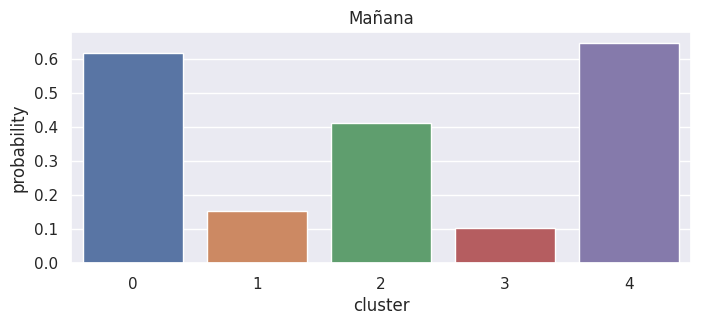

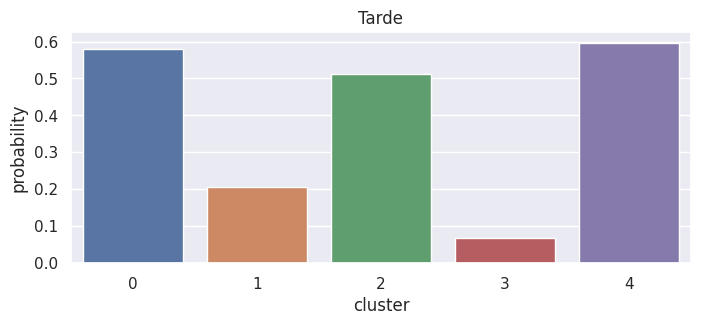

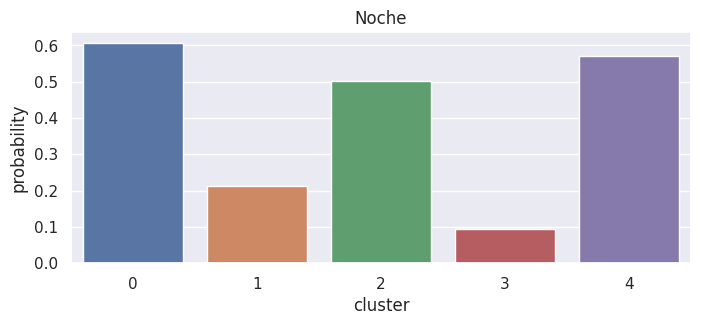

In [132]:
for time in range(n_time_slots):
  data = n_samples_per_cluster_and_slot[:,time]
  normalized_data = data/np.linalg.norm(data) # La normalización nos permite expresar la ocurrencia como una probabilidad, lo que facilita la posterior comparación

  fig, ax = plt.subplots(figsize=(8,3))
  ax = sns.barplot(y = normalized_data, x=label_key_list).set(title=time_slots[time], xlabel='cluster', ylabel='probability')
  plt.show()

Viendo los resultados se detecta que algunos cluster aparecen de forma más predominante en 2 periodos temporales. Esto nos hace pensar que realmente si tiene dependencia temporal, pero tal vez no la que hemos escogido. Para comprobarlo se realizará un barrido en las muestras para, posteriormente, comprobar la variación del número de datos en el cluster.

## 8.3. Estudio por cuartiles

Las listas "temp_samples, humd_samples, pres_samples" tienen la información de cada uno de los "fotogramas" medidos, por lo tanto haremos la media de cada "foto" y luego realizaremos el cálculo de los percentiles.


In [133]:
temp_samples = samples[:, [0+i*3 for i in range(n_nodes)]] # temp_vector
humd_samples = samples[:, [1+i*3 for i in range(n_nodes)]]
pres_samples = samples[:, [2+i*3 for i in range(n_nodes)]]

In [134]:
def calculate_percentile(percentage, temp_vect, humd_vect, press_vect):
  temp_quantile = np.percentile(temp_vect, percentage)
  humd_quantile = np.percentile(humd_vect, percentage)
  pres_quantile = np.percentile(press_vect, percentage)

  return temp_quantile, humd_quantile, pres_quantile

In [135]:
temp_samples_avg = np.mean(temp_samples, axis = 1)
humd_samples_avg = np.mean(humd_samples, axis = 1)
pres_samples_avg = np.mean(pres_samples, axis = 1)

In [136]:
# calculate quartil
temp_25, humd_25, pres_25 = calculate_percentile(25, temp_samples_avg, humd_samples_avg, pres_samples_avg)
temp_50, humd_50, pres_50 = calculate_percentile(50, temp_samples_avg, humd_samples_avg, pres_samples_avg)
temp_75, humd_75, pres_75 = calculate_percentile(75, temp_samples_avg, humd_samples_avg, pres_samples_avg)

print(f"Cuartil 1 (25%): temp: {temp_25}, humd: {humd_25}, pres: {pres_25}")
print(f"Cuartil 2 (50%): temp: {temp_50}, humd: {humd_50}, pres: {pres_50}")
print(f"Cuartil 3 (75%): temp: {temp_75}, humd: {humd_75}, pres: {pres_75}")

Cuartil 1 (25%): temp: -0.12084912430816368, humd: -0.2243846973347603, pres: -0.656156950797669
Cuartil 2 (50%): temp: -0.02908036353752821, humd: -0.08430688255086782, pres: 0.2053496415508035
Cuartil 3 (75%): temp: 0.1217672866119765, humd: 0.20145185960827308, pres: 0.8046738640128078


In [137]:
def assign_quartil_temp(measure):
  if (measure < temp_25):
    return 0
  elif (measure < temp_50):
    return 1
  elif (measure < temp_75):
    return 2
  else:
    return 3

def assign_quartil_humd(measure):
  if (measure < humd_25):
    return 0
  elif (measure < humd_50):
    return 1
  elif (measure < humd_75):
    return 2
  else:
    return 3

def assign_quartil_pres(measure):
  if (measure < pres_25):
    return 0
  elif (measure < pres_50):
    return 1
  elif (measure < pres_75):
    return 2
  else:
    return 3

In [138]:
# convertir medidas a cuartiles
temp_quart = np.vectorize(assign_quartil_temp)
humd_quart = np.vectorize(assign_quartil_humd)
pres_quart = np.vectorize(assign_quartil_pres)

temp_quart = temp_quart(temp_samples_avg)
humd_quart = humd_quart(humd_samples_avg)
pres_quart = pres_quart(pres_samples_avg)

In [139]:
def quartile_count(unique, counts):
  quartile_count = np.zeros(4)
  n_labels = len(unique)
  for i in range (n_labels):
    quartile_count[int(unique[i])] = counts[i]
  return quartile_count

In [140]:
label_key_list

['0', '1', '2', '3', '4']

In [141]:
len(temp_quart)

4070

In [142]:
# Convertimos los arrays de los cuartiles para cada muestra en diccionarios indexables por cluster
temp_quart_cluster_dict = CreateDictFromArrayAndLabels(temp_quart, labels)
humd_quart_cluster_dict = CreateDictFromArrayAndLabels(humd_quart, labels)
pres_quart_cluster_dict = CreateDictFromArrayAndLabels(pres_quart, labels)

[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][value = 0]
	[key 1][value = 1]
	[key 2][value = 2]
	[key 3][value = 3]
	[key 4][value = 4]

[Initiating new dict]
{'0': [], '1': [], '2': [], '3': [], '4': []}

[Processing 4070 samples]

[Summary]
	[key 0][value = 0][total = 1248 samples]
	[key 1][value = 1][total = 396 samples]
	[key 2][value = 2][total = 986 samples]
	[key 3][value = 3][total = 185 samples]
	[key 4][value = 4][total = 1255 samples]
[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][value = 0]
	[key 1][value = 1]
	[key 2][value = 2]
	[key 3][value = 3]
	[key 4][value = 4]

[Initiating new dict]
{'0': [], '1': [], '2': [], '3': [], '4': []}

[Processing 4070 samples]

[Summary]
	[key 0][value = 0][total = 1248 samples]
	[key 1][value = 1][total = 396 samples]
	[key 2][value = 2][total = 986 samples]
	[key 3][value = 3][total = 185 samples]
	[key 4][value = 4][total = 1255 samples]
[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][v

In [143]:
temp_quart_cluster_dict['3']

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 2])

In [144]:
def select_subplot_for_quartile(quartile):
  if (quartile==0):
    return 0,0
  elif (quartile==1):
    return 0,1
  elif (quartile==2):
    return 1,0
  else:
    return 1,1


*************************************
Temperature
*************************************
[Cluster   ][   0][   1][   2][   3][   4]
[Quartile 0][ 569][ 123][ 113][   0][ 213]
[Quartile 1][ 363][ 272][ 241][   0][ 141]
[Quartile 2][ 188][   1][ 390][  48][ 390]
[Quartile 3][ 128][   0][ 242][ 137][ 511]


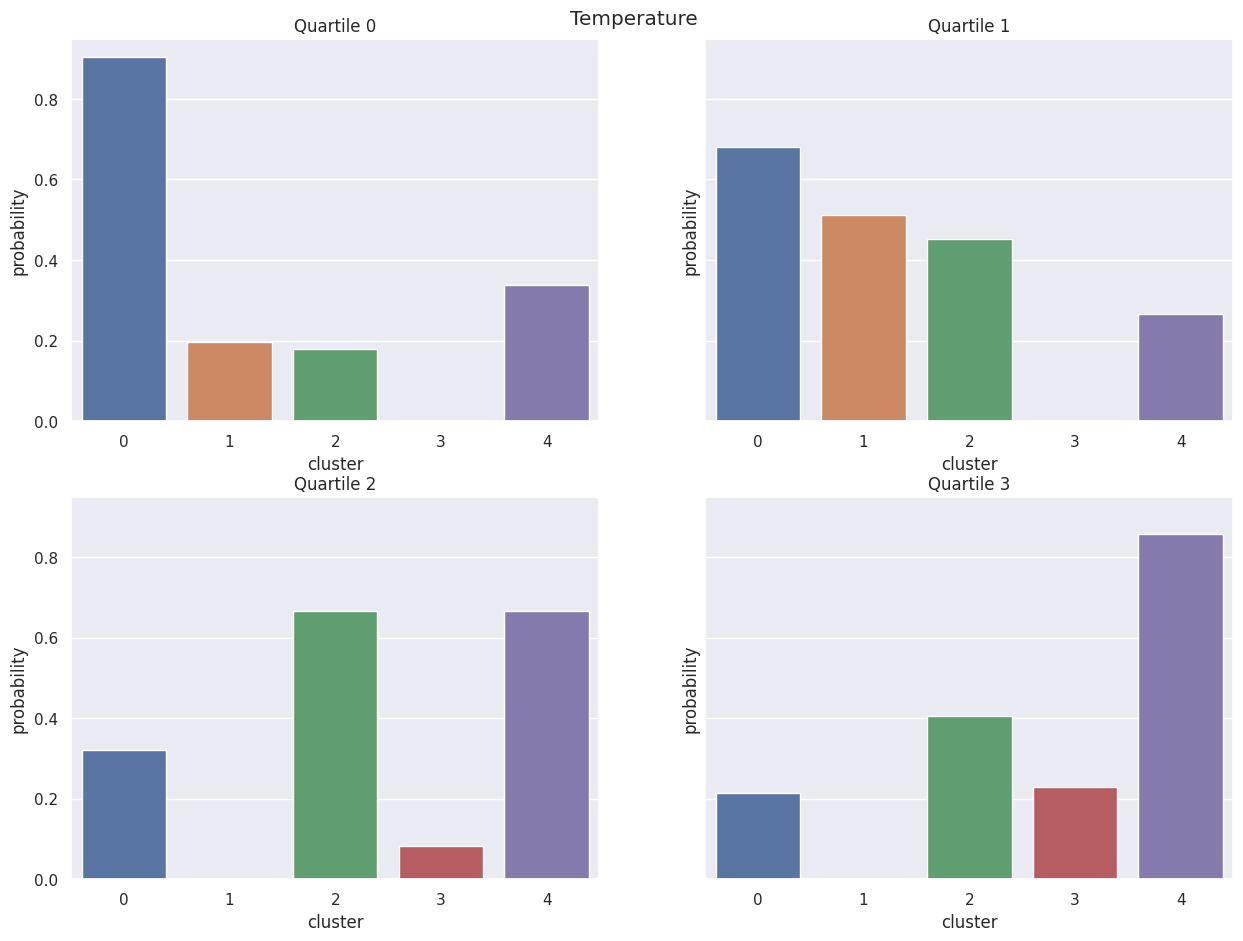


*************************************
Humidity
*************************************
[Cluster   ][   0][   1][   2][   3][   4]
[Quartile 0][ 479][   0][ 354][  89][  96]
[Quartile 1][ 686][   0][ 187][  23][ 121]
[Quartile 2][  83][   0][ 354][  66][ 514]
[Quartile 3][   0][ 396][  91][   7][ 524]


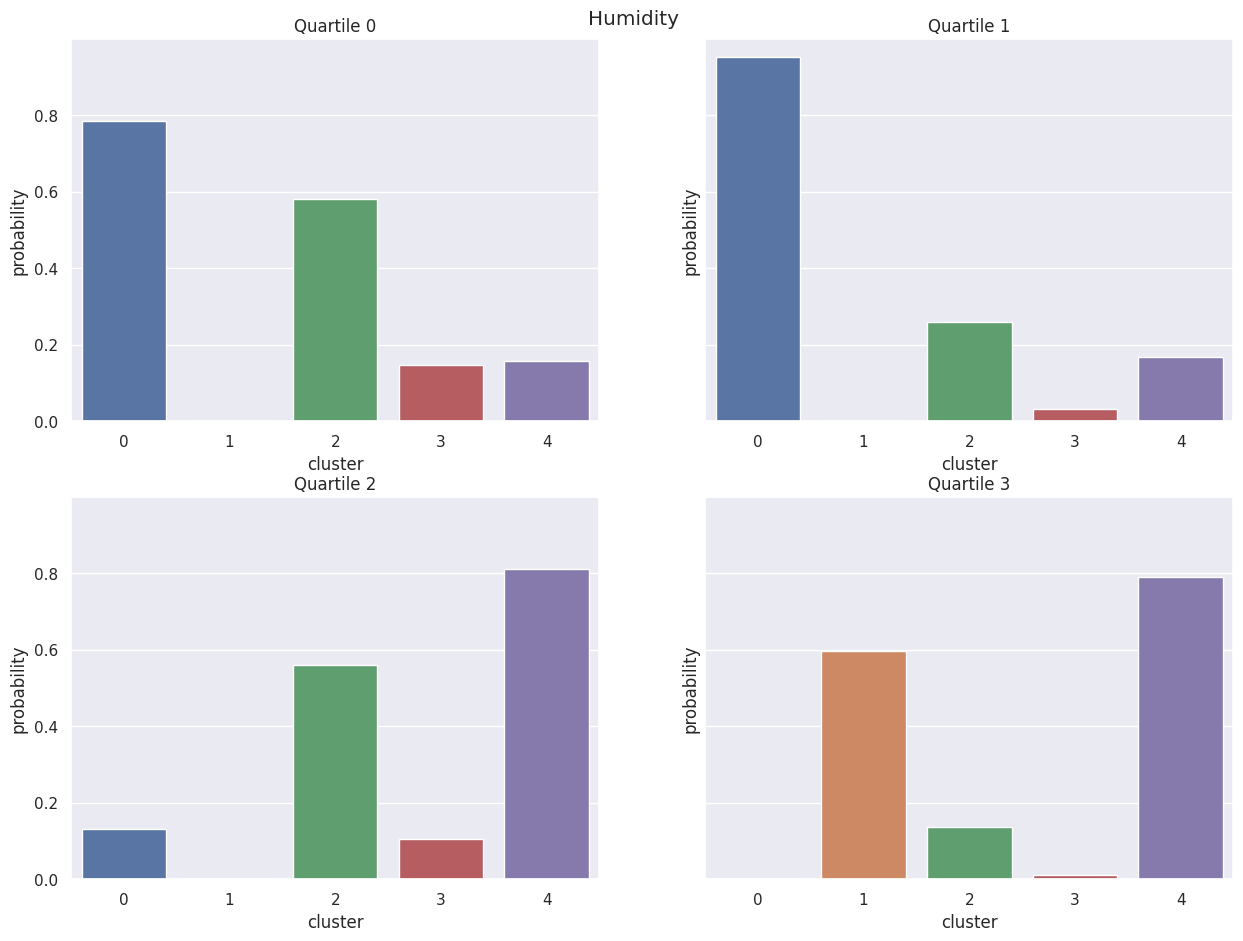


*************************************
Pressure
*************************************
[Cluster   ][   0][   1][   2][   3][   4]
[Quartile 0][   0][ 260][ 573][ 185][   0]
[Quartile 1][ 488][ 129][ 400][   0][   0]
[Quartile 2][ 748][   7][  13][   0][ 249]
[Quartile 3][  12][   0][   0][   0][1006]


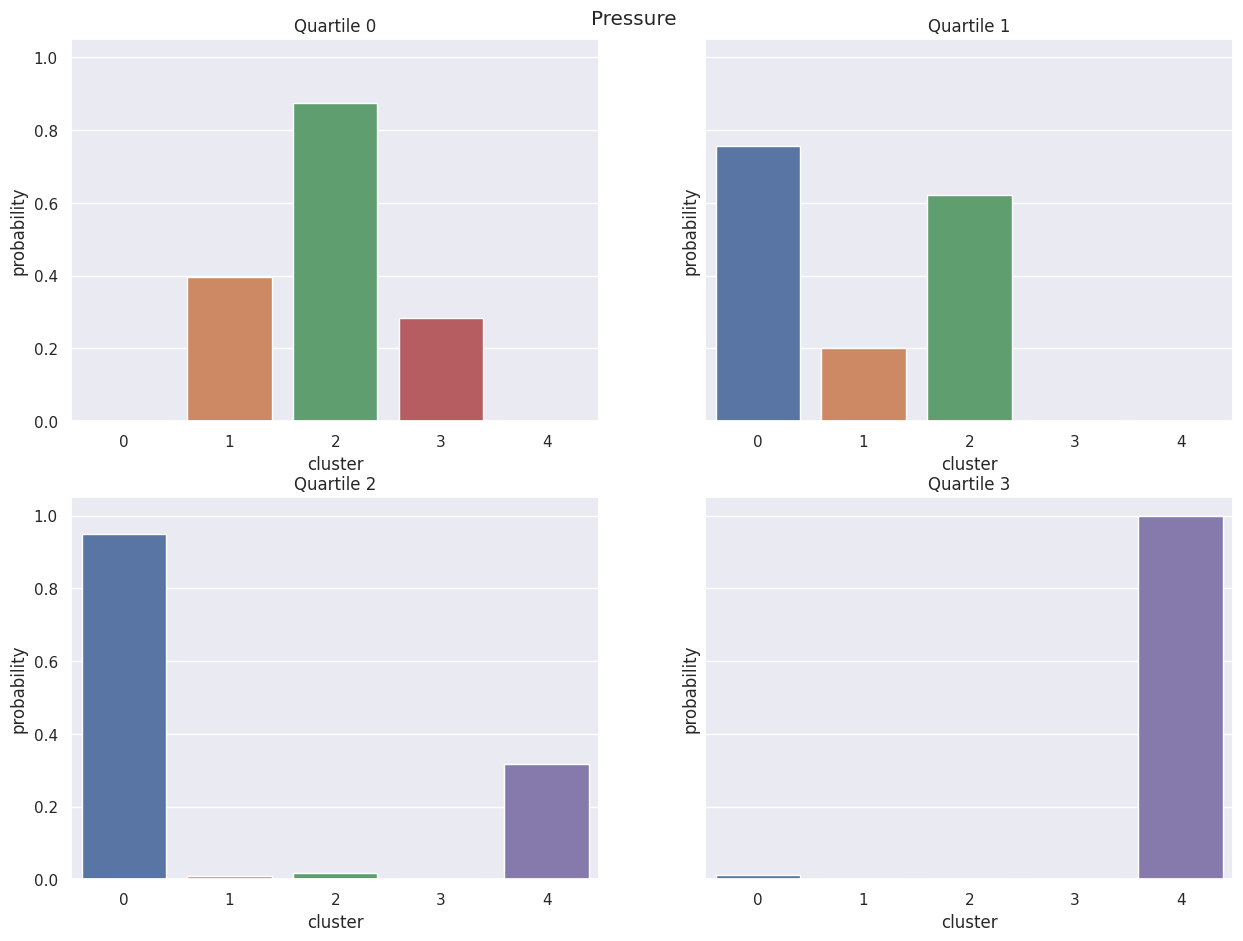

In [145]:
quartiles = ['Quartile 0', 'Quartile 1', 'Quartile 2', 'Quartile 3']
n_quartiles = len(quartiles)

titles = ['Temperature', 'Humidity', 'Pressure']
n_clusters = len(label_key_list)

list_of_dicts_to_display = [temp_quart_cluster_dict, humd_quart_cluster_dict, pres_quart_cluster_dict]
n_dicts_to_display = len(list_of_dicts_to_display)

n_samples_per_cluster_and_cuartile = np.zeros([n_clusters, n_quartiles]) #n_samples_per_cluster_and_cuartile: matriz con tantas filas como clusters y tantas columnas como cuartiles

for case in range(n_dicts_to_display):
  measure_data = list_of_dicts_to_display[case]

  fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True) # Para cada magnitud construiremos una representación con 4 subplots diferentes, 1 por cuartil, en forma de matriz 2x2
  fig.suptitle(titles[case])

  for k in range(n_clusters):
    unique, counts = np.unique(measure_data[label_key_list[k]], return_counts=True)
    n_samples_per_cluster_and_cuartile[k] = sort_counts(unique, counts, n_quartiles)

  # Los siguientes dos bucles son simplemente para pintar la tabla con todos los datos
  print(f"\n*************************************\n{titles[case]}\n*************************************")

  aux_line = '[Cluster   ]'
  for k in range(n_clusters):
    aux_line += '[%4d]' % k
  print(aux_line)

  for j in range(n_quartiles):
    aux_line = '[Quartile %d]' % j
    for k in range(n_clusters):
      aux_line += '[%4d]' % n_samples_per_cluster_and_cuartile[k][j]
    print(aux_line)

  # Aquí es dónde ocurre la magia y se obtienen las figuras en las que podemos apoyar el análisis
  for q in range(n_quartiles):
    data = n_samples_per_cluster_and_cuartile[:,q]
    normalized_data = data/np.linalg.norm(data) # La normalización nos permite expresar la ocurrencia como una probabilidad, lo que facilita la posterior comparación
    i1,i2 = select_subplot_for_quartile(q)
    fig.subplots_adjust(top=0.95)
    sns.barplot(ax=axes[i1,i2], y = normalized_data, x = label_key_list).set(title=quartiles[q], xlabel='cluster', ylabel='probability')

  plt.show()

## 8.4. Representación del resultado del clustering en modelo de sala 3D

Una interpretación muy interesante del resultado del clustering consiste en entender que los clusters identificados corresponden en realidad a **los diferentes estados o situaciones en las que puede encontrarse la sala**. En el presente apartado aprovecharemos algunas herramientas desarrolladas con el objetivo de poder realizar una representación 3D de la sala en la que podamos visualizar y, por tanto, entender mejor **desde un punto de vista espacial** el significado o alcance de dichos estados. Para ello, construiremos diferentes representaciones a partir de las muestras específicamente asignadas a cada cluster o estado. De este modo, podremos observar cómo varían la temperatura, la humedad y la presión a lo largo y ancho de la sala de manera individualizada para cada cluster (o estado).

Queremos realizar la impresión 3D de la situación media de cada cluster. Para ello:  

1.   Calcular el vector medio de cada cluster (63 nodos)
2.   Obtener el vector temperatura, humedad y presión de cada cluster (63 posiciones)
3.   Identificar en función del orden, la ubicación de cada punto en el espacio (sabemos que están los datos ordenados en función de x,y,z.
4.   Realizar una interpolación (por ejemplo kriging) del espacio total (3D).
5.   Representar con pyplot el mapa 3D. Si es posible poner puntos más gordos o más opacos para los puntos reales, y más suaves para los simulados. Identificar con colores claros cada valor, por ejemplo, en temperatura rojo = más valor.




### Preparación de los valores a representar en el modelo

In [146]:
temp_samples_cluster_dict = CreateDictFromArrayAndLabels(temp_samples, labels)
humd_samples_cluster_dict = CreateDictFromArrayAndLabels(humd_samples, labels)
pres_samples_cluster_dict = CreateDictFromArrayAndLabels(pres_samples, labels)

[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][value = 0]
	[key 1][value = 1]
	[key 2][value = 2]
	[key 3][value = 3]
	[key 4][value = 4]

[Initiating new dict]
{'0': [], '1': [], '2': [], '3': [], '4': []}

[Processing 4070 samples]
	[Samples have more than 1 dim (63 dims per sample)]

[Summary]
	[key 0][value = 0][total = 1248 samples]
	[key 1][value = 1][total = 396 samples]
	[key 2][value = 2][total = 986 samples]
	[key 3][value = 3][total = 185 samples]
	[key 4][value = 4][total = 1255 samples]
[CreateDictFromArrayAndLabels]

[List of unique keys]
	[key 0][value = 0]
	[key 1][value = 1]
	[key 2][value = 2]
	[key 3][value = 3]
	[key 4][value = 4]

[Initiating new dict]
{'0': [], '1': [], '2': [], '3': [], '4': []}

[Processing 4070 samples]
	[Samples have more than 1 dim (63 dims per sample)]

[Summary]
	[key 0][value = 0][total = 1248 samples]
	[key 1][value = 1][total = 396 samples]
	[key 2][value = 2][total = 986 samples]
	[key 3][value = 3][total = 185 samples]


Básicamente, obtendremos un modelo o representación específica para cada cluster en la que **el valor que vamos a representar para cada nodo o sensor es el resultado de calcular el valor medio a partir de todos los valores registrados por ese mismo sensor** en todas aquellas muestras o lecturas que han sido asignadas al cluster en cuestión.

In [147]:
mean_temp_samples_cluster_dict = dict.fromkeys(label_key_list, None)
mean_humd_samples_cluster_dict = dict.fromkeys(label_key_list, None)
mean_pres_samples_cluster_dict = dict.fromkeys(label_key_list, None)

#calculate avg
for i in range(len(labels)):
  key = str(labels[i])
  mean_temp_samples_cluster_dict[key] = np.mean(temp_samples_cluster_dict[key], axis = 0)
  mean_humd_samples_cluster_dict[key] = np.mean(humd_samples_cluster_dict[key], axis = 0)
  mean_pres_samples_cluster_dict[key] = np.mean(pres_samples_cluster_dict[key], axis = 0)

In [148]:
mean_temp_samples_cluster_dict['0'] # Vector de caracteristicas solo temperatura promedio para primer cluster

array([-0.43510921, -0.45074254, -0.38840044,  0.43029637,  0.48298113,
        0.49035137, -0.42871314, -0.59089293, -0.55080909, -1.48619652,
       -1.39862549, -1.43410801, -1.54324319, -0.59391631, -0.17228016,
        0.47015737,  0.41413606,  0.31700856,  0.45186805, -0.69825745,
        0.50540953,  1.1923139 ,  0.62889371, -0.82055818, -0.6255895 ,
       -0.84704736, -1.5630698 , -1.41609573, -1.4899908 , -1.5626452 ,
       -1.31995595,  0.84729808,  0.07651457, -0.05334008, -0.13515345,
        1.70538161,  0.60335611,  0.49741746,  0.7319987 ,  1.66056546,
       -0.58866003,  0.48595934,  1.24016246,  0.75802263,  0.295202  ,
        0.84006637,  0.59351056,  0.67195726,  1.87791286, -1.36699446,
       -1.34939473, -0.58624344, -1.36821706, -1.36733775, -0.62597194,
        0.74489021,  0.70145476,  1.60387262, -0.00895155, -0.69680147,
        0.17345085,  0.48221625,  1.71768139])

#### Transformación de los datos

La idea aquí es conseguir organizar los datos que queramos representar o visualizar en cada caso de la siguiente manera:

```
data = [
        [x1, y1, z1, val1],
        [x2, y2, z2, val2],
        ...
        [xN, yN, zN, valN],
    ]
```

En particular, construiremos estructuras tipo dataframe en las que cada fila o entrada corresponderá a un determinado valor valx (que podrá ser de temperatura, humedad o presión) y cuyas coordenadas espaciales (i.e. las que corresponden a la localización física del nodo o sensor dentro de la sala con el que el valor, la medida, fue adquirido) corresponderán a [xn, yn, zn].

El siguiente bloque de código está destinado a obtener las coordenadas de todos y cada uno de los 63 nodos o sensores a partir de los cuales hemos obtenido nuestra base de datos.

In [149]:
selected_columns = df[["x","y","z"]]
positions_sensor = selected_columns.copy().iloc[:63]
positions_sensor

x    y    z
0    576  462   19
1    576  462  109
2    576  462  204
3    576  990   19
4    576  990  109
..   ...  ...  ...
58  1332  462  109
59  1332  462  204
60  1332  990   19
61  1332  990  109
62  1332  990  204

[63 rows x 3 columns]

#### Codificación posiciones

Primero codificaremos las posiciones de forma que los valores de x, y, z sean:

x C {0,1,2,3,4,5,6,7}

y C {0,1,2,3}

z C {0,1,2}

De esta forma será más fácil realizar las imágenes

En la decodificación ponemos z:3 = 199 para poner un incremento de +90 en ambos casos y poder simular más fácilmente los valores. 5cm de diferencia los consideramos despreciables

In [150]:
def encode_xyz (df):
  encode_x = {576:0, 684:1, 792:2, 900:3, 1008:4, 1116:5, 1224:6, 1332:7}
  encode_y = {462:0, 594:1, 858:2, 990:3}
  encode_z = { 19:0, 109:1, 204:2}

  df['x'] = df['x'].map(encode_x)
  df['y'] = df['y'].map(encode_y)
  df['z'] = df['z'].map(encode_z)
  return df

# devuelve el valor x,y,z decodificado
def decode_xyz(index_x, index_y, index_z):
  decode_x = {0:576, 1:684, 2:792, 3:900, 4:1008, 5:1116, 6:1224, 7:1332}
  decode_y = {0:462, 1:594, 2:858, 3:199}
  decode_z = {0:19,  1:109, 2:204}

  x = decode_x.get(index_x)
  y = decode_y.get(index_y)
  z = decode_z.get(index_z)
  pos = [x,y,z]
  return pos

A continuación, codificaremos dichas coordenadas para simplificar la representación gráfica a partir de las mismas.

In [151]:
positions_sensor_encoded = positions_sensor.copy()
positions_sensor_encoded = encode_xyz(positions_sensor_encoded)
positions_sensor_encoded

x  y  z
0   0  0  0
1   0  0  1
2   0  0  2
3   0  3  0
4   0  3  1
.. .. .. ..
58  7  0  1
59  7  0  2
60  7  3  0
61  7  3  1
62  7  3  2

[63 rows x 3 columns]

Finalmente, el siguiente bloque de código tiene por objeto conseguir las estructuras de datos mencionadas anteriormente de forma individualizada o independiente para cada una de las 3 magnitudes con las que estamos trabajando: temperatura, humedad y presión.

In [152]:
np_positions_sensor = positions_sensor_encoded.to_numpy()

temp_location_values_cluster_dict = dict.fromkeys(label_key_list,None)
humd_location_values_cluster_dict = dict.fromkeys(label_key_list,None)
pres_location_values_cluster_dict = dict.fromkeys(label_key_list,None)

for k in label_key_list:
  temp_location_values_cluster_dict[k] = np.concatenate((np_positions_sensor, mean_temp_samples_cluster_dict[k].reshape(-1,1)), axis = 1)
  humd_location_values_cluster_dict[k] = np.concatenate((np_positions_sensor, mean_humd_samples_cluster_dict[k].reshape(-1,1)), axis = 1)
  pres_location_values_cluster_dict[k] = np.concatenate((np_positions_sensor, mean_pres_samples_cluster_dict[k].reshape(-1,1)), axis = 1)

**IMPORTANTE**: recuerde que estamos trabajando con la versión normalizada (i.e. z-score) de las diferentes medidas.

In [153]:
temp_location_values_cluster_dict['0']

array([[ 0.        ,  0.        ,  0.        , -0.43510921],
       [ 0.        ,  0.        ,  1.        , -0.45074254],
       [ 0.        ,  0.        ,  2.        , -0.38840044],
       [ 0.        ,  3.        ,  0.        ,  0.43029637],
       [ 0.        ,  3.        ,  1.        ,  0.48298113],
       [ 0.        ,  3.        ,  2.        ,  0.49035137],
       [ 1.        ,  0.        ,  0.        , -0.42871314],
       [ 1.        ,  0.        ,  1.        , -0.59089293],
       [ 1.        ,  0.        ,  2.        , -0.55080909],
       [ 1.        ,  1.        ,  0.        , -1.48619652],
       [ 1.        ,  1.        ,  1.        , -1.39862549],
       [ 1.        ,  1.        ,  2.        , -1.43410801],
       [ 1.        ,  2.        ,  0.        , -1.54324319],
       [ 1.        ,  2.        ,  1.        , -0.59391631],
       [ 1.        ,  2.        ,  2.        , -0.17228016],
       [ 1.        ,  3.        ,  0.        ,  0.47015737],
       [ 1.        ,  3.

In [154]:
def GetMinMaxValuesFromClusterDict(location_values_cluster_dict):
  min = 0
  max = 0

  # Buscar el valor máx/min para hacer el plot con el rango adecuado
  for k in label_key_list:
    max_aux = np.amax(location_values_cluster_dict[k][:,-1])
    min_aux = np.amin(location_values_cluster_dict[k][:,-1])
    if (max_aux > max):
      max = max_aux
    if (min_aux < min):
      min = min_aux

  return min, max

def PlotRoom3DModel(measure_type, location_values_cluster_dict):
  min, max = GetMinMaxValuesFromClusterDict(location_values_cluster_dict)
  print('min = %f max = %f' % (min, max))

  for k in label_key_list:
    print(f'Cluster nº: {k}')
    df_aux = location_values_cluster_dict[k].copy()

    # Representación sala
    fig = go.Figure(data=[go.Scatter3d(x=df_aux[:,0], y=df_aux[:,1], z=df_aux[:,2],
        mode='markers', marker=dict(
            size = 12,
            showscale = True,
            cmax = max,
            cmin = min,
            color = df_aux[:,-1],     # set color to an array/list of desired values
            colorscale = 'RdBu_r',   # choose a colorscale
            opacity = 0.8,
            colorbar = dict(thickness=40)))])

    fig.update_layout(
        scene = dict(
            xaxis = dict(range=[-2,8],),
            yaxis = dict(range=[-2,5],),
            zaxis = dict(range=[-1,4],),))

    fig.update_layout(
      title_font_size=20,
      title={
          'text': f"Room {measure_type} - 3D model for cluster {k}",
          'y': 0.9,
          'x': 0.05,
          'xanchor': 'left',
          'yanchor': 'top'})

    # tight layout
    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        margin=dict(l=150, r=0, b=10, t=30))
    fig.show()


### Plots sala modelo 3D



#### Temperatura

In [155]:
PlotRoom3DModel('temperature', temp_location_values_cluster_dict)

min = -1.586947 max = 2.154514
Cluster nº: 0


Cluster nº: 1


Cluster nº: 2


Cluster nº: 3


Cluster nº: 4


#### Humedad

In [156]:
PlotRoom3DModel('humidity', humd_location_values_cluster_dict)

min = -1.676459 max = 2.598141
Cluster nº: 0


Cluster nº: 1


Cluster nº: 2


Cluster nº: 3


Cluster nº: 4


#### Presion

In [157]:
PlotRoom3DModel('pressure', pres_location_values_cluster_dict)

min = -2.896821 max = 1.368263
Cluster nº: 0


Cluster nº: 1


Cluster nº: 2


Cluster nº: 3


Cluster nº: 4
